# ***Установка MMOCR для детекции текста (и pytorch тоже)*** 

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [7]:
!pip install -U openmim
!mim install mmengine
!mim install mmcv
!mim install mmdet

Active code page: 65001


Active code page: 65001
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html


Active code page: 65001
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html


Active code page: 65001
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html


In [ ]:
!mim install mmocr

In [1]:
from mmocr.apis import TextDetInferencer
inferencer = TextDetInferencer(model='DBNetpp')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth
06/19 14:38:32 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.
06/19 14:38:32 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


### Подгружаем датасет (очевидно тут я беру локальный, раз у меня есть оригинал то зачем мне его откуда то скачивать)

In [2]:
!pip install datasets
from datasets import load_dataset


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Active code page: 65001


C:\Users\timos\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset('imagefolder', data_dir='./image_dataset/data')
#dataset = load_dataset("AlekseyScorpi/docs_on_several_languages")

Resolving data files: 100%|██████████| 339/339 [00:00<00:00, 339510.28it/s]
Found cached dataset imagefolder (C:/Users/timos/.cache/huggingface/datasets/imagefolder/default-30acfcedcc9a46a8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 2/2 [00:00<00:00, 66.67it/s]


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1987
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 339
    })
})

In [5]:
train, test = dataset['train'], dataset['test']
train[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2339 at 0x2363F95A4C0>,
 'label': 0}

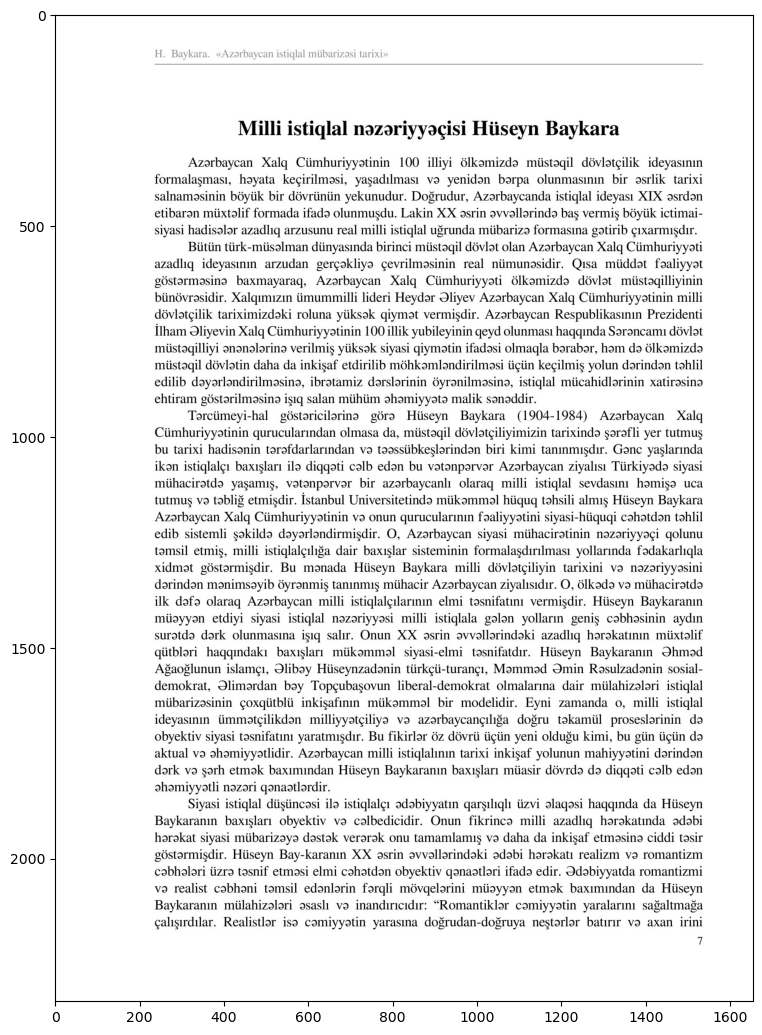

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 16))
plt.imshow(train[0]['image'])
plt.show()

In [7]:
import numpy as np
result = inferencer(np.array(train[0]['image']), show=True, return_vis=True)

C:\Users\timos\anaconda3\envs\torch\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

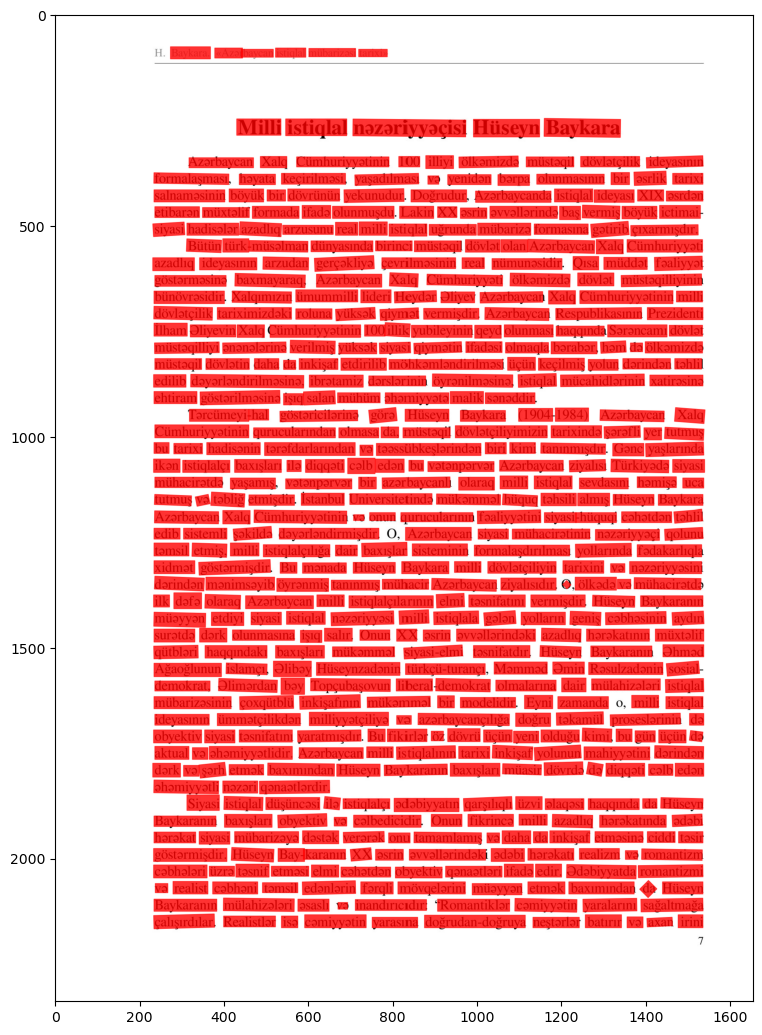

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 16))
plt.imshow(result['visualization'][0])
plt.show()

### Установка easyocr и инициализация reader'ов

In [9]:
!pip install easyocr

Active code page: 65001



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# инициализация reader'ов для уточнения прогнозов
import easyocr
reader_en = easyocr.Reader(['en'])
reader_lv = easyocr.Reader(['lv']) # не используется в новом API
reader_lt = easyocr.Reader(['lt']) # не используется в новом API
reader_ru = easyocr.Reader(['ru']) # не используется в новом API
reader_be = easyocr.Reader(['be']) # не используется в новом API

### Распознавание скрипта

In [11]:
from PIL import Image
from tesserocr import PyTessBaseAPI
import numpy as np
import threading

def get_total_class(images: list) -> int:
  counts = [0] * 6
  arr = [[], [], [], [], [], []]
  sumarr = [0] * 6

  def cyrillic():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'script/Cyrillic')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[0].append([0])
        else:
          arr[0].append(res)

  def georgian():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'script/Georgian')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[1].append([0])
        else:
          arr[1].append(res)

  def chinnese():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'script/HanS')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[2].append([0])
        else:
          arr[2].append(res)

  def japanese():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'script/Japanese')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[3].append([0])
        else:
          arr[3].append(res)

  def latin():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'script/Latin')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[4].append([0])
        else:
          arr[4].append(res)

  def korean():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'kor')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[5].append([0])
        else:
          arr[5].append(res)

  thr_list = [
    threading.Thread(target=cyrillic),
    threading.Thread(target=georgian),
    threading.Thread(target=chinnese),
    threading.Thread(target=japanese),
    threading.Thread(target=latin),
    threading.Thread(target=korean)
  ]
  for thread in thr_list:
    thread.start()
  for thread in thr_list:
    thread.join()

  for z in range(len(images)):
    n = min(map(len, [el[z] for el in arr]))
    for i in range(n):
      scores = [arr[j][z][i] for j in range(len(arr))]
      if max(scores) != 0:
        counts[np.argmax(scores)] += 1
  #print('script counts = ', counts)
  return counts

### Получение класса из кириллицы

In [12]:
from PIL import Image
from tesserocr import PyTessBaseAPI
import numpy as np
import threading

def get_cyrillic_class(images: list) -> int:
  counts = [0] * 5
  arr = [[], [], [], [], []]
  sumarr = [0] * 5
  def bel():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'bel')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[0].append([0])
        else:
          arr[0].append(res)

  def kaz():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'kaz')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[1].append([0])
        else:
          arr[1].append(res)

  def mon():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'mon')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[2].append([0])
        else:
          arr[2].append(res)

  def rus():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'rus')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[3].append([0])
        else:
          arr[3].append(res)

  def ukr():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'ukr')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[4].append([0])
        else:
          arr[4].append(res)

  thr_list = [
    threading.Thread(target=bel),
    threading.Thread(target=kaz),
    threading.Thread(target=mon),
    threading.Thread(target=rus),
    threading.Thread(target=ukr)
  ]
  for thread in thr_list:
    thread.start()
  for thread in thr_list:
    thread.join()

  for z in range(len(images)):
    n = min(map(len, [el[z] for el in arr]))
    for i in range(n):
      scores = [arr[j][z][i] for j in range(len(arr))]
      if max(scores) != 0:
        counts[np.argmax(scores)] += 1

  #print('cyr counts = ', counts)
  return counts

### Получение класса из латинских языков

In [13]:
from PIL import Image
from tesserocr import PyTessBaseAPI
import numpy as np
import threading

def get_latin_class(images: list) -> int:
  counts = [0] * 8
  arr = [[], [], [], [], [], [], [], []]
  sumarr = [0] * 8

  def aze():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'aze')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[0].append([0])
        else:
          arr[0].append(res)
  def eng():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'eng')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[1].append([0])
        else:
          arr[1].append(res)

  def est():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'est')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[2].append([0])
        else:
          arr[2].append(res)

  def fin():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'fin')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[3].append([0])
        else:
          arr[3].append(res)

  def lav():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'lav')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[4].append([0])
        else:
          arr[4].append(res)

  def lit():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'lit')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[5].append([0])
        else:
          arr[5].append(res)

  def nor():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'nor')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[6].append([0])
        else:
          arr[6].append(res)

  def pol():
    with PyTessBaseAPI() as api:
      api.Init(lang = 'pol')
      for img in images:
        api.SetImage(img)
        res = list(api.AllWordConfidences())
        if not res:
          arr[7].append([0])
        else:
          arr[7].append(res)

  thr_list = [
    threading.Thread(target=aze),
    threading.Thread(target=eng),
    threading.Thread(target=est),
    threading.Thread(target=fin),
    threading.Thread(target=lav),
    threading.Thread(target=lit),
    threading.Thread(target=nor),
    threading.Thread(target=pol)
  ]
  for thread in thr_list:
    thread.start()
  for thread in thr_list:
    thread.join()

  for z in range(len(images)):
    n = min(map(len, [el[z] for el in arr]))
    for i in range(n):
      scores = [arr[j][z][i] for j in range(len(arr))]
      if max(scores) != 0:
        counts[np.argmax(scores)] += 1
  #print('lat counts = ', counts)
  return counts

### Сам API для определения класса (устаревший, в тестах использовался новый)

In [14]:
import copy
def predict(img: Image) -> int:
  width, height = img.size
  # я специально ухудшаю качество изображения ради ускорения работы как MMOCR,
  # так и tesseract, хотя это вероятно может сильно сказываться на точности
  # //но для easyocr я оставляю оригинальное разрешение, т.к. для него это критично
  original_img = copy.deepcopy(img)
  if width > 1500 or height > 1500:
    ratio = max(width, height) / 1500
    new_width, new_height = int(width / ratio), int(height / ratio)
    img = img.resize((new_width, new_height), Image.BICUBIC)
  width, height = original_img.size
  if width > 2500 or height > 2500:
    ratio = max(width, height) / 2500
    new_width, new_height = int(width / ratio), int(height / ratio)
    original_img = original_img.resize((new_width, new_height), Image.BICUBIC)
  #script detection part
  img_arr = np.array(img)
  result = inferencer(img_arr, progress_bar=False)
  polygons = result['predictions'][0]['polygons']
  predictions = result['predictions']
  new_polygons = []
  for pol, prec in zip(predictions[0]['polygons'], predictions[0]['scores']):
    if prec > 0.7:
      new_polygons.append(pol)
  counts = [0] * 6
  i = 0
  cropped_images = []
  for tmp in new_polygons:
    if i != 0 and i % 50 == 0:
      counts = [cnt + add for cnt, add in zip(counts, get_total_class(cropped_images))]
      tmp_counts = sorted(counts)
      cropped_images = []
      if tmp_counts[-1] > 50 and tmp_counts[-1] > tmp_counts[-2] * 1.3:
        break
    max_x, max_y = max(tmp[::2]), max(tmp[1::2])
    min_x, min_y = min(tmp[::2]), min(tmp[1::2])
    #max_y += (max_y - min_y) / 5
    #min_y -= (max_y - min_y) / 5
    #max_y += (max_y - min_y) / 2
    #min_y -= (max_y - min_y) / 2
    #max_x += (max_x - min_x) / 2
    #min_x -= (max_x - min_x) / 2
    area = (min_x, min_y, max_x, max_y)
    cropped_img = img.crop(area)
    cropped_images.append(cropped_img)
    #cropped_img.show()
    i += 1
  else:
    counts = [cnt + add for cnt, add in zip(counts, get_total_class(cropped_images))]

  script_label = np.argmax(counts)
  if script_label == 1:
    tmp = reader_en.readtext(np.array(original_img))
    en_score = sum((crop[2] for crop in tmp)) / len(tmp)
    #print('en_score =', en_score)
    if en_score >= 0.5:
      return 3
  #language detection part
  special_languages = {1 : 6, 2 : 2, 3 : 7, 5 : 8}
  if script_label in special_languages:
    return special_languages[script_label]
  elif script_label == 0:
    #tmp = reader_lv.readtext(original_img)
    #tmp2 = reader_lt.readtext(original_img)
    #lv_score, lt_score = sum((crop[2] for crop in tmp)) / len(tmp), sum((crop[2] for crop in tmp2)) / len(tmp2)
    #print(lv_score, lt_score)
    #if lv_score >= 0.4 or lt_score >= 0.4:
    #  return 10 if lv_score == max(lv_score, lt_score) else 11
    tmp = reader_lt.readtext(np.array(original_img))
    lt_score = sum((crop[2] for crop in tmp)) / len(tmp)
    if lt_score >= 0.5:
      return 11

    cyrillic_languages = {0 : 1, 1 : 9, 2 : 12, 3 : 15, 4 : 16}
    counts = [0] * 5
    i = 0
    cropped_images = []
    for tmp in new_polygons:
      if i != 0 and i % 30 == 0:
        counts = [cnt + add for cnt, add in zip(counts, get_cyrillic_class(cropped_images))]
        tmp_counts = sorted(counts)
        cropped_images = []
        if tmp_counts[-1] > 30 and tmp_counts[-1] > tmp_counts[-2] * 1.5:
          break
      max_x, max_y = max(tmp[::2]), max(tmp[1::2])
      min_x, min_y = min(tmp[::2]), min(tmp[1::2])
      #max_y += (max_y - min_y) / 5
      #min_y -= (max_y - min_y) / 5
      area = (min_x, min_y, max_x, max_y)
      cropped_img = img.crop(area)
      cropped_images.append(cropped_img)
      i += 1
    else:
      counts = [cnt + add for cnt, add in zip(counts, get_cyrillic_class(cropped_images))]
    if np.argmax(counts) == 0:
      tmp = reader_be.readtext(np.array(original_img))
      tmp2 = reader_ru.readtext(np.array(original_img))
      be_score, ru_score = sum((crop[2] for crop in tmp)) / len(tmp), sum((crop[2] for crop in tmp2)) / len(tmp2)
      #print(be_score, ru_score)
      return 1 if be_score == max(be_score, ru_score) else 15
    return cyrillic_languages[np.argmax(counts)]
  else:
    latin_languages = {0 : 0, 1 : 3, 2 : 4, 3 : 5, 4 : 10, 5 : 11, 6 : 13, 7 : 14}
    counts = [0] * 8
    i = 0
    cropped_images = []
    for tmp in new_polygons:
      if i != 0 and i % 30 == 0:
        counts = [cnt + add for cnt, add in zip(counts, get_latin_class(cropped_images))]
        tmp_counts = sorted(counts)
        cropped_images = []
        if tmp_counts[-1] > 30 and tmp_counts[-1] > tmp_counts[-2] * 1.5:
          break
      max_x, max_y = max(tmp[::2]), max(tmp[1::2])
      min_x, min_y = min(tmp[::2]), min(tmp[1::2])
      #max_y += (max_y - min_y) / 5
      #min_y -= (max_y - min_y) / 5
      area = (min_x, min_y, max_x, max_y)
      cropped_img = img.crop(area)
      cropped_images.append(cropped_img)
      i += 1
    else:
      counts = [cnt + add for cnt, add in zip(counts, get_latin_class(cropped_images))]
    if np.argmax(counts) == 0 and (counts[0] // 2.5 < counts[4] * 2 or counts[0] // 2.5 < counts[5] * 2):
      return 10 if counts[4] > counts[5] else 11
      #potential_label = 10 if counts[4] > counts[5] else 11
      #tmp = reader_lv.readtext(original_img)
      #tmp2 = reader_lt.readtext(original_img)
      #lv_score, lt_score = sum((crop[2] for crop in tmp)) / len(tmp), sum((crop[2] for crop in tmp2)) / len(tmp2)
      #print(lv_score, lt_score)
      #if lv_score >= 0.7 or lt_score >= 0.7:
      #  return 10 if lv_score == max(lv_score, lt_score) else 11
    return latin_languages[np.argmax(counts)]

## Новый API с минимально возможным использованием easyocr для сохранения хорошей точности

In [15]:
import copy
from PIL import ImageCms
def predict(img: Image) -> int:
  if img.mode != 'RGB':
    img = img.convert('RGB')
  width, height = img.size
  # я специально ухудшаю качество изображения ради ускорения работы как MMOCR,
  # так и tesseract, хотя это вероятно может сильно сказываться на точности
  original_img = copy.deepcopy(img)
  if width > 2000 or height > 2000:
    ratio = max(width, height) / 2000
    new_width, new_height = int(width / ratio), int(height / ratio)
    img = img.resize((new_width, new_height), Image.BICUBIC)
  width, height = original_img.size
  if width > 2500 or height > 2500:
    ratio = max(width, height) / 2500
    new_width, new_height = int(width / ratio), int(height / ratio)
    original_img = original_img.resize((new_width, new_height), Image.BICUBIC)
  #script detection part
  img_arr = np.array(img)
  result = inferencer(img_arr, progress_bar=False)
  polygons = result['predictions'][0]['polygons']
  predictions = result['predictions']
  new_polygons = []
  for pol, prec in zip(predictions[0]['polygons'], predictions[0]['scores']):
    if prec > 0.7:
      new_polygons.append(pol)
  counts = [0] * 6
  i = 0
  cropped_images = []
  for tmp in new_polygons:
    if i != 0 and i % 50 == 0:
      counts = [cnt + add for cnt, add in zip(counts, get_total_class(cropped_images))]
      tmp_counts = sorted(counts)
      cropped_images = []
      if tmp_counts[-1] > 50 and tmp_counts[-1] > tmp_counts[-2] * 1.3:
        break
    max_x, max_y = max(tmp[::2]), max(tmp[1::2])
    min_x, min_y = min(tmp[::2]), min(tmp[1::2])
    #max_y += (max_y - min_y) / 5
    #min_y -= (max_y - min_y) / 5
    #max_y += (max_y - min_y) / 2
    #min_y -= (max_y - min_y) / 2
    #max_x += (max_x - min_x) / 2
    #min_x -= (max_x - min_x) / 2
    area = (min_x, min_y, max_x, max_y)
    cropped_img = img.crop(area)
    cropped_images.append(cropped_img)
    #cropped_img.show()
    i += 1
  else:
    counts = [cnt + add for cnt, add in zip(counts, get_total_class(cropped_images))]
  tmp_counts = sorted(counts)
  script_label = np.argmax(counts)
  if script_label == 1:
    tmp = reader_en.readtext(np.array(original_img))
    en_score = sum((crop[2] for crop in tmp)) / len(tmp)
    #print('en_score =', en_score)
    if en_score >= 0.5:
      return 3
  #language detection part
  special_languages = {1 : 6, 2 : 2, 3 : 7, 5 : 8}
  if script_label in special_languages:
    return special_languages[script_label]
  elif script_label == 0:
    #tmp = reader_lv.readtext(original_img)
    #tmp2 = reader_lt.readtext(original_img)
    #lv_score, lt_score = sum((crop[2] for crop in tmp)) / len(tmp), sum((crop[2] for crop in tmp2)) / len(tmp2)
    #print(lv_score, lt_score)
    #if lv_score >= 0.4 or lt_score >= 0.4:
    #  return 10 if lv_score == max(lv_score, lt_score) else 11
    #tmp = reader_lt.readtext(np.array(original_img))
    #lt_score = sum((crop[2] for crop in tmp)) / len(tmp)
    #if lt_score >= 0.5:
    #  return 11

    cyrillic_languages = {0 : 1, 1 : 9, 2 : 12, 3 : 15, 4 : 16}
    counts = [0] * 5
    i = 0
    cropped_images = []
    for tmp in new_polygons:
      if i != 0 and i % 30 == 0:
        counts = [cnt + add for cnt, add in zip(counts, get_cyrillic_class(cropped_images))]
        tmp_counts = sorted(counts)
        cropped_images = []
        if tmp_counts[-1] > 30 and tmp_counts[-1] > tmp_counts[-2] * 1.5:
          break
      max_x, max_y = max(tmp[::2]), max(tmp[1::2])
      min_x, min_y = min(tmp[::2]), min(tmp[1::2])
      #max_y += (max_y - min_y) / 5
      #min_y -= (max_y - min_y) / 5
      area = (min_x, min_y, max_x, max_y)
      cropped_img = img.crop(area)
      cropped_images.append(cropped_img)
      i += 1
    else:
      counts = [cnt + add for cnt, add in zip(counts, get_cyrillic_class(cropped_images))]
    #if np.argmax(counts) == 0:
      #tmp = reader_be.readtext(np.array(original_img))
      #tmp2 = reader_ru.readtext(np.array(original_img))
      #be_score, ru_score = sum((crop[2] for crop in tmp)) / len(tmp), sum((crop[2] for crop in tmp2)) / len(tmp2)
      #print(be_score, ru_score)
      #return 1 if be_score == max(be_score, ru_score) else 15
    return cyrillic_languages[np.argmax(counts)]
  else:
    latin_languages = {0 : 0, 1 : 3, 2 : 4, 3 : 5, 4 : 10, 5 : 11, 6 : 13, 7 : 14}
    counts = [0] * 8
    i = 0
    cropped_images = []
    for tmp in new_polygons:
      if i != 0 and i % 30 == 0:
        counts = [cnt + add for cnt, add in zip(counts, get_latin_class(cropped_images))]
        tmp_counts = sorted(counts)
        cropped_images = []
        if tmp_counts[-1] > 30 and tmp_counts[-1] > tmp_counts[-2] * 1.5:
          break
      max_x, max_y = max(tmp[::2]), max(tmp[1::2])
      min_x, min_y = min(tmp[::2]), min(tmp[1::2])
      #max_y += (max_y - min_y) / 5
      #min_y -= (max_y - min_y) / 5
      area = (min_x, min_y, max_x, max_y)
      cropped_img = img.crop(area)
      cropped_images.append(cropped_img)
      i += 1
    else:
      counts = [cnt + add for cnt, add in zip(counts, get_latin_class(cropped_images))]
    if np.argmax(counts) == 0 and (counts[0] // 2.5 < counts[4] * 2 or counts[0] // 2.5 < counts[5] * 2):
      return 10 if counts[4] > counts[5] else 11
      #potential_label = 10 if counts[4] > counts[5] else 11
      #tmp = reader_lv.readtext(original_img)
      #tmp2 = reader_lt.readtext(original_img)
      #lv_score, lt_score = sum((crop[2] for crop in tmp)) / len(tmp), sum((crop[2] for crop in tmp2)) / len(tmp2)
      #print(lv_score, lt_score)
      #if lv_score >= 0.7 or lt_score >= 0.7:
      #  return 10 if lv_score == max(lv_score, lt_score) else 11
    return latin_languages[np.argmax(counts)]

In [18]:
from tqdm import tqdm
correct_answers = 0
total_answers = 0

y_true = []
y_pred = []
for i in (pbar := tqdm(range(len(test)))):
  img, label = test[i]['image'], test[i]['label']
  answer = predict(img)
  y_true.append(label)
  y_pred.append(answer)
  if answer == label:
    correct_answers += 1
  else:
    print(f'wrong label {answer}, expected {label}')
  total_answers += 1

  pbar.set_description(f'Accuracy: {(correct_answers / total_answers) * 100: .2f}%')
    

print(f'total accuracy = {(correct_answers / total_answers) * 100: .2f}%')


  0%|          | 0/339 [00:00<?, ?it/s]

Accuracy:  100.00%:   0%|          | 1/339 [00:11<1:02:50, 11.16s/it]

Accuracy:  100.00%:   1%|          | 2/339 [00:21<58:44, 10.46s/it]  

Accuracy:  100.00%:   1%|          | 3/339 [00:30<54:47,  9.78s/it]

Accuracy:  100.00%:   1%|          | 4/339 [00:42<1:00:46, 10.88s/it]

Accuracy:  100.00%:   1%|▏         | 5/339 [00:51<57:05, 10.26s/it]  

Accuracy:  100.00%:   2%|▏         | 6/339 [01:00<53:21,  9.61s/it]

Accuracy:  100.00%:   2%|▏         | 7/339 [01:10<53:33,  9.68s/it]

Accuracy:  100.00%:   2%|▏         | 8/339 [01:19<52:13,  9.47s/it]

Accuracy:  100.00%:   3%|▎         | 9/339 [01:27<50:01,  9.10s/it]

Accuracy:  100.00%:   3%|▎         | 10/339 [01:35<48:18,  8.81s/it]

Accuracy:  100.00%:   3%|▎         | 11/339 [01:46<51:38,  9.45s/it]

Accuracy:  100.00%:   4%|▎         | 12/339 [01:55<50:32,  9.27s/it]

Accuracy:  100.00%:   4%|▍         | 13/339 [02:04<50:52,  9.36s/it]

Accuracy:  100.00%:   4%|▍         | 14/339 [02:14<50:34,  9.34s/it]

Accuracy:  100.00%:   4%|▍         | 15/339 [02:21<48:05,  8.91s/it]

Accuracy:  100.00%:   5%|▍         | 16/339 [02:29<46:10,  8.58s/it]

Accuracy:  100.00%:   5%|▌         | 17/339 [02:41<51:43,  9.64s/it]

Accuracy:  100.00%:   5%|▌         | 18/339 [02:52<52:28,  9.81s/it]

Accuracy:  100.00%:   6%|▌         | 19/339 [03:00<50:02,  9.38s/it]

Accuracy:  100.00%:   6%|▌         | 20/339 [03:08<48:17,  9.08s/it]

Accuracy:  100.00%:   6%|▌         | 21/339 [03:16<46:34,  8.79s/it]

Accuracy:  100.00%:   6%|▋         | 22/339 [03:25<46:33,  8.81s/it]

Accuracy:  100.00%:   7%|▋         | 23/339 [03:34<45:25,  8.62s/it]

Accuracy:  100.00%:   7%|▋         | 24/339 [03:43<46:12,  8.80s/it]

Accuracy:  100.00%:   7%|▋         | 25/339 [03:53<47:56,  9.16s/it]

Accuracy:  100.00%:   8%|▊         | 26/339 [04:03<49:33,  9.50s/it]

Accuracy:  100.00%:   8%|▊         | 27/339 [04:13<50:07,  9.64s/it]

Accuracy:  100.00%:   8%|▊         | 28/339 [04:22<49:12,  9.49s/it]

Accuracy:  100.00%:   9%|▊         | 29/339 [04:31<47:48,  9.25s/it]

Accuracy:  100.00%:   9%|▉         | 30/339 [04:41<48:36,  9.44s/it]

Accuracy:  100.00%:   9%|▉         | 31/339 [04:49<46:41,  9.10s/it]

Accuracy:  100.00%:   9%|▉         | 32/339 [04:58<46:14,  9.04s/it]

Accuracy:  100.00%:  10%|▉         | 33/339 [05:07<45:42,  8.96s/it]

Accuracy:  100.00%:  10%|█         | 34/339 [05:14<43:43,  8.60s/it]

Accuracy:  100.00%:  10%|█         | 35/339 [05:22<42:35,  8.41s/it]

Accuracy:  100.00%:  11%|█         | 36/339 [05:30<41:16,  8.17s/it]

Accuracy:  100.00%:  11%|█         | 37/339 [05:38<41:01,  8.15s/it]

Accuracy:  100.00%:  11%|█         | 38/339 [05:47<41:16,  8.23s/it]

Accuracy:  100.00%:  12%|█▏        | 39/339 [05:55<41:44,  8.35s/it]

Accuracy:  100.00%:  12%|█▏        | 40/339 [06:00<35:53,  7.20s/it]

Accuracy:  100.00%:  12%|█▏        | 41/339 [06:03<30:31,  6.14s/it]

Accuracy:  100.00%:  12%|█▏        | 42/339 [06:08<27:36,  5.58s/it]

Accuracy:  100.00%:  13%|█▎        | 43/339 [06:10<23:06,  4.68s/it]

Accuracy:  100.00%:  13%|█▎        | 44/339 [06:14<21:54,  4.46s/it]

Accuracy:  97.78%:  13%|█▎        | 45/339 [06:20<24:12,  4.94s/it] 

wrong label 1, expected 2


Accuracy:  95.65%:  14%|█▎        | 46/339 [06:26<25:14,  5.17s/it]

wrong label 1, expected 2


Accuracy:  95.74%:  14%|█▍        | 47/339 [06:31<25:38,  5.27s/it]

Accuracy:  95.83%:  14%|█▍        | 48/339 [06:36<25:04,  5.17s/it]

Accuracy:  93.88%:  14%|█▍        | 49/339 [06:38<20:06,  4.16s/it]

wrong label 1, expected 2


Accuracy:  94.00%:  15%|█▍        | 50/339 [06:42<19:27,  4.04s/it]

Accuracy:  94.12%:  15%|█▌        | 51/339 [06:47<20:46,  4.33s/it]

Accuracy:  94.23%:  15%|█▌        | 52/339 [06:52<22:07,  4.63s/it]

Accuracy:  94.34%:  16%|█▌        | 53/339 [06:56<20:50,  4.37s/it]

Accuracy:  92.59%:  16%|█▌        | 54/339 [07:03<23:46,  5.01s/it]

wrong label 1, expected 2


Accuracy:  92.73%:  16%|█▌        | 55/339 [07:07<22:23,  4.73s/it]

Accuracy:  92.86%:  17%|█▋        | 56/339 [07:11<22:08,  4.69s/it]

Accuracy:  92.98%:  17%|█▋        | 57/339 [07:16<21:28,  4.57s/it]

Accuracy:  93.10%:  17%|█▋        | 58/339 [07:21<22:03,  4.71s/it]

Accuracy:  93.22%:  17%|█▋        | 59/339 [07:24<20:43,  4.44s/it]

Accuracy:  93.33%:  18%|█▊        | 60/339 [07:50<49:33, 10.66s/it]

Accuracy:  93.44%:  18%|█▊        | 61/339 [08:17<1:13:04, 15.77s/it]

Accuracy:  93.55%:  18%|█▊        | 62/339 [08:50<1:36:22, 20.88s/it]

Accuracy:  93.65%:  19%|█▊        | 63/339 [09:09<1:33:06, 20.24s/it]

Accuracy:  93.75%:  19%|█▉        | 64/339 [09:34<1:39:15, 21.66s/it]

Accuracy:  93.85%:  19%|█▉        | 65/339 [09:57<1:41:32, 22.24s/it]

Accuracy:  93.94%:  19%|█▉        | 66/339 [10:22<1:44:53, 23.05s/it]

Accuracy:  94.03%:  20%|█▉        | 67/339 [10:44<1:43:09, 22.76s/it]

Accuracy:  94.12%:  20%|██        | 68/339 [11:10<1:47:09, 23.73s/it]

Accuracy:  94.20%:  20%|██        | 69/339 [11:27<1:37:46, 21.73s/it]

Accuracy:  94.29%:  21%|██        | 70/339 [11:59<1:50:32, 24.66s/it]

Accuracy:  94.37%:  21%|██        | 71/339 [12:33<2:02:45, 27.48s/it]

Accuracy:  93.06%:  21%|██        | 72/339 [13:22<2:30:54, 33.91s/it]

wrong label 6, expected 3


Accuracy:  93.15%:  22%|██▏       | 73/339 [14:36<3:23:34, 45.92s/it]

Accuracy:  93.24%:  22%|██▏       | 74/339 [15:10<3:06:37, 42.26s/it]

Accuracy:  93.33%:  22%|██▏       | 75/339 [15:45<2:57:07, 40.26s/it]

Accuracy:  93.42%:  22%|██▏       | 76/339 [16:15<2:42:29, 37.07s/it]

Accuracy:  93.51%:  23%|██▎       | 77/339 [16:34<2:18:20, 31.68s/it]

Accuracy:  93.59%:  23%|██▎       | 78/339 [17:03<2:14:44, 30.98s/it]

Accuracy:  93.67%:  23%|██▎       | 79/339 [17:23<2:00:05, 27.71s/it]

Accuracy:  93.75%:  24%|██▎       | 80/339 [17:32<1:34:45, 21.95s/it]

Accuracy:  93.83%:  24%|██▍       | 81/339 [17:40<1:16:08, 17.71s/it]

Accuracy:  93.90%:  24%|██▍       | 82/339 [17:49<1:04:37, 15.09s/it]

Accuracy:  93.98%:  24%|██▍       | 83/339 [17:56<54:37, 12.80s/it]  

Accuracy:  94.05%:  25%|██▍       | 84/339 [18:05<49:36, 11.67s/it]

Accuracy:  94.12%:  25%|██▌       | 85/339 [18:13<45:09, 10.67s/it]

Accuracy:  94.19%:  25%|██▌       | 86/339 [18:21<40:44,  9.66s/it]

Accuracy:  94.25%:  26%|██▌       | 87/339 [18:28<37:05,  8.83s/it]

Accuracy:  94.32%:  26%|██▌       | 88/339 [18:35<34:42,  8.30s/it]

Accuracy:  94.38%:  26%|██▋       | 89/339 [18:43<34:33,  8.29s/it]

Accuracy:  94.44%:  27%|██▋       | 90/339 [18:50<32:52,  7.92s/it]

Accuracy:  94.51%:  27%|██▋       | 91/339 [18:58<32:35,  7.88s/it]

Accuracy:  94.57%:  27%|██▋       | 92/339 [19:06<32:28,  7.89s/it]

Accuracy:  94.62%:  27%|██▋       | 93/339 [19:13<32:11,  7.85s/it]

Accuracy:  94.68%:  28%|██▊       | 94/339 [19:21<31:04,  7.61s/it]

Accuracy:  94.74%:  28%|██▊       | 95/339 [19:32<35:51,  8.82s/it]

Accuracy:  94.79%:  28%|██▊       | 96/339 [19:41<35:11,  8.69s/it]

Accuracy:  94.85%:  29%|██▊       | 97/339 [19:48<33:26,  8.29s/it]

Accuracy:  94.90%:  29%|██▉       | 98/339 [19:55<31:18,  7.79s/it]

Accuracy:  94.95%:  29%|██▉       | 99/339 [20:03<31:59,  8.00s/it]

Accuracy:  95.00%:  29%|██▉       | 100/339 [20:11<31:38,  7.94s/it]

Accuracy:  95.05%:  30%|██▉       | 101/339 [20:21<33:36,  8.47s/it]

Accuracy:  95.10%:  30%|███       | 102/339 [20:31<35:39,  9.03s/it]

Accuracy:  95.15%:  30%|███       | 103/339 [20:40<36:09,  9.19s/it]

Accuracy:  95.19%:  31%|███       | 104/339 [20:48<34:21,  8.77s/it]

Accuracy:  95.24%:  31%|███       | 105/339 [20:59<36:18,  9.31s/it]

Accuracy:  95.28%:  31%|███▏      | 106/339 [21:08<36:15,  9.34s/it]

Accuracy:  95.33%:  32%|███▏      | 107/339 [21:18<37:07,  9.60s/it]

Accuracy:  95.37%:  32%|███▏      | 108/339 [21:30<39:43, 10.32s/it]

Accuracy:  95.41%:  32%|███▏      | 109/339 [21:39<37:05,  9.68s/it]

Accuracy:  94.55%:  32%|███▏      | 110/339 [22:03<53:51, 14.11s/it]

wrong label 0, expected 5


Accuracy:  94.59%:  33%|███▎      | 111/339 [22:12<48:09, 12.67s/it]

Accuracy:  94.64%:  33%|███▎      | 112/339 [22:22<44:05, 11.65s/it]

Accuracy:  94.69%:  33%|███▎      | 113/339 [22:32<42:57, 11.41s/it]

Accuracy:  94.74%:  34%|███▎      | 114/339 [22:42<41:00, 10.93s/it]

Accuracy:  94.78%:  34%|███▍      | 115/339 [22:53<40:08, 10.75s/it]

Accuracy:  94.83%:  34%|███▍      | 116/339 [23:02<38:34, 10.38s/it]

Accuracy:  94.87%:  35%|███▍      | 117/339 [23:13<38:28, 10.40s/it]

Accuracy:  94.92%:  35%|███▍      | 118/339 [23:22<36:58, 10.04s/it]

Accuracy:  94.96%:  35%|███▌      | 119/339 [23:31<35:39,  9.73s/it]

Accuracy:  95.00%:  35%|███▌      | 120/339 [24:11<1:08:27, 18.75s/it]

Accuracy:  95.04%:  36%|███▌      | 121/339 [25:16<1:59:05, 32.78s/it]

Accuracy:  95.08%:  36%|███▌      | 122/339 [26:22<2:34:13, 42.65s/it]

Accuracy:  95.12%:  36%|███▋      | 123/339 [27:19<2:49:21, 47.05s/it]

Accuracy:  94.35%:  37%|███▋      | 124/339 [27:29<2:08:09, 35.77s/it]

wrong label 1, expected 6


Accuracy:  94.40%:  37%|███▋      | 125/339 [28:31<2:35:43, 43.66s/it]

Accuracy:  94.44%:  37%|███▋      | 126/339 [29:17<2:37:39, 44.41s/it]

Accuracy:  94.49%:  37%|███▋      | 127/339 [30:04<2:39:57, 45.27s/it]

Accuracy:  94.53%:  38%|███▊      | 128/339 [30:17<2:05:21, 35.65s/it]

Accuracy:  94.57%:  38%|███▊      | 129/339 [30:29<1:40:12, 28.63s/it]

Accuracy:  94.62%:  38%|███▊      | 130/339 [30:43<1:23:57, 24.10s/it]

Accuracy:  94.66%:  39%|███▊      | 131/339 [30:57<1:13:01, 21.06s/it]

Accuracy:  94.70%:  39%|███▉      | 132/339 [31:12<1:05:54, 19.10s/it]

Accuracy:  94.74%:  39%|███▉      | 133/339 [31:25<59:34, 17.35s/it]  

Accuracy:  94.78%:  40%|███▉      | 134/339 [31:39<56:21, 16.49s/it]

Accuracy:  94.81%:  40%|███▉      | 135/339 [31:54<54:11, 15.94s/it]

Accuracy:  94.85%:  40%|████      | 136/339 [32:07<51:00, 15.08s/it]

Accuracy:  94.89%:  40%|████      | 137/339 [32:21<49:28, 14.69s/it]

Accuracy:  94.93%:  41%|████      | 138/339 [32:34<48:03, 14.34s/it]

Accuracy:  94.96%:  41%|████      | 139/339 [32:49<47:57, 14.39s/it]

Accuracy:  95.00%:  41%|████▏     | 140/339 [32:52<36:09, 10.90s/it]

Accuracy:  95.04%:  42%|████▏     | 141/339 [32:56<29:48,  9.03s/it]

Accuracy:  95.07%:  42%|████▏     | 142/339 [33:01<25:00,  7.62s/it]

Accuracy:  95.10%:  42%|████▏     | 143/339 [33:05<22:00,  6.74s/it]

Accuracy:  95.14%:  42%|████▏     | 144/339 [33:10<20:15,  6.23s/it]

Accuracy:  95.17%:  43%|████▎     | 145/339 [33:15<18:42,  5.79s/it]

Accuracy:  95.21%:  43%|████▎     | 146/339 [33:20<17:36,  5.48s/it]

Accuracy:  95.24%:  43%|████▎     | 147/339 [33:22<14:16,  4.46s/it]

Accuracy:  95.27%:  44%|████▎     | 148/339 [33:24<11:50,  3.72s/it]

Accuracy:  94.63%:  44%|████▍     | 149/339 [33:26<10:05,  3.19s/it]

wrong label 1, expected 7


Accuracy:  94.67%:  44%|████▍     | 150/339 [33:30<10:47,  3.43s/it]

Accuracy:  94.70%:  45%|████▍     | 151/339 [33:35<11:58,  3.82s/it]

Accuracy:  94.74%:  45%|████▍     | 152/339 [33:40<12:59,  4.17s/it]

Accuracy:  94.77%:  45%|████▌     | 153/339 [33:45<13:58,  4.51s/it]

Accuracy:  94.81%:  45%|████▌     | 154/339 [33:49<13:15,  4.30s/it]

Accuracy:  94.84%:  46%|████▌     | 155/339 [33:52<12:00,  3.92s/it]

Accuracy:  94.87%:  46%|████▌     | 156/339 [33:54<10:22,  3.40s/it]

Accuracy:  94.90%:  46%|████▋     | 157/339 [33:56<09:02,  2.98s/it]

Accuracy:  94.94%:  47%|████▋     | 158/339 [34:01<10:36,  3.52s/it]

Accuracy:  94.97%:  47%|████▋     | 159/339 [34:06<11:57,  3.99s/it]

Accuracy:  95.00%:  47%|████▋     | 160/339 [34:10<11:44,  3.94s/it]

Accuracy:  95.03%:  47%|████▋     | 161/339 [34:13<11:12,  3.78s/it]

Accuracy:  95.06%:  48%|████▊     | 162/339 [34:17<11:24,  3.86s/it]

Accuracy:  95.09%:  48%|████▊     | 163/339 [34:20<10:54,  3.72s/it]

Accuracy:  95.12%:  48%|████▊     | 164/339 [34:23<09:38,  3.31s/it]

Accuracy:  95.15%:  49%|████▊     | 165/339 [34:24<08:10,  2.82s/it]

Accuracy:  95.18%:  49%|████▉     | 166/339 [34:28<09:05,  3.15s/it]

Accuracy:  95.21%:  49%|████▉     | 167/339 [34:33<10:33,  3.69s/it]

Accuracy:  95.24%:  50%|████▉     | 168/339 [34:38<10:58,  3.85s/it]

Accuracy:  94.67%:  50%|████▉     | 169/339 [34:43<12:04,  4.26s/it]

wrong label 1, expected 8


Accuracy:  94.71%:  50%|█████     | 170/339 [34:45<10:26,  3.71s/it]

Accuracy:  94.74%:  50%|█████     | 171/339 [34:48<09:20,  3.34s/it]

Accuracy:  94.77%:  51%|█████     | 172/339 [34:50<08:31,  3.06s/it]

Accuracy:  94.80%:  51%|█████     | 173/339 [34:54<09:09,  3.31s/it]

Accuracy:  94.83%:  51%|█████▏    | 174/339 [34:55<07:38,  2.78s/it]

Accuracy:  94.86%:  52%|█████▏    | 175/339 [34:58<07:14,  2.65s/it]

Accuracy:  94.89%:  52%|█████▏    | 176/339 [35:00<06:50,  2.52s/it]

Accuracy:  94.92%:  52%|█████▏    | 177/339 [35:04<07:54,  2.93s/it]

Accuracy:  94.94%:  53%|█████▎    | 178/339 [35:07<08:21,  3.11s/it]

Accuracy:  94.97%:  53%|█████▎    | 179/339 [35:10<07:51,  2.95s/it]

Accuracy:  95.00%:  53%|█████▎    | 180/339 [35:16<10:23,  3.92s/it]

Accuracy:  95.03%:  53%|█████▎    | 181/339 [35:23<12:23,  4.70s/it]

Accuracy:  95.05%:  54%|█████▎    | 182/339 [35:42<23:50,  9.11s/it]

Accuracy:  95.08%:  54%|█████▍    | 183/339 [35:51<23:43,  9.12s/it]

Accuracy:  95.11%:  54%|█████▍    | 184/339 [36:01<23:55,  9.26s/it]

Accuracy:  95.14%:  55%|█████▍    | 185/339 [36:11<24:14,  9.44s/it]

Accuracy:  95.16%:  55%|█████▍    | 186/339 [36:17<21:59,  8.62s/it]

Accuracy:  95.19%:  55%|█████▌    | 187/339 [36:24<20:32,  8.11s/it]

Accuracy:  95.21%:  55%|█████▌    | 188/339 [36:31<19:23,  7.70s/it]

Accuracy:  95.24%:  56%|█████▌    | 189/339 [36:37<17:45,  7.10s/it]

Accuracy:  95.26%:  56%|█████▌    | 190/339 [36:45<18:05,  7.28s/it]

Accuracy:  95.29%:  56%|█████▋    | 191/339 [36:51<17:35,  7.13s/it]

Accuracy:  95.31%:  57%|█████▋    | 192/339 [36:59<17:46,  7.25s/it]

Accuracy:  95.34%:  57%|█████▋    | 193/339 [37:06<17:45,  7.30s/it]

Accuracy:  95.36%:  57%|█████▋    | 194/339 [37:13<17:00,  7.03s/it]

Accuracy:  95.38%:  58%|█████▊    | 195/339 [37:21<17:55,  7.47s/it]

Accuracy:  95.41%:  58%|█████▊    | 196/339 [37:29<18:10,  7.63s/it]

Accuracy:  95.43%:  58%|█████▊    | 197/339 [37:36<17:22,  7.34s/it]

Accuracy:  95.45%:  58%|█████▊    | 198/339 [37:44<17:35,  7.48s/it]

Accuracy:  95.48%:  59%|█████▊    | 199/339 [37:52<18:24,  7.89s/it]

Accuracy:  95.50%:  59%|█████▉    | 200/339 [38:30<39:08, 16.90s/it]

Accuracy:  95.02%:  59%|█████▉    | 201/339 [38:41<34:22, 14.94s/it]

wrong label 0, expected 10


Accuracy:  95.05%:  60%|█████▉    | 202/339 [38:54<32:36, 14.28s/it]

Accuracy:  95.07%:  60%|█████▉    | 203/339 [39:06<31:13, 13.78s/it]

Accuracy:  95.10%:  60%|██████    | 204/339 [39:23<33:15, 14.78s/it]

Accuracy:  95.12%:  60%|██████    | 205/339 [39:34<30:37, 13.71s/it]

Accuracy:  95.15%:  61%|██████    | 206/339 [40:04<40:58, 18.48s/it]

Accuracy:  95.17%:  61%|██████    | 207/339 [40:18<37:43, 17.15s/it]

Accuracy:  95.19%:  61%|██████▏   | 208/339 [40:33<35:44, 16.37s/it]

Accuracy:  95.22%:  62%|██████▏   | 209/339 [40:49<35:10, 16.24s/it]

Accuracy:  95.24%:  62%|██████▏   | 210/339 [41:01<32:09, 14.95s/it]

Accuracy:  95.26%:  62%|██████▏   | 211/339 [41:22<36:15, 17.00s/it]

Accuracy:  94.81%:  63%|██████▎   | 212/339 [41:33<32:16, 15.25s/it]

wrong label 0, expected 10


Accuracy:  94.84%:  63%|██████▎   | 213/339 [41:45<29:31, 14.06s/it]

Accuracy:  94.86%:  63%|██████▎   | 214/339 [41:56<27:27, 13.18s/it]

Accuracy:  94.88%:  63%|██████▎   | 215/339 [42:10<27:49, 13.46s/it]

Accuracy:  94.91%:  64%|██████▎   | 216/339 [42:37<36:06, 17.61s/it]

Accuracy:  94.47%:  64%|██████▍   | 217/339 [42:53<34:36, 17.02s/it]

wrong label 1, expected 10


Accuracy:  94.04%:  64%|██████▍   | 218/339 [43:08<33:18, 16.52s/it]

wrong label 1, expected 10


Accuracy:  93.61%:  65%|██████▍   | 219/339 [43:19<29:22, 14.69s/it]

wrong label 0, expected 10


Accuracy:  93.64%:  65%|██████▍   | 220/339 [43:24<23:49, 12.01s/it]

Accuracy:  93.21%:  65%|██████▌   | 221/339 [43:31<20:19, 10.33s/it]

wrong label 1, expected 11


Accuracy:  93.24%:  65%|██████▌   | 222/339 [43:41<20:15, 10.39s/it]

Accuracy:  92.83%:  66%|██████▌   | 223/339 [43:47<17:08,  8.87s/it]

wrong label 1, expected 11


Accuracy:  92.86%:  66%|██████▌   | 224/339 [43:58<18:13,  9.51s/it]

Accuracy:  92.44%:  66%|██████▋   | 225/339 [44:04<16:23,  8.63s/it]

wrong label 1, expected 11


Accuracy:  92.04%:  67%|██████▋   | 226/339 [44:08<13:40,  7.26s/it]

wrong label 1, expected 11


Accuracy:  92.07%:  67%|██████▋   | 227/339 [44:20<15:46,  8.45s/it]

Accuracy:  92.11%:  67%|██████▋   | 228/339 [44:27<14:45,  7.98s/it]

Accuracy:  92.14%:  68%|██████▊   | 229/339 [45:13<35:32, 19.39s/it]

Accuracy:  92.17%:  68%|██████▊   | 230/339 [45:24<31:06, 17.12s/it]

Accuracy:  92.21%:  68%|██████▊   | 231/339 [45:35<27:04, 15.04s/it]

Accuracy:  91.81%:  68%|██████▊   | 232/339 [45:46<24:38, 13.82s/it]

wrong label 1, expected 11


Accuracy:  91.85%:  69%|██████▊   | 233/339 [45:59<24:08, 13.66s/it]

Accuracy:  91.45%:  69%|██████▉   | 234/339 [46:06<20:24, 11.67s/it]

wrong label 1, expected 11


Accuracy:  91.49%:  69%|██████▉   | 235/339 [46:14<18:13, 10.51s/it]

Accuracy:  91.53%:  70%|██████▉   | 236/339 [46:26<19:06, 11.13s/it]

Accuracy:  91.56%:  70%|██████▉   | 237/339 [46:35<17:37, 10.36s/it]

Accuracy:  91.18%:  70%|███████   | 238/339 [46:39<14:30,  8.62s/it]

wrong label 1, expected 11


Accuracy:  91.21%:  71%|███████   | 239/339 [46:48<14:29,  8.70s/it]

Accuracy:  91.25%:  71%|███████   | 240/339 [46:57<14:10,  8.59s/it]

Accuracy:  91.29%:  71%|███████   | 241/339 [47:04<13:40,  8.37s/it]

Accuracy:  91.32%:  71%|███████▏  | 242/339 [47:12<13:07,  8.11s/it]

Accuracy:  91.36%:  72%|███████▏  | 243/339 [47:20<13:05,  8.18s/it]

Accuracy:  91.39%:  72%|███████▏  | 244/339 [47:28<12:50,  8.11s/it]

Accuracy:  91.43%:  72%|███████▏  | 245/339 [47:37<12:59,  8.29s/it]

Accuracy:  91.46%:  73%|███████▎  | 246/339 [47:46<12:59,  8.38s/it]

Accuracy:  91.50%:  73%|███████▎  | 247/339 [47:54<12:44,  8.31s/it]

Accuracy:  91.53%:  73%|███████▎  | 248/339 [48:02<12:30,  8.25s/it]

Accuracy:  91.57%:  73%|███████▎  | 249/339 [48:09<11:44,  7.82s/it]

Accuracy:  91.60%:  74%|███████▎  | 250/339 [48:17<11:55,  8.04s/it]

Accuracy:  91.63%:  74%|███████▍  | 251/339 [48:26<11:59,  8.17s/it]

Accuracy:  91.67%:  74%|███████▍  | 252/339 [48:34<11:51,  8.17s/it]

Accuracy:  91.70%:  75%|███████▍  | 253/339 [48:42<11:33,  8.07s/it]

Accuracy:  91.73%:  75%|███████▍  | 254/339 [48:50<11:37,  8.21s/it]

Accuracy:  91.76%:  75%|███████▌  | 255/339 [48:58<11:26,  8.17s/it]

Accuracy:  91.80%:  76%|███████▌  | 256/339 [49:08<11:46,  8.51s/it]

Accuracy:  91.83%:  76%|███████▌  | 257/339 [49:16<11:36,  8.50s/it]

Accuracy:  91.86%:  76%|███████▌  | 258/339 [49:24<11:24,  8.45s/it]

Accuracy:  91.89%:  76%|███████▋  | 259/339 [49:33<11:20,  8.50s/it]

Accuracy:  91.92%:  77%|███████▋  | 260/339 [49:48<13:35, 10.33s/it]

Accuracy:  91.95%:  77%|███████▋  | 261/339 [49:57<13:00, 10.00s/it]

Accuracy:  91.98%:  77%|███████▋  | 262/339 [50:07<12:54, 10.05s/it]

Accuracy:  92.02%:  78%|███████▊  | 263/339 [50:25<15:35, 12.31s/it]

Accuracy:  92.05%:  78%|███████▊  | 264/339 [50:37<15:33, 12.45s/it]

Accuracy:  92.08%:  78%|███████▊  | 265/339 [50:48<14:50, 12.03s/it]

Accuracy:  91.73%:  78%|███████▊  | 266/339 [50:59<14:05, 11.58s/it]

wrong label 3, expected 13


Accuracy:  91.39%:  79%|███████▉  | 267/339 [51:03<11:10,  9.31s/it]

wrong label 0, expected 13


Accuracy:  91.04%:  79%|███████▉  | 268/339 [51:05<08:32,  7.22s/it]

wrong label 5, expected 13


Accuracy:  91.08%:  79%|███████▉  | 269/339 [51:13<08:25,  7.22s/it]

Accuracy:  90.74%:  80%|███████▉  | 270/339 [51:14<06:26,  5.60s/it]

wrong label 3, expected 13


Accuracy:  90.77%:  80%|███████▉  | 271/339 [51:24<07:48,  6.89s/it]

Accuracy:  90.81%:  80%|████████  | 272/339 [51:38<10:09,  9.10s/it]

Accuracy:  90.48%:  81%|████████  | 273/339 [51:52<11:35, 10.53s/it]

wrong label 0, expected 13


Accuracy:  90.51%:  81%|████████  | 274/339 [52:05<12:00, 11.09s/it]

Accuracy:  90.55%:  81%|████████  | 275/339 [52:11<10:24,  9.76s/it]

Accuracy:  90.58%:  81%|████████▏ | 276/339 [52:24<11:17, 10.76s/it]

Accuracy:  90.61%:  82%|████████▏ | 277/339 [52:34<10:36, 10.26s/it]

Accuracy:  90.65%:  82%|████████▏ | 278/339 [52:50<12:18, 12.10s/it]

Accuracy:  90.68%:  82%|████████▏ | 279/339 [53:05<13:00, 13.02s/it]

Accuracy:  90.71%:  83%|████████▎ | 280/339 [53:14<11:29, 11.68s/it]

Accuracy:  90.75%:  83%|████████▎ | 281/339 [53:24<10:49, 11.20s/it]

Accuracy:  90.78%:  83%|████████▎ | 282/339 [53:34<10:26, 10.99s/it]

Accuracy:  90.81%:  83%|████████▎ | 283/339 [53:44<10:00, 10.72s/it]

Accuracy:  90.85%:  84%|████████▍ | 284/339 [53:53<09:08,  9.98s/it]

Accuracy:  90.88%:  84%|████████▍ | 285/339 [54:01<08:27,  9.39s/it]

Accuracy:  90.91%:  84%|████████▍ | 286/339 [54:10<08:11,  9.26s/it]

Accuracy:  90.94%:  85%|████████▍ | 287/339 [54:19<07:59,  9.22s/it]

Accuracy:  90.97%:  85%|████████▍ | 288/339 [54:28<07:54,  9.30s/it]

Accuracy:  91.00%:  85%|████████▌ | 289/339 [54:37<07:35,  9.11s/it]

Accuracy:  91.03%:  86%|████████▌ | 290/339 [54:48<07:50,  9.59s/it]

Accuracy:  91.07%:  86%|████████▌ | 291/339 [54:58<07:58,  9.98s/it]

Accuracy:  91.10%:  86%|████████▌ | 292/339 [55:07<07:29,  9.56s/it]

Accuracy:  91.13%:  86%|████████▋ | 293/339 [55:16<07:13,  9.43s/it]

Accuracy:  91.16%:  87%|████████▋ | 294/339 [55:33<08:42, 11.60s/it]

Accuracy:  91.19%:  87%|████████▋ | 295/339 [55:47<09:00, 12.29s/it]

Accuracy:  91.22%:  87%|████████▋ | 296/339 [55:58<08:38, 12.06s/it]

Accuracy:  91.25%:  88%|████████▊ | 297/339 [56:08<08:02, 11.48s/it]

Accuracy:  91.28%:  88%|████████▊ | 298/339 [56:16<07:05, 10.37s/it]

Accuracy:  91.30%:  88%|████████▊ | 299/339 [56:24<06:20,  9.52s/it]

Accuracy:  91.33%:  88%|████████▊ | 300/339 [57:04<12:08, 18.67s/it]

Accuracy:  91.36%:  89%|████████▉ | 301/339 [57:43<15:41, 24.78s/it]

Accuracy:  91.06%:  89%|████████▉ | 302/339 [57:57<13:15, 21.50s/it]

wrong label 1, expected 15


Accuracy:  91.09%:  89%|████████▉ | 303/339 [58:28<14:43, 24.53s/it]

Accuracy:  91.12%:  90%|████████▉ | 304/339 [59:14<17:58, 30.82s/it]

Accuracy:  90.82%:  90%|████████▉ | 305/339 [59:58<19:49, 34.99s/it]

wrong label 1, expected 15


Accuracy:  90.85%:  90%|█████████ | 306/339 [1:00:47<21:31, 39.12s/it]

Accuracy:  90.88%:  91%|█████████ | 307/339 [1:00:57<16:13, 30.43s/it]

Accuracy:  90.91%:  91%|█████████ | 308/339 [1:01:47<18:44, 36.29s/it]

Accuracy:  90.94%:  91%|█████████ | 309/339 [1:01:57<14:10, 28.35s/it]

Accuracy:  90.65%:  91%|█████████▏| 310/339 [1:02:07<11:00, 22.78s/it]

wrong label 1, expected 15


Accuracy:  90.35%:  92%|█████████▏| 311/339 [1:02:14<08:25, 18.06s/it]

wrong label 1, expected 15


Accuracy:  90.06%:  92%|█████████▏| 312/339 [1:02:22<06:44, 15.00s/it]

wrong label 1, expected 15


Accuracy:  89.78%:  92%|█████████▏| 313/339 [1:02:31<05:47, 13.36s/it]

wrong label 1, expected 15


Accuracy:  89.81%:  93%|█████████▎| 314/339 [1:03:21<10:02, 24.12s/it]

Accuracy:  89.84%:  93%|█████████▎| 315/339 [1:03:33<08:13, 20.54s/it]

Accuracy:  89.56%:  93%|█████████▎| 316/339 [1:03:44<06:50, 17.85s/it]

wrong label 1, expected 15


Accuracy:  89.59%:  94%|█████████▎| 317/339 [1:04:25<09:05, 24.81s/it]

Accuracy:  89.62%:  94%|█████████▍| 318/339 [1:04:51<08:47, 25.10s/it]

Accuracy:  89.66%:  94%|█████████▍| 319/339 [1:05:01<06:51, 20.57s/it]

Accuracy:  89.69%:  94%|█████████▍| 320/339 [1:05:09<05:18, 16.74s/it]

Accuracy:  89.72%:  95%|█████████▍| 321/339 [1:05:18<04:17, 14.29s/it]

Accuracy:  89.75%:  95%|█████████▍| 322/339 [1:05:26<03:31, 12.43s/it]

Accuracy:  89.78%:  95%|█████████▌| 323/339 [1:05:34<02:57, 11.11s/it]

Accuracy:  89.81%:  96%|█████████▌| 324/339 [1:05:41<02:28,  9.93s/it]

Accuracy:  89.85%:  96%|█████████▌| 325/339 [1:05:50<02:13,  9.55s/it]

Accuracy:  89.88%:  96%|█████████▌| 326/339 [1:05:58<01:59,  9.18s/it]

Accuracy:  89.91%:  96%|█████████▋| 327/339 [1:06:06<01:47,  8.94s/it]

Accuracy:  89.94%:  97%|█████████▋| 328/339 [1:06:15<01:37,  8.85s/it]

Accuracy:  89.97%:  97%|█████████▋| 329/339 [1:06:24<01:28,  8.82s/it]

Accuracy:  90.00%:  97%|█████████▋| 330/339 [1:06:32<01:17,  8.59s/it]

Accuracy:  90.03%:  98%|█████████▊| 331/339 [1:06:40<01:07,  8.38s/it]

Accuracy:  90.06%:  98%|█████████▊| 332/339 [1:06:49<01:01,  8.82s/it]

Accuracy:  90.09%:  98%|█████████▊| 333/339 [1:06:58<00:52,  8.81s/it]

Accuracy:  90.12%:  99%|█████████▊| 334/339 [1:07:06<00:42,  8.56s/it]

Accuracy:  90.15%:  99%|█████████▉| 335/339 [1:07:15<00:34,  8.58s/it]

Accuracy:  90.18%:  99%|█████████▉| 336/339 [1:07:23<00:25,  8.56s/it]

Accuracy:  90.21%:  99%|█████████▉| 337/339 [1:07:32<00:17,  8.54s/it]

Accuracy:  90.24%: 100%|█████████▉| 338/339 [1:07:40<00:08,  8.54s/it]

Accuracy:  90.27%: 100%|██████████| 339/339 [1:07:48<00:00, 12.00s/it]

total accuracy =  90.27%


In [21]:
#расчет f1 метрик
from sklearn.metrics import f1_score
f1_scores = f1_score(y_true, y_pred, average=None)
codes = {
    0: 'azer', 1: 'belarus', 2: 'chinese', 3: 'english', 4: 'eston', 5: 'fin',
    6: 'georg', 7: 'japanese', 8: 'korean', 9: 'kaz', 10: 'latv', 11 : 'litv',
    12: 'mongolian', 13: 'norwegian', 14: 'polska', 15: 'russian', 16: 'ukranian'
}
for code, score in enumerate(f1_scores): print(f'f1 score for {codes[code]} is {score : .2f}')

f1 score for azer is  0.86
f1 score for belarus is  0.63
f1 score for chinese is  0.89
f1 score for english is  0.93
f1 score for eston is  1.00
f1 score for fin is  0.95
f1 score for georg is  0.95
f1 score for japanese is  0.97
f1 score for korean is  0.97
f1 score for kaz is  1.00
f1 score for latv is  0.86
f1 score for litv is  0.79
f1 score for mongolian is  1.00
f1 score for norwegian is  0.86
f1 score for polska is  1.00
f1 score for russian is  0.79
f1 score for ukranian is  1.00


### Запуск для всего датасета

In [22]:
dataset = load_dataset('imagefolder', data_dir='./documents/data')

Resolving data files: 100%|██████████| 2326/2326 [00:00<00:00, 11291.24it/s]


Extracting data files: 0it [00:00, ?it/s]


Dataset imagefolder downloaded and prepared to C:/Users/timos/.cache/huggingface/datasets/imagefolder/default-f5767f8bbc06adc0/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2326
    })
})

In [25]:
train = dataset['train']

In [26]:
from tqdm import tqdm
correct_answers = 0
total_answers = 0

y_true = []
y_pred = []
for i in (pbar := tqdm(range(len(train)))):
  img, label = train[i]['image'], train[i]['label']
  answer = predict(img)
  y_true.append(label)
  y_pred.append(answer)
  if answer == label:
    correct_answers += 1
  else:
    print(f'wrong label {answer}, expected {label}')
  total_answers += 1

  pbar.set_description(f'Accuracy: {(correct_answers / total_answers) * 100: .2f}%')
    

print(f'total accuracy = {(correct_answers / total_answers) * 100: .2f}%')

  0%|          | 0/2326 [00:00<?, ?it/s]

Accuracy:  100.00%:   0%|          | 1/2326 [00:11<7:32:00, 11.66s/it]

Accuracy:  100.00%:   0%|          | 2/2326 [00:20<6:19:01,  9.79s/it]

Accuracy:  100.00%:   0%|          | 3/2326 [00:30<6:36:29, 10.24s/it]

Accuracy:  100.00%:   0%|          | 4/2326 [00:40<6:26:44,  9.99s/it]

Accuracy:  100.00%:   0%|          | 5/2326 [00:49<6:13:13,  9.65s/it]

Accuracy:  100.00%:   0%|          | 6/2326 [01:02<6:51:36, 10.65s/it]

Accuracy:  100.00%:   0%|          | 7/2326 [01:11<6:29:07, 10.07s/it]

Accuracy:  100.00%:   0%|          | 8/2326 [01:19<6:05:16,  9.45s/it]

Accuracy:  100.00%:   0%|          | 9/2326 [01:27<5:48:48,  9.03s/it]

Accuracy:  100.00%:   0%|          | 10/2326 [01:35<5:33:30,  8.64s/it]

Accuracy:  100.00%:   0%|          | 11/2326 [01:44<5:40:18,  8.82s/it]

Accuracy:  100.00%:   1%|          | 12/2326 [01:53<5:39:55,  8.81s/it]

Accuracy:  100.00%:   1%|          | 13/2326 [02:01<5:30:31,  8.57s/it]

Accuracy:  100.00%:   1%|          | 14/2326 [02:09<5:33:03,  8.64s/it]

Accuracy:  100.00%:   1%|          | 15/2326 [02:18<5:30:52,  8.59s/it]

Accuracy:  100.00%:   1%|          | 16/2326 [02:27<5:37:49,  8.77s/it]

Accuracy:  100.00%:   1%|          | 17/2326 [02:38<6:06:10,  9.52s/it]

Accuracy:  100.00%:   1%|          | 18/2326 [02:46<5:49:19,  9.08s/it]

Accuracy:  100.00%:   1%|          | 19/2326 [02:56<5:51:09,  9.13s/it]

Accuracy:  100.00%:   1%|          | 20/2326 [03:04<5:38:45,  8.81s/it]

Accuracy:  100.00%:   1%|          | 21/2326 [03:12<5:31:32,  8.63s/it]

Accuracy:  100.00%:   1%|          | 22/2326 [03:21<5:31:53,  8.64s/it]

Accuracy:  100.00%:   1%|          | 23/2326 [03:29<5:24:59,  8.47s/it]

Accuracy:  100.00%:   1%|          | 24/2326 [03:38<5:31:39,  8.64s/it]

Accuracy:  100.00%:   1%|          | 25/2326 [03:46<5:23:30,  8.44s/it]

Accuracy:  100.00%:   1%|          | 26/2326 [03:54<5:18:24,  8.31s/it]

Accuracy:  100.00%:   1%|          | 27/2326 [04:02<5:14:49,  8.22s/it]

Accuracy:  100.00%:   1%|          | 28/2326 [04:10<5:20:11,  8.36s/it]

Accuracy:  100.00%:   1%|          | 29/2326 [04:19<5:18:20,  8.32s/it]

Accuracy:  100.00%:   1%|▏         | 30/2326 [04:28<5:25:58,  8.52s/it]

Accuracy:  100.00%:   1%|▏         | 31/2326 [04:37<5:34:21,  8.74s/it]

Accuracy:  100.00%:   1%|▏         | 32/2326 [04:48<5:56:53,  9.33s/it]

Accuracy:  100.00%:   1%|▏         | 33/2326 [04:55<5:41:00,  8.92s/it]

Accuracy:  100.00%:   1%|▏         | 34/2326 [05:04<5:36:43,  8.81s/it]

Accuracy:  100.00%:   2%|▏         | 35/2326 [05:14<5:52:22,  9.23s/it]

Accuracy:  100.00%:   2%|▏         | 36/2326 [05:25<6:09:06,  9.67s/it]

Accuracy:  100.00%:   2%|▏         | 37/2326 [05:36<6:24:58, 10.09s/it]

Accuracy:  100.00%:   2%|▏         | 38/2326 [05:45<6:16:33,  9.87s/it]

Accuracy:  100.00%:   2%|▏         | 39/2326 [05:54<6:02:06,  9.50s/it]

Accuracy:  100.00%:   2%|▏         | 40/2326 [06:03<6:01:42,  9.49s/it]

Accuracy:  100.00%:   2%|▏         | 41/2326 [06:11<5:44:04,  9.03s/it]

Accuracy:  100.00%:   2%|▏         | 42/2326 [06:20<5:33:14,  8.75s/it]

Accuracy:  100.00%:   2%|▏         | 43/2326 [06:28<5:32:06,  8.73s/it]

Accuracy:  100.00%:   2%|▏         | 44/2326 [06:39<5:51:13,  9.23s/it]

Accuracy:  100.00%:   2%|▏         | 45/2326 [06:46<5:31:22,  8.72s/it]

Accuracy:  100.00%:   2%|▏         | 46/2326 [06:54<5:21:29,  8.46s/it]

Accuracy:  100.00%:   2%|▏         | 47/2326 [07:02<5:19:26,  8.41s/it]

Accuracy:  100.00%:   2%|▏         | 48/2326 [07:11<5:17:03,  8.35s/it]

Accuracy:  100.00%:   2%|▏         | 49/2326 [07:21<5:44:41,  9.08s/it]

Accuracy:  100.00%:   2%|▏         | 50/2326 [07:29<5:27:26,  8.63s/it]

Accuracy:  100.00%:   2%|▏         | 51/2326 [07:38<5:32:56,  8.78s/it]

Accuracy:  100.00%:   2%|▏         | 52/2326 [07:49<5:57:13,  9.43s/it]

Accuracy:  100.00%:   2%|▏         | 53/2326 [07:59<6:06:36,  9.68s/it]

Accuracy:  100.00%:   2%|▏         | 54/2326 [08:08<5:53:46,  9.34s/it]

Accuracy:  100.00%:   2%|▏         | 55/2326 [08:17<5:57:12,  9.44s/it]

Accuracy:  100.00%:   2%|▏         | 56/2326 [08:26<5:42:57,  9.07s/it]

Accuracy:  100.00%:   2%|▏         | 57/2326 [08:34<5:36:17,  8.89s/it]

Accuracy:  100.00%:   2%|▏         | 58/2326 [08:44<5:44:18,  9.11s/it]

Accuracy:  100.00%:   3%|▎         | 59/2326 [08:54<5:55:48,  9.42s/it]

Accuracy:  100.00%:   3%|▎         | 60/2326 [09:06<6:31:25, 10.36s/it]

Accuracy:  100.00%:   3%|▎         | 61/2326 [09:16<6:16:55,  9.98s/it]

Accuracy:  100.00%:   3%|▎         | 62/2326 [09:25<6:07:23,  9.74s/it]

Accuracy:  100.00%:   3%|▎         | 63/2326 [09:35<6:10:17,  9.82s/it]

Accuracy:  100.00%:   3%|▎         | 64/2326 [09:43<5:53:05,  9.37s/it]

Accuracy:  100.00%:   3%|▎         | 65/2326 [09:53<6:01:13,  9.59s/it]

Accuracy:  100.00%:   3%|▎         | 66/2326 [10:03<6:03:07,  9.64s/it]

Accuracy:  100.00%:   3%|▎         | 67/2326 [10:12<5:55:18,  9.44s/it]

Accuracy:  100.00%:   3%|▎         | 68/2326 [10:21<5:52:49,  9.38s/it]

Accuracy:  100.00%:   3%|▎         | 69/2326 [10:30<5:42:31,  9.11s/it]

Accuracy:  100.00%:   3%|▎         | 70/2326 [10:38<5:33:29,  8.87s/it]

Accuracy:  100.00%:   3%|▎         | 71/2326 [10:49<5:57:59,  9.53s/it]

Accuracy:  100.00%:   3%|▎         | 72/2326 [10:57<5:39:08,  9.03s/it]

Accuracy:  100.00%:   3%|▎         | 73/2326 [11:06<5:39:36,  9.04s/it]

Accuracy:  100.00%:   3%|▎         | 74/2326 [11:15<5:38:42,  9.02s/it]

Accuracy:  100.00%:   3%|▎         | 75/2326 [11:26<5:58:21,  9.55s/it]

Accuracy:  100.00%:   3%|▎         | 76/2326 [11:37<6:15:29, 10.01s/it]

Accuracy:  100.00%:   3%|▎         | 77/2326 [11:45<6:00:18,  9.61s/it]

Accuracy:  100.00%:   3%|▎         | 78/2326 [11:56<6:11:45,  9.92s/it]

Accuracy:  100.00%:   3%|▎         | 79/2326 [12:05<5:56:24,  9.52s/it]

Accuracy:  100.00%:   3%|▎         | 80/2326 [12:14<5:54:00,  9.46s/it]

Accuracy:  100.00%:   3%|▎         | 81/2326 [12:23<5:54:21,  9.47s/it]

Accuracy:  100.00%:   4%|▎         | 82/2326 [12:32<5:40:55,  9.12s/it]

Accuracy:  100.00%:   4%|▎         | 83/2326 [12:41<5:41:46,  9.14s/it]

Accuracy:  100.00%:   4%|▎         | 84/2326 [12:50<5:40:05,  9.10s/it]

Accuracy:  100.00%:   4%|▎         | 85/2326 [12:59<5:39:44,  9.10s/it]

Accuracy:  100.00%:   4%|▎         | 86/2326 [13:07<5:29:47,  8.83s/it]

Accuracy:  100.00%:   4%|▎         | 87/2326 [13:18<5:49:13,  9.36s/it]

Accuracy:  100.00%:   4%|▍         | 88/2326 [13:27<5:48:19,  9.34s/it]

Accuracy:  100.00%:   4%|▍         | 89/2326 [13:36<5:43:07,  9.20s/it]

Accuracy:  100.00%:   4%|▍         | 90/2326 [13:47<6:03:06,  9.74s/it]

Accuracy:  100.00%:   4%|▍         | 91/2326 [13:57<6:02:32,  9.73s/it]

Accuracy:  100.00%:   4%|▍         | 92/2326 [14:06<5:55:11,  9.54s/it]

Accuracy:  100.00%:   4%|▍         | 93/2326 [14:14<5:40:59,  9.16s/it]

Accuracy:  100.00%:   4%|▍         | 94/2326 [14:22<5:30:50,  8.89s/it]

Accuracy:  100.00%:   4%|▍         | 95/2326 [14:34<5:57:10,  9.61s/it]

Accuracy:  100.00%:   4%|▍         | 96/2326 [14:45<6:11:34, 10.00s/it]

Accuracy:  100.00%:   4%|▍         | 97/2326 [14:54<6:01:55,  9.74s/it]

Accuracy:  100.00%:   4%|▍         | 98/2326 [15:03<5:57:00,  9.61s/it]

Accuracy:  100.00%:   4%|▍         | 99/2326 [15:12<5:54:17,  9.55s/it]

Accuracy:  100.00%:   4%|▍         | 100/2326 [15:20<5:35:37,  9.05s/it]

Accuracy:  100.00%:   4%|▍         | 101/2326 [15:28<5:20:54,  8.65s/it]

Accuracy:  100.00%:   4%|▍         | 102/2326 [15:40<5:58:41,  9.68s/it]

Accuracy:  100.00%:   4%|▍         | 103/2326 [15:50<6:05:37,  9.87s/it]

Accuracy:  100.00%:   4%|▍         | 104/2326 [15:59<5:50:44,  9.47s/it]

Accuracy:  100.00%:   5%|▍         | 105/2326 [16:06<5:29:24,  8.90s/it]

Accuracy:  100.00%:   5%|▍         | 106/2326 [16:12<4:56:57,  8.03s/it]

Accuracy:  100.00%:   5%|▍         | 107/2326 [16:21<4:58:05,  8.06s/it]

Accuracy:  100.00%:   5%|▍         | 108/2326 [16:29<4:57:18,  8.04s/it]

Accuracy:  100.00%:   5%|▍         | 109/2326 [16:38<5:09:21,  8.37s/it]

Accuracy:  100.00%:   5%|▍         | 110/2326 [16:47<5:18:53,  8.63s/it]

Accuracy:  100.00%:   5%|▍         | 111/2326 [16:56<5:21:15,  8.70s/it]

Accuracy:  100.00%:   5%|▍         | 112/2326 [17:00<4:27:32,  7.25s/it]

Accuracy:  100.00%:   5%|▍         | 113/2326 [17:06<4:16:22,  6.95s/it]

Accuracy:  100.00%:   5%|▍         | 114/2326 [17:15<4:39:37,  7.58s/it]

Accuracy:  100.00%:   5%|▍         | 115/2326 [17:24<4:51:00,  7.90s/it]

Accuracy:  100.00%:   5%|▍         | 116/2326 [17:32<4:55:47,  8.03s/it]

Accuracy:  100.00%:   5%|▌         | 117/2326 [17:41<5:03:24,  8.24s/it]

Accuracy:  100.00%:   5%|▌         | 118/2326 [17:50<5:14:36,  8.55s/it]

Accuracy:  100.00%:   5%|▌         | 119/2326 [17:59<5:18:17,  8.65s/it]

Accuracy:  100.00%:   5%|▌         | 120/2326 [18:07<5:16:18,  8.60s/it]

Accuracy:  100.00%:   5%|▌         | 121/2326 [18:17<5:22:04,  8.76s/it]

Accuracy:  100.00%:   5%|▌         | 122/2326 [18:24<5:11:35,  8.48s/it]

Accuracy:  100.00%:   5%|▌         | 123/2326 [18:32<4:57:07,  8.09s/it]

Accuracy:  100.00%:   5%|▌         | 124/2326 [18:38<4:40:52,  7.65s/it]

Accuracy:  100.00%:   5%|▌         | 125/2326 [18:46<4:40:03,  7.63s/it]

Accuracy:  100.00%:   5%|▌         | 126/2326 [18:55<4:54:06,  8.02s/it]

Accuracy:  100.00%:   5%|▌         | 127/2326 [19:04<5:06:18,  8.36s/it]

Accuracy:  100.00%:   6%|▌         | 128/2326 [19:13<5:18:47,  8.70s/it]

Accuracy:  100.00%:   6%|▌         | 129/2326 [19:22<5:13:58,  8.57s/it]

Accuracy:  100.00%:   6%|▌         | 130/2326 [19:30<5:15:53,  8.63s/it]

Accuracy:  100.00%:   6%|▌         | 131/2326 [19:39<5:14:01,  8.58s/it]

Accuracy:  100.00%:   6%|▌         | 132/2326 [19:46<5:01:46,  8.25s/it]

Accuracy:  100.00%:   6%|▌         | 133/2326 [19:56<5:21:03,  8.78s/it]

Accuracy:  100.00%:   6%|▌         | 134/2326 [20:06<5:31:02,  9.06s/it]

Accuracy:  100.00%:   6%|▌         | 135/2326 [20:15<5:24:37,  8.89s/it]

Accuracy:  100.00%:   6%|▌         | 136/2326 [20:22<5:05:04,  8.36s/it]

Accuracy:  100.00%:   6%|▌         | 137/2326 [20:30<5:03:48,  8.33s/it]

Accuracy:  100.00%:   6%|▌         | 138/2326 [20:38<5:00:48,  8.25s/it]

Accuracy:  100.00%:   6%|▌         | 139/2326 [20:46<4:54:52,  8.09s/it]

Accuracy:  100.00%:   6%|▌         | 140/2326 [20:56<5:14:16,  8.63s/it]

Accuracy:  100.00%:   6%|▌         | 141/2326 [21:04<5:06:48,  8.42s/it]

Accuracy:  100.00%:   6%|▌         | 142/2326 [21:12<5:03:35,  8.34s/it]

Accuracy:  100.00%:   6%|▌         | 143/2326 [21:20<5:07:28,  8.45s/it]

Accuracy:  100.00%:   6%|▌         | 144/2326 [21:28<5:02:17,  8.31s/it]

Accuracy:  100.00%:   6%|▌         | 145/2326 [21:37<5:02:00,  8.31s/it]

Accuracy:  100.00%:   6%|▋         | 146/2326 [21:45<5:03:11,  8.34s/it]

Accuracy:  100.00%:   6%|▋         | 147/2326 [21:53<4:57:33,  8.19s/it]

Accuracy:  100.00%:   6%|▋         | 148/2326 [21:59<4:37:02,  7.63s/it]

Accuracy:  100.00%:   6%|▋         | 149/2326 [22:07<4:43:04,  7.80s/it]

Accuracy:  100.00%:   6%|▋         | 150/2326 [22:16<4:45:42,  7.88s/it]

Accuracy:  100.00%:   6%|▋         | 151/2326 [22:24<4:55:45,  8.16s/it]

Accuracy:  100.00%:   7%|▋         | 152/2326 [22:33<4:58:33,  8.24s/it]

Accuracy:  100.00%:   7%|▋         | 153/2326 [22:43<5:16:42,  8.75s/it]

Accuracy:  100.00%:   7%|▋         | 154/2326 [22:50<5:04:02,  8.40s/it]

Accuracy:  100.00%:   7%|▋         | 155/2326 [23:00<5:13:50,  8.67s/it]

Accuracy:  100.00%:   7%|▋         | 156/2326 [23:09<5:21:38,  8.89s/it]

Accuracy:  100.00%:   7%|▋         | 157/2326 [23:18<5:18:36,  8.81s/it]

Accuracy:  100.00%:   7%|▋         | 158/2326 [23:27<5:24:23,  8.98s/it]

Accuracy:  100.00%:   7%|▋         | 159/2326 [23:35<5:18:15,  8.81s/it]

Accuracy:  100.00%:   7%|▋         | 160/2326 [23:45<5:29:33,  9.13s/it]

Accuracy:  100.00%:   7%|▋         | 161/2326 [23:53<5:14:05,  8.70s/it]

Accuracy:  100.00%:   7%|▋         | 162/2326 [24:02<5:18:11,  8.82s/it]

Accuracy:  100.00%:   7%|▋         | 163/2326 [24:10<5:06:43,  8.51s/it]

Accuracy:  100.00%:   7%|▋         | 164/2326 [24:18<5:00:42,  8.35s/it]

Accuracy:  100.00%:   7%|▋         | 165/2326 [24:26<4:54:04,  8.17s/it]

Accuracy:  100.00%:   7%|▋         | 166/2326 [24:34<4:59:37,  8.32s/it]

Accuracy:  100.00%:   7%|▋         | 167/2326 [24:43<5:04:09,  8.45s/it]

Accuracy:  100.00%:   7%|▋         | 168/2326 [24:52<5:11:29,  8.66s/it]

Accuracy:  100.00%:   7%|▋         | 169/2326 [25:01<5:13:31,  8.72s/it]

Accuracy:  100.00%:   7%|▋         | 170/2326 [25:09<5:00:48,  8.37s/it]

Accuracy:  100.00%:   7%|▋         | 171/2326 [25:19<5:19:18,  8.89s/it]

Accuracy:  100.00%:   7%|▋         | 172/2326 [25:28<5:19:20,  8.90s/it]

Accuracy:  100.00%:   7%|▋         | 173/2326 [25:36<5:18:25,  8.87s/it]

Accuracy:  100.00%:   7%|▋         | 174/2326 [25:45<5:11:42,  8.69s/it]

Accuracy:  100.00%:   8%|▊         | 175/2326 [25:53<5:06:23,  8.55s/it]

Accuracy:  100.00%:   8%|▊         | 176/2326 [26:01<5:00:22,  8.38s/it]

Accuracy:  100.00%:   8%|▊         | 177/2326 [26:09<4:55:02,  8.24s/it]

Accuracy:  100.00%:   8%|▊         | 178/2326 [26:17<4:52:31,  8.17s/it]

Accuracy:  100.00%:   8%|▊         | 179/2326 [26:25<4:57:10,  8.30s/it]

Accuracy:  100.00%:   8%|▊         | 180/2326 [26:33<4:47:57,  8.05s/it]

Accuracy:  100.00%:   8%|▊         | 181/2326 [26:40<4:37:26,  7.76s/it]

Accuracy:  100.00%:   8%|▊         | 182/2326 [26:47<4:31:35,  7.60s/it]

Accuracy:  100.00%:   8%|▊         | 183/2326 [26:55<4:35:41,  7.72s/it]

Accuracy:  100.00%:   8%|▊         | 184/2326 [27:01<4:11:54,  7.06s/it]

Accuracy:  100.00%:   8%|▊         | 185/2326 [27:09<4:26:14,  7.46s/it]

Accuracy:  100.00%:   8%|▊         | 186/2326 [27:17<4:34:48,  7.70s/it]

Accuracy:  100.00%:   8%|▊         | 187/2326 [27:26<4:47:35,  8.07s/it]

Accuracy:  100.00%:   8%|▊         | 188/2326 [27:34<4:47:12,  8.06s/it]

Accuracy:  100.00%:   8%|▊         | 189/2326 [27:43<4:54:49,  8.28s/it]

Accuracy:  100.00%:   8%|▊         | 190/2326 [27:53<5:08:42,  8.67s/it]

Accuracy:  100.00%:   8%|▊         | 191/2326 [28:03<5:25:26,  9.15s/it]

Accuracy:  100.00%:   8%|▊         | 192/2326 [28:13<5:30:36,  9.30s/it]

Accuracy:  100.00%:   8%|▊         | 193/2326 [28:22<5:26:17,  9.18s/it]

Accuracy:  100.00%:   8%|▊         | 194/2326 [28:30<5:22:26,  9.07s/it]

Accuracy:  100.00%:   8%|▊         | 195/2326 [28:39<5:15:58,  8.90s/it]

Accuracy:  100.00%:   8%|▊         | 196/2326 [28:48<5:21:08,  9.05s/it]

Accuracy:  100.00%:   8%|▊         | 197/2326 [28:57<5:13:55,  8.85s/it]

Accuracy:  100.00%:   9%|▊         | 198/2326 [29:06<5:17:24,  8.95s/it]

Accuracy:  100.00%:   9%|▊         | 199/2326 [29:15<5:15:38,  8.90s/it]

Accuracy:  100.00%:   9%|▊         | 200/2326 [29:22<5:04:28,  8.59s/it]

Accuracy:  100.00%:   9%|▊         | 201/2326 [29:30<4:51:46,  8.24s/it]

Accuracy:  100.00%:   9%|▊         | 202/2326 [29:38<4:46:22,  8.09s/it]

Accuracy:  100.00%:   9%|▊         | 203/2326 [29:46<4:46:24,  8.09s/it]

Accuracy:  100.00%:   9%|▉         | 204/2326 [29:54<4:47:26,  8.13s/it]

Accuracy:  100.00%:   9%|▉         | 205/2326 [30:02<4:51:21,  8.24s/it]

Accuracy:  99.51%:   9%|▉         | 206/2326 [30:04<3:40:58,  6.25s/it] 

wrong label 1, expected 2


Accuracy:  99.52%:   9%|▉         | 207/2326 [30:09<3:27:43,  5.88s/it]

Accuracy:  99.04%:   9%|▉         | 208/2326 [30:13<3:09:19,  5.36s/it]

wrong label 1, expected 2


Accuracy:  99.04%:   9%|▉         | 209/2326 [30:18<2:58:45,  5.07s/it]

Accuracy:  99.05%:   9%|▉         | 210/2326 [30:22<2:46:35,  4.72s/it]

Accuracy:  99.05%:   9%|▉         | 211/2326 [30:26<2:40:37,  4.56s/it]

Accuracy:  99.06%:   9%|▉         | 212/2326 [30:29<2:27:00,  4.17s/it]

Accuracy:  99.06%:   9%|▉         | 213/2326 [30:33<2:23:17,  4.07s/it]

Accuracy:  99.07%:   9%|▉         | 214/2326 [30:37<2:19:47,  3.97s/it]

Accuracy:  99.07%:   9%|▉         | 215/2326 [30:40<2:19:34,  3.97s/it]

Accuracy:  99.07%:   9%|▉         | 216/2326 [30:44<2:12:06,  3.76s/it]

Accuracy:  99.08%:   9%|▉         | 217/2326 [30:47<2:09:04,  3.67s/it]

Accuracy:  99.08%:   9%|▉         | 218/2326 [30:51<2:07:31,  3.63s/it]

Accuracy:  99.09%:   9%|▉         | 219/2326 [30:54<2:05:28,  3.57s/it]

Accuracy:  98.64%:   9%|▉         | 220/2326 [30:58<2:06:06,  3.59s/it]

wrong label 1, expected 2


Accuracy:  98.64%:  10%|▉         | 221/2326 [31:02<2:13:57,  3.82s/it]

Accuracy:  98.65%:  10%|▉         | 222/2326 [31:07<2:19:56,  3.99s/it]

Accuracy:  98.65%:  10%|▉         | 223/2326 [31:10<2:18:43,  3.96s/it]

Accuracy:  98.66%:  10%|▉         | 224/2326 [31:15<2:21:23,  4.04s/it]

Accuracy:  98.67%:  10%|▉         | 225/2326 [31:17<2:04:44,  3.56s/it]

Accuracy:  98.67%:  10%|▉         | 226/2326 [31:21<2:07:13,  3.64s/it]

Accuracy:  98.24%:  10%|▉         | 227/2326 [31:27<2:32:04,  4.35s/it]

wrong label 1, expected 2


Accuracy:  97.81%:  10%|▉         | 228/2326 [31:33<2:44:48,  4.71s/it]

wrong label 1, expected 2


Accuracy:  97.82%:  10%|▉         | 229/2326 [31:36<2:36:37,  4.48s/it]

Accuracy:  97.83%:  10%|▉         | 230/2326 [31:42<2:44:27,  4.71s/it]

Accuracy:  97.84%:  10%|▉         | 231/2326 [31:47<2:47:08,  4.79s/it]

Accuracy:  97.41%:  10%|▉         | 232/2326 [31:48<2:16:05,  3.90s/it]

wrong label 1, expected 2


Accuracy:  97.42%:  10%|█         | 233/2326 [31:52<2:13:48,  3.84s/it]

Accuracy:  97.44%:  10%|█         | 234/2326 [31:57<2:25:47,  4.18s/it]

Accuracy:  97.45%:  10%|█         | 235/2326 [32:02<2:36:23,  4.49s/it]

Accuracy:  97.46%:  10%|█         | 236/2326 [32:06<2:29:20,  4.29s/it]

Accuracy:  97.05%:  10%|█         | 237/2326 [32:13<2:54:14,  5.00s/it]

wrong label 1, expected 2


Accuracy:  97.06%:  10%|█         | 238/2326 [32:17<2:47:17,  4.81s/it]

Accuracy:  97.07%:  10%|█         | 239/2326 [32:22<2:43:41,  4.71s/it]

Accuracy:  96.67%:  10%|█         | 240/2326 [32:26<2:39:55,  4.60s/it]

wrong label 1, expected 2


Accuracy:  96.68%:  10%|█         | 241/2326 [32:30<2:36:33,  4.51s/it]

Accuracy:  96.69%:  10%|█         | 242/2326 [32:35<2:40:07,  4.61s/it]

Accuracy:  96.71%:  10%|█         | 243/2326 [32:39<2:31:29,  4.36s/it]

Accuracy:  96.72%:  10%|█         | 244/2326 [32:43<2:30:14,  4.33s/it]

Accuracy:  96.73%:  11%|█         | 245/2326 [32:48<2:36:44,  4.52s/it]

Accuracy:  96.75%:  11%|█         | 246/2326 [32:52<2:34:07,  4.45s/it]

Accuracy:  96.76%:  11%|█         | 247/2326 [32:56<2:19:45,  4.03s/it]

Accuracy:  96.77%:  11%|█         | 248/2326 [32:59<2:13:25,  3.85s/it]

Accuracy:  96.79%:  11%|█         | 249/2326 [33:02<2:06:23,  3.65s/it]

Accuracy:  96.40%:  11%|█         | 250/2326 [33:03<1:41:49,  2.94s/it]

wrong label 1, expected 2


Accuracy:  96.41%:  11%|█         | 251/2326 [33:07<1:51:06,  3.21s/it]

Accuracy:  96.43%:  11%|█         | 252/2326 [33:12<2:02:39,  3.55s/it]

Accuracy:  96.05%:  11%|█         | 253/2326 [33:16<2:15:44,  3.93s/it]

wrong label 1, expected 2


Accuracy:  96.06%:  11%|█         | 254/2326 [33:22<2:32:51,  4.43s/it]

Accuracy:  95.69%:  11%|█         | 255/2326 [33:23<1:59:48,  3.47s/it]

wrong label 1, expected 2


Accuracy:  95.70%:  11%|█         | 256/2326 [33:26<1:55:49,  3.36s/it]

Accuracy:  95.33%:  11%|█         | 257/2326 [33:32<2:21:34,  4.11s/it]

wrong label 1, expected 2


Accuracy:  94.96%:  11%|█         | 258/2326 [33:38<2:44:09,  4.76s/it]

wrong label 1, expected 2


Accuracy:  94.59%:  11%|█         | 259/2326 [33:44<2:54:07,  5.05s/it]

wrong label 1, expected 2


Accuracy:  94.62%:  11%|█         | 260/2326 [33:48<2:42:53,  4.73s/it]

Accuracy:  94.64%:  11%|█         | 261/2326 [33:52<2:36:04,  4.54s/it]

Accuracy:  94.66%:  11%|█▏        | 262/2326 [33:56<2:32:00,  4.42s/it]

Accuracy:  94.68%:  11%|█▏        | 263/2326 [34:01<2:29:51,  4.36s/it]

Accuracy:  94.70%:  11%|█▏        | 264/2326 [34:05<2:25:34,  4.24s/it]

Accuracy:  94.72%:  11%|█▏        | 265/2326 [34:09<2:23:20,  4.17s/it]

Accuracy:  94.74%:  11%|█▏        | 266/2326 [34:12<2:14:44,  3.92s/it]

Accuracy:  94.38%:  11%|█▏        | 267/2326 [34:17<2:28:56,  4.34s/it]

wrong label 1, expected 2


Accuracy:  94.40%:  12%|█▏        | 268/2326 [34:21<2:19:11,  4.06s/it]

Accuracy:  94.42%:  12%|█▏        | 269/2326 [34:25<2:26:34,  4.28s/it]

Accuracy:  94.44%:  12%|█▏        | 270/2326 [34:30<2:24:29,  4.22s/it]

Accuracy:  94.10%:  12%|█▏        | 271/2326 [34:31<1:57:12,  3.42s/it]

wrong label 1, expected 2


Accuracy:  94.12%:  12%|█▏        | 272/2326 [34:36<2:11:24,  3.84s/it]

Accuracy:  93.77%:  12%|█▏        | 273/2326 [34:37<1:41:52,  2.98s/it]

wrong label 1, expected 2


Accuracy:  93.43%:  12%|█▏        | 274/2326 [34:38<1:24:13,  2.46s/it]

wrong label 10, expected 2


Accuracy:  93.45%:  12%|█▏        | 275/2326 [34:39<1:09:57,  2.05s/it]

Accuracy:  93.12%:  12%|█▏        | 276/2326 [34:41<1:04:22,  1.88s/it]

wrong label 1, expected 2


Accuracy:  93.14%:  12%|█▏        | 277/2326 [34:41<51:52,  1.52s/it]  

Accuracy:  92.81%:  12%|█▏        | 278/2326 [34:43<51:59,  1.52s/it]

wrong label 1, expected 2


Accuracy:  92.47%:  12%|█▏        | 279/2326 [34:44<44:44,  1.31s/it]

wrong label 15, expected 2


Accuracy:  92.14%:  12%|█▏        | 280/2326 [34:46<57:51,  1.70s/it]

wrong label 1, expected 2


Accuracy:  92.17%:  12%|█▏        | 281/2326 [34:47<48:30,  1.42s/it]

Accuracy:  92.20%:  12%|█▏        | 282/2326 [34:52<1:21:04,  2.38s/it]

Accuracy:  92.23%:  12%|█▏        | 283/2326 [34:57<1:52:05,  3.29s/it]

Accuracy:  92.25%:  12%|█▏        | 284/2326 [35:01<1:57:36,  3.46s/it]

Accuracy:  92.28%:  12%|█▏        | 285/2326 [35:04<1:50:10,  3.24s/it]

Accuracy:  92.31%:  12%|█▏        | 286/2326 [35:08<1:56:14,  3.42s/it]

Accuracy:  92.33%:  12%|█▏        | 287/2326 [35:11<1:53:33,  3.34s/it]

Accuracy:  92.36%:  12%|█▏        | 288/2326 [35:15<2:07:23,  3.75s/it]

Accuracy:  92.04%:  12%|█▏        | 289/2326 [35:22<2:31:29,  4.46s/it]

wrong label 1, expected 2


Accuracy:  91.72%:  12%|█▏        | 290/2326 [35:27<2:46:19,  4.90s/it]

wrong label 1, expected 2


Accuracy:  91.75%:  13%|█▎        | 291/2326 [35:31<2:29:07,  4.40s/it]

Accuracy:  91.78%:  13%|█▎        | 292/2326 [35:35<2:23:23,  4.23s/it]

Accuracy:  91.81%:  13%|█▎        | 293/2326 [35:38<2:15:08,  3.99s/it]

Accuracy:  91.84%:  13%|█▎        | 294/2326 [35:43<2:22:44,  4.22s/it]

Accuracy:  91.86%:  13%|█▎        | 295/2326 [35:47<2:28:37,  4.39s/it]

Accuracy:  91.89%:  13%|█▎        | 296/2326 [35:51<2:23:49,  4.25s/it]

Accuracy:  91.92%:  13%|█▎        | 297/2326 [35:55<2:18:27,  4.09s/it]

Accuracy:  91.95%:  13%|█▎        | 298/2326 [36:00<2:22:36,  4.22s/it]

Accuracy:  91.64%:  13%|█▎        | 299/2326 [36:05<2:35:05,  4.59s/it]

wrong label 1, expected 2


Accuracy:  91.67%:  13%|█▎        | 300/2326 [36:09<2:23:14,  4.24s/it]

Accuracy:  91.69%:  13%|█▎        | 301/2326 [36:12<2:17:39,  4.08s/it]

Accuracy:  91.39%:  13%|█▎        | 302/2326 [36:13<1:46:40,  3.16s/it]

wrong label 1, expected 2


Accuracy:  91.42%:  13%|█▎        | 303/2326 [36:17<1:54:05,  3.38s/it]

Accuracy:  91.45%:  13%|█▎        | 304/2326 [36:21<1:58:03,  3.50s/it]

Accuracy:  91.48%:  13%|█▎        | 305/2326 [36:25<2:00:23,  3.57s/it]

Accuracy:  91.50%:  13%|█▎        | 306/2326 [36:29<2:05:41,  3.73s/it]

Accuracy:  91.53%:  13%|█▎        | 307/2326 [36:32<1:56:28,  3.46s/it]

Accuracy:  91.56%:  13%|█▎        | 308/2326 [36:35<1:55:29,  3.43s/it]

Accuracy:  91.59%:  13%|█▎        | 309/2326 [36:39<2:02:59,  3.66s/it]

Accuracy:  91.61%:  13%|█▎        | 310/2326 [36:43<2:05:49,  3.74s/it]

Accuracy:  91.64%:  13%|█▎        | 311/2326 [36:47<2:05:08,  3.73s/it]

Accuracy:  91.35%:  13%|█▎        | 312/2326 [36:52<2:22:42,  4.25s/it]

wrong label 1, expected 2


Accuracy:  91.37%:  13%|█▎        | 313/2326 [36:56<2:20:58,  4.20s/it]

Accuracy:  91.08%:  13%|█▎        | 314/2326 [37:03<2:47:30,  5.00s/it]

wrong label 1, expected 2


Accuracy:  91.11%:  14%|█▎        | 315/2326 [37:08<2:43:18,  4.87s/it]

Accuracy:  91.14%:  14%|█▎        | 316/2326 [37:12<2:37:16,  4.69s/it]

Accuracy:  91.17%:  14%|█▎        | 317/2326 [37:15<2:24:15,  4.31s/it]

Accuracy:  91.19%:  14%|█▎        | 318/2326 [37:19<2:19:15,  4.16s/it]

Accuracy:  91.22%:  14%|█▎        | 319/2326 [37:23<2:11:11,  3.92s/it]

Accuracy:  91.25%:  14%|█▍        | 320/2326 [37:26<2:03:25,  3.69s/it]

Accuracy:  91.28%:  14%|█▍        | 321/2326 [37:30<2:09:47,  3.88s/it]

Accuracy:  91.30%:  14%|█▍        | 322/2326 [37:35<2:22:48,  4.28s/it]

Accuracy:  91.02%:  14%|█▍        | 323/2326 [37:41<2:39:48,  4.79s/it]

wrong label 1, expected 2


Accuracy:  91.05%:  14%|█▍        | 324/2326 [37:46<2:37:57,  4.73s/it]

Accuracy:  91.08%:  14%|█▍        | 325/2326 [37:50<2:36:11,  4.68s/it]

Accuracy:  90.80%:  14%|█▍        | 326/2326 [37:55<2:38:46,  4.76s/it]

wrong label 1, expected 2


Accuracy:  90.83%:  14%|█▍        | 327/2326 [37:59<2:24:54,  4.35s/it]

Accuracy:  90.55%:  14%|█▍        | 328/2326 [38:04<2:36:37,  4.70s/it]

wrong label 12, expected 2


Accuracy:  90.58%:  14%|█▍        | 329/2326 [38:09<2:33:01,  4.60s/it]

Accuracy:  90.61%:  14%|█▍        | 330/2326 [38:13<2:25:01,  4.36s/it]

Accuracy:  90.63%:  14%|█▍        | 331/2326 [38:17<2:23:06,  4.30s/it]

Accuracy:  90.66%:  14%|█▍        | 332/2326 [38:21<2:24:17,  4.34s/it]

Accuracy:  90.69%:  14%|█▍        | 333/2326 [38:26<2:24:48,  4.36s/it]

Accuracy:  90.42%:  14%|█▍        | 334/2326 [38:31<2:34:34,  4.66s/it]

wrong label 1, expected 2


Accuracy:  90.45%:  14%|█▍        | 335/2326 [38:35<2:27:06,  4.43s/it]

Accuracy:  90.48%:  14%|█▍        | 336/2326 [38:40<2:30:00,  4.52s/it]

Accuracy:  90.50%:  14%|█▍        | 337/2326 [38:44<2:26:07,  4.41s/it]

Accuracy:  90.53%:  15%|█▍        | 338/2326 [38:54<3:21:16,  6.07s/it]

Accuracy:  90.56%:  15%|█▍        | 339/2326 [39:16<6:01:09, 10.91s/it]

Accuracy:  90.59%:  15%|█▍        | 340/2326 [39:43<8:40:30, 15.73s/it]

Accuracy:  90.62%:  15%|█▍        | 341/2326 [40:19<12:02:56, 21.85s/it]

Accuracy:  90.64%:  15%|█▍        | 342/2326 [40:50<13:31:38, 24.55s/it]

Accuracy:  90.67%:  15%|█▍        | 343/2326 [41:26<15:26:03, 28.02s/it]

Accuracy:  90.70%:  15%|█▍        | 344/2326 [41:56<15:47:49, 28.69s/it]

Accuracy:  90.72%:  15%|█▍        | 345/2326 [42:16<14:22:47, 26.13s/it]

Accuracy:  90.75%:  15%|█▍        | 346/2326 [42:44<14:34:11, 26.49s/it]

Accuracy:  90.78%:  15%|█▍        | 347/2326 [43:15<15:24:34, 28.03s/it]

Accuracy:  90.80%:  15%|█▍        | 348/2326 [43:47<15:56:12, 29.01s/it]

Accuracy:  90.83%:  15%|█▌        | 349/2326 [44:11<15:10:45, 27.64s/it]

Accuracy:  90.86%:  15%|█▌        | 350/2326 [44:39<15:16:15, 27.82s/it]

Accuracy:  90.88%:  15%|█▌        | 351/2326 [45:02<14:27:42, 26.36s/it]

Accuracy:  90.91%:  15%|█▌        | 352/2326 [45:31<14:49:55, 27.05s/it]

Accuracy:  90.93%:  15%|█▌        | 353/2326 [46:04<15:49:24, 28.87s/it]

Accuracy:  90.96%:  15%|█▌        | 354/2326 [46:22<14:07:03, 25.77s/it]

Accuracy:  90.99%:  15%|█▌        | 355/2326 [46:48<14:07:49, 25.81s/it]

Accuracy:  91.01%:  15%|█▌        | 356/2326 [47:13<13:55:22, 25.44s/it]

Accuracy:  91.04%:  15%|█▌        | 357/2326 [47:39<14:04:08, 25.72s/it]

Accuracy:  91.06%:  15%|█▌        | 358/2326 [48:02<13:34:21, 24.83s/it]

Accuracy:  91.09%:  15%|█▌        | 359/2326 [48:28<13:44:03, 25.14s/it]

Accuracy:  91.11%:  15%|█▌        | 360/2326 [48:45<12:23:28, 22.69s/it]

Accuracy:  91.14%:  16%|█▌        | 361/2326 [49:03<11:36:25, 21.27s/it]

Accuracy:  91.16%:  16%|█▌        | 362/2326 [49:34<13:14:26, 24.27s/it]

Accuracy:  91.18%:  16%|█▌        | 363/2326 [50:09<14:57:53, 27.44s/it]

Accuracy:  90.93%:  16%|█▌        | 364/2326 [50:59<18:34:19, 34.08s/it]

wrong label 6, expected 3


Accuracy:  90.96%:  16%|█▌        | 365/2326 [52:13<25:07:34, 46.13s/it]

Accuracy:  90.98%:  16%|█▌        | 366/2326 [52:46<23:04:21, 42.38s/it]

Accuracy:  91.01%:  16%|█▌        | 367/2326 [53:23<22:01:48, 40.48s/it]

Accuracy:  91.03%:  16%|█▌        | 368/2326 [53:53<20:22:06, 37.45s/it]

Accuracy:  91.06%:  16%|█▌        | 369/2326 [54:13<17:29:20, 32.17s/it]

Accuracy:  91.08%:  16%|█▌        | 370/2326 [54:43<17:05:56, 31.47s/it]

Accuracy:  91.11%:  16%|█▌        | 371/2326 [55:02<15:12:15, 28.00s/it]

Accuracy:  91.13%:  16%|█▌        | 372/2326 [55:34<15:47:46, 29.10s/it]

Accuracy:  91.15%:  16%|█▌        | 373/2326 [56:03<15:47:29, 29.11s/it]

Accuracy:  91.18%:  16%|█▌        | 374/2326 [56:28<15:01:43, 27.72s/it]

Accuracy:  91.20%:  16%|█▌        | 375/2326 [56:47<13:38:18, 25.17s/it]

Accuracy:  91.22%:  16%|█▌        | 376/2326 [57:10<13:15:04, 24.46s/it]

Accuracy:  91.25%:  16%|█▌        | 377/2326 [57:33<13:02:31, 24.09s/it]

Accuracy:  91.27%:  16%|█▋        | 378/2326 [57:50<11:58:02, 22.12s/it]

Accuracy:  91.29%:  16%|█▋        | 379/2326 [58:21<13:19:35, 24.64s/it]

Accuracy:  91.32%:  16%|█▋        | 380/2326 [58:46<13:22:41, 24.75s/it]

Accuracy:  91.34%:  16%|█▋        | 381/2326 [59:22<15:10:44, 28.09s/it]

Accuracy:  91.36%:  16%|█▋        | 382/2326 [59:52<15:32:22, 28.78s/it]

Accuracy:  91.38%:  16%|█▋        | 383/2326 [1:00:28<16:38:56, 30.85s/it]

Accuracy:  91.41%:  17%|█▋        | 384/2326 [1:00:53<15:41:42, 29.09s/it]

Accuracy:  91.43%:  17%|█▋        | 385/2326 [1:01:23<15:47:00, 29.27s/it]

Accuracy:  91.45%:  17%|█▋        | 386/2326 [1:01:48<15:11:12, 28.18s/it]

Accuracy:  91.47%:  17%|█▋        | 387/2326 [1:02:18<15:27:16, 28.69s/it]

Accuracy:  91.49%:  17%|█▋        | 388/2326 [1:02:41<14:32:14, 27.00s/it]

Accuracy:  91.52%:  17%|█▋        | 389/2326 [1:03:10<14:47:37, 27.50s/it]

Accuracy:  91.54%:  17%|█▋        | 390/2326 [1:03:39<15:02:12, 27.96s/it]

Accuracy:  91.56%:  17%|█▋        | 391/2326 [1:04:05<14:38:36, 27.24s/it]

Accuracy:  91.58%:  17%|█▋        | 392/2326 [1:04:13<11:35:10, 21.57s/it]

Accuracy:  91.60%:  17%|█▋        | 393/2326 [1:04:38<12:14:08, 22.79s/it]

Accuracy:  91.62%:  17%|█▋        | 394/2326 [1:05:12<14:01:00, 26.12s/it]

Accuracy:  91.65%:  17%|█▋        | 395/2326 [1:05:43<14:40:47, 27.37s/it]

Accuracy:  91.67%:  17%|█▋        | 396/2326 [1:06:13<15:12:58, 28.38s/it]

Accuracy:  91.69%:  17%|█▋        | 397/2326 [1:06:58<17:53:40, 33.40s/it]

Accuracy:  91.71%:  17%|█▋        | 398/2326 [1:07:37<18:46:35, 35.06s/it]

Accuracy:  91.73%:  17%|█▋        | 399/2326 [1:08:13<18:51:16, 35.22s/it]

Accuracy:  91.75%:  17%|█▋        | 400/2326 [1:08:46<18:30:58, 34.61s/it]

Accuracy:  91.77%:  17%|█▋        | 401/2326 [1:09:13<17:17:47, 32.35s/it]

Accuracy:  91.79%:  17%|█▋        | 402/2326 [1:09:50<18:01:52, 33.74s/it]

Accuracy:  91.81%:  17%|█▋        | 403/2326 [1:10:34<19:34:15, 36.64s/it]

Accuracy:  91.58%:  17%|█▋        | 404/2326 [1:10:48<15:57:31, 29.89s/it]

wrong label 6, expected 3


Accuracy:  91.60%:  17%|█▋        | 405/2326 [1:11:25<17:06:00, 32.05s/it]

Accuracy:  91.63%:  17%|█▋        | 406/2326 [1:11:59<17:23:09, 32.60s/it]

Accuracy:  91.65%:  17%|█▋        | 407/2326 [1:12:30<17:11:18, 32.24s/it]

Accuracy:  91.67%:  18%|█▊        | 408/2326 [1:13:01<17:00:38, 31.93s/it]

Accuracy:  91.69%:  18%|█▊        | 409/2326 [1:13:37<17:39:09, 33.15s/it]

Accuracy:  91.71%:  18%|█▊        | 410/2326 [1:14:14<18:16:23, 34.33s/it]

Accuracy:  91.73%:  18%|█▊        | 411/2326 [1:14:46<17:52:57, 33.62s/it]

Accuracy:  91.75%:  18%|█▊        | 412/2326 [1:15:15<17:07:04, 32.20s/it]

Accuracy:  91.77%:  18%|█▊        | 413/2326 [1:15:37<15:30:34, 29.19s/it]

Accuracy:  91.79%:  18%|█▊        | 414/2326 [1:16:11<16:13:29, 30.55s/it]

Accuracy:  91.81%:  18%|█▊        | 415/2326 [1:16:37<15:28:33, 29.15s/it]

Accuracy:  91.83%:  18%|█▊        | 416/2326 [1:17:03<14:53:14, 28.06s/it]

Accuracy:  91.85%:  18%|█▊        | 417/2326 [1:17:35<15:33:37, 29.34s/it]

Accuracy:  91.87%:  18%|█▊        | 418/2326 [1:18:13<17:00:14, 32.08s/it]

Accuracy:  91.89%:  18%|█▊        | 419/2326 [1:18:51<17:51:41, 33.72s/it]

Accuracy:  91.90%:  18%|█▊        | 420/2326 [1:19:14<16:06:47, 30.43s/it]

Accuracy:  91.92%:  18%|█▊        | 421/2326 [1:19:48<16:38:42, 31.46s/it]

Accuracy:  91.94%:  18%|█▊        | 422/2326 [1:20:25<17:34:20, 33.22s/it]

Accuracy:  91.96%:  18%|█▊        | 423/2326 [1:20:48<16:01:47, 30.32s/it]

Accuracy:  91.98%:  18%|█▊        | 424/2326 [1:21:21<16:22:05, 30.98s/it]

Accuracy:  92.00%:  18%|█▊        | 425/2326 [1:21:56<16:56:07, 32.07s/it]

Accuracy:  92.02%:  18%|█▊        | 426/2326 [1:22:23<16:13:23, 30.74s/it]

Accuracy:  92.04%:  18%|█▊        | 427/2326 [1:23:03<17:36:56, 33.39s/it]

Accuracy:  91.82%:  18%|█▊        | 428/2326 [1:23:12<13:47:17, 26.15s/it]

wrong label 6, expected 3


Accuracy:  91.84%:  18%|█▊        | 429/2326 [1:23:46<14:58:37, 28.42s/it]

Accuracy:  91.86%:  18%|█▊        | 430/2326 [1:24:28<17:11:00, 32.63s/it]

Accuracy:  91.88%:  19%|█▊        | 431/2326 [1:25:05<17:49:40, 33.87s/it]

Accuracy:  91.90%:  19%|█▊        | 432/2326 [1:25:30<16:28:24, 31.31s/it]

Accuracy:  91.92%:  19%|█▊        | 433/2326 [1:26:30<20:57:08, 39.85s/it]

Accuracy:  91.94%:  19%|█▊        | 434/2326 [1:26:58<19:05:17, 36.32s/it]

Accuracy:  91.95%:  19%|█▊        | 435/2326 [1:27:32<18:37:09, 35.45s/it]

Accuracy:  91.97%:  19%|█▊        | 436/2326 [1:28:08<18:47:22, 35.79s/it]

Accuracy:  91.99%:  19%|█▉        | 437/2326 [1:28:51<19:49:13, 37.77s/it]

Accuracy:  92.01%:  19%|█▉        | 438/2326 [1:29:39<21:27:27, 40.92s/it]

Accuracy:  92.03%:  19%|█▉        | 439/2326 [1:30:34<23:38:48, 45.11s/it]

Accuracy:  92.05%:  19%|█▉        | 440/2326 [1:31:08<21:51:33, 41.72s/it]

Accuracy:  92.06%:  19%|█▉        | 441/2326 [1:31:31<19:00:37, 36.31s/it]

Accuracy:  92.08%:  19%|█▉        | 442/2326 [1:32:02<18:05:58, 34.59s/it]

Accuracy:  92.10%:  19%|█▉        | 443/2326 [1:32:33<17:34:41, 33.61s/it]

Accuracy:  92.12%:  19%|█▉        | 444/2326 [1:33:22<19:55:12, 38.10s/it]

Accuracy:  92.13%:  19%|█▉        | 445/2326 [1:33:52<18:38:59, 35.69s/it]

Accuracy:  92.15%:  19%|█▉        | 446/2326 [1:34:17<16:55:27, 32.41s/it]

Accuracy:  92.17%:  19%|█▉        | 447/2326 [1:34:46<16:22:41, 31.38s/it]

Accuracy:  92.19%:  19%|█▉        | 448/2326 [1:35:11<15:25:37, 29.57s/it]

Accuracy:  92.20%:  19%|█▉        | 449/2326 [1:35:51<17:04:12, 32.74s/it]

Accuracy:  92.22%:  19%|█▉        | 450/2326 [1:36:32<18:21:31, 35.23s/it]

Accuracy:  92.24%:  19%|█▉        | 451/2326 [1:37:15<19:34:16, 37.58s/it]

Accuracy:  92.26%:  19%|█▉        | 452/2326 [1:37:52<19:28:53, 37.42s/it]

Accuracy:  92.27%:  19%|█▉        | 453/2326 [1:38:35<20:22:15, 39.15s/it]

Accuracy:  92.29%:  20%|█▉        | 454/2326 [1:39:18<20:54:04, 40.19s/it]

Accuracy:  92.09%:  20%|█▉        | 455/2326 [1:40:34<26:26:51, 50.89s/it]

wrong label 6, expected 3


Accuracy:  92.11%:  20%|█▉        | 456/2326 [1:41:17<25:16:40, 48.66s/it]

Accuracy:  92.12%:  20%|█▉        | 457/2326 [1:42:20<27:28:33, 52.92s/it]

Accuracy:  91.92%:  20%|█▉        | 458/2326 [1:43:55<34:01:30, 65.57s/it]

wrong label 6, expected 3


Accuracy:  91.94%:  20%|█▉        | 459/2326 [1:44:13<26:38:08, 51.36s/it]

Accuracy:  91.96%:  20%|█▉        | 460/2326 [1:44:47<23:48:08, 45.92s/it]

Accuracy:  91.97%:  20%|█▉        | 461/2326 [1:45:27<22:56:03, 44.27s/it]

Accuracy:  91.99%:  20%|█▉        | 462/2326 [1:46:10<22:45:49, 43.96s/it]

Accuracy:  92.01%:  20%|█▉        | 463/2326 [1:46:51<22:13:27, 42.95s/it]

Accuracy:  92.03%:  20%|█▉        | 464/2326 [1:47:13<18:59:54, 36.73s/it]

Accuracy:  92.04%:  20%|█▉        | 465/2326 [1:47:41<17:40:34, 34.19s/it]

Accuracy:  92.06%:  20%|██        | 466/2326 [1:48:08<16:32:31, 32.02s/it]

Accuracy:  92.08%:  20%|██        | 467/2326 [1:48:14<12:28:20, 24.15s/it]

Accuracy:  92.09%:  20%|██        | 468/2326 [1:48:20<9:33:11, 18.51s/it] 

Accuracy:  92.11%:  20%|██        | 469/2326 [1:48:29<8:07:19, 15.75s/it]

Accuracy:  92.13%:  20%|██        | 470/2326 [1:48:37<6:52:37, 13.34s/it]

Accuracy:  92.14%:  20%|██        | 471/2326 [1:48:46<6:12:27, 12.05s/it]

Accuracy:  92.16%:  20%|██        | 472/2326 [1:48:53<5:30:04, 10.68s/it]

Accuracy:  92.18%:  20%|██        | 473/2326 [1:49:02<5:17:27, 10.28s/it]

Accuracy:  92.19%:  20%|██        | 474/2326 [1:49:11<5:01:05,  9.75s/it]

Accuracy:  92.21%:  20%|██        | 475/2326 [1:49:20<4:55:48,  9.59s/it]

Accuracy:  92.23%:  20%|██        | 476/2326 [1:49:33<5:29:12, 10.68s/it]

Accuracy:  92.24%:  21%|██        | 477/2326 [1:49:40<4:55:49,  9.60s/it]

Accuracy:  92.26%:  21%|██        | 478/2326 [1:49:48<4:33:39,  8.88s/it]

Accuracy:  92.28%:  21%|██        | 479/2326 [1:49:56<4:25:10,  8.61s/it]

Accuracy:  92.29%:  21%|██        | 480/2326 [1:50:05<4:30:57,  8.81s/it]

Accuracy:  92.31%:  21%|██        | 481/2326 [1:50:14<4:31:04,  8.82s/it]

Accuracy:  92.32%:  21%|██        | 482/2326 [1:50:20<4:04:38,  7.96s/it]

Accuracy:  92.34%:  21%|██        | 483/2326 [1:50:29<4:15:51,  8.33s/it]

Accuracy:  92.15%:  21%|██        | 484/2326 [1:50:31<3:15:31,  6.37s/it]

wrong label 1, expected 4


Accuracy:  92.16%:  21%|██        | 485/2326 [1:50:39<3:32:55,  6.94s/it]

Accuracy:  92.18%:  21%|██        | 486/2326 [1:50:47<3:46:12,  7.38s/it]

Accuracy:  92.20%:  21%|██        | 487/2326 [1:50:56<3:54:57,  7.67s/it]

Accuracy:  92.21%:  21%|██        | 488/2326 [1:51:03<3:53:42,  7.63s/it]

Accuracy:  92.23%:  21%|██        | 489/2326 [1:51:13<4:16:44,  8.39s/it]

Accuracy:  92.24%:  21%|██        | 490/2326 [1:51:21<4:14:07,  8.30s/it]

Accuracy:  92.26%:  21%|██        | 491/2326 [1:51:29<4:08:49,  8.14s/it]

Accuracy:  92.28%:  21%|██        | 492/2326 [1:51:38<4:14:13,  8.32s/it]

Accuracy:  92.29%:  21%|██        | 493/2326 [1:51:48<4:28:34,  8.79s/it]

Accuracy:  92.31%:  21%|██        | 494/2326 [1:51:56<4:18:17,  8.46s/it]

Accuracy:  92.32%:  21%|██▏       | 495/2326 [1:52:04<4:13:31,  8.31s/it]

Accuracy:  92.34%:  21%|██▏       | 496/2326 [1:52:24<6:01:09, 11.84s/it]

Accuracy:  92.35%:  21%|██▏       | 497/2326 [1:52:40<6:42:20, 13.20s/it]

Accuracy:  92.37%:  21%|██▏       | 498/2326 [1:52:48<5:58:27, 11.77s/it]

Accuracy:  92.38%:  21%|██▏       | 499/2326 [1:52:55<5:14:54, 10.34s/it]

Accuracy:  92.40%:  21%|██▏       | 500/2326 [1:53:06<5:14:23, 10.33s/it]

Accuracy:  92.42%:  22%|██▏       | 501/2326 [1:53:17<5:27:32, 10.77s/it]

Accuracy:  92.43%:  22%|██▏       | 502/2326 [1:53:27<5:12:38, 10.28s/it]

Accuracy:  92.45%:  22%|██▏       | 503/2326 [1:53:34<4:47:12,  9.45s/it]

Accuracy:  92.46%:  22%|██▏       | 504/2326 [1:53:41<4:27:08,  8.80s/it]

Accuracy:  92.48%:  22%|██▏       | 505/2326 [1:53:49<4:18:48,  8.53s/it]

Accuracy:  92.49%:  22%|██▏       | 506/2326 [1:53:57<4:13:56,  8.37s/it]

Accuracy:  92.50%:  22%|██▏       | 507/2326 [1:54:06<4:15:57,  8.44s/it]

Accuracy:  92.52%:  22%|██▏       | 508/2326 [1:54:15<4:20:03,  8.58s/it]

Accuracy:  92.53%:  22%|██▏       | 509/2326 [1:54:28<4:58:54,  9.87s/it]

Accuracy:  92.55%:  22%|██▏       | 510/2326 [1:54:35<4:36:08,  9.12s/it]

Accuracy:  92.37%:  22%|██▏       | 511/2326 [1:54:44<4:32:38,  9.01s/it]

wrong label 0, expected 4


Accuracy:  92.19%:  22%|██▏       | 512/2326 [1:54:50<4:09:39,  8.26s/it]

wrong label 11, expected 4


Accuracy:  92.20%:  22%|██▏       | 513/2326 [1:55:04<4:59:24,  9.91s/it]

Accuracy:  92.22%:  22%|██▏       | 514/2326 [1:55:23<6:21:48, 12.64s/it]

Accuracy:  92.23%:  22%|██▏       | 515/2326 [1:55:34<6:06:35, 12.15s/it]

Accuracy:  92.25%:  22%|██▏       | 516/2326 [1:55:45<5:53:47, 11.73s/it]

Accuracy:  92.26%:  22%|██▏       | 517/2326 [1:55:59<6:13:09, 12.38s/it]

Accuracy:  92.28%:  22%|██▏       | 518/2326 [1:56:09<5:50:40, 11.64s/it]

Accuracy:  92.29%:  22%|██▏       | 519/2326 [1:56:22<6:06:13, 12.16s/it]

Accuracy:  92.12%:  22%|██▏       | 520/2326 [1:56:29<5:22:33, 10.72s/it]

wrong label 10, expected 4


Accuracy:  92.13%:  22%|██▏       | 521/2326 [1:56:38<5:03:56, 10.10s/it]

Accuracy:  92.15%:  22%|██▏       | 522/2326 [1:56:52<5:38:13, 11.25s/it]

Accuracy:  92.16%:  22%|██▏       | 523/2326 [1:56:58<4:50:21,  9.66s/it]

Accuracy:  92.18%:  23%|██▎       | 524/2326 [1:57:05<4:28:09,  8.93s/it]

Accuracy:  92.00%:  23%|██▎       | 525/2326 [1:57:10<3:51:17,  7.71s/it]

wrong label 1, expected 4


Accuracy:  92.02%:  23%|██▎       | 526/2326 [1:57:20<4:15:55,  8.53s/it]

Accuracy:  92.03%:  23%|██▎       | 527/2326 [1:57:29<4:12:25,  8.42s/it]

Accuracy:  92.05%:  23%|██▎       | 528/2326 [1:57:38<4:19:38,  8.66s/it]

Accuracy:  91.87%:  23%|██▎       | 529/2326 [1:57:48<4:30:48,  9.04s/it]

wrong label 0, expected 4


Accuracy:  91.89%:  23%|██▎       | 530/2326 [1:57:59<4:50:05,  9.69s/it]

Accuracy:  91.71%:  23%|██▎       | 531/2326 [1:58:00<3:35:21,  7.20s/it]

wrong label 1, expected 4


Accuracy:  91.73%:  23%|██▎       | 532/2326 [1:58:08<3:42:43,  7.45s/it]

Accuracy:  91.56%:  23%|██▎       | 533/2326 [1:58:12<3:04:39,  6.18s/it]

wrong label 3, expected 4


Accuracy:  91.57%:  23%|██▎       | 534/2326 [1:58:21<3:29:57,  7.03s/it]

Accuracy:  91.40%:  23%|██▎       | 535/2326 [1:58:27<3:27:24,  6.95s/it]

wrong label 0, expected 4


Accuracy:  91.42%:  23%|██▎       | 536/2326 [1:58:39<4:05:45,  8.24s/it]

Accuracy:  91.43%:  23%|██▎       | 537/2326 [1:58:48<4:19:03,  8.69s/it]

Accuracy:  91.26%:  23%|██▎       | 538/2326 [1:58:56<4:09:22,  8.37s/it]

wrong label 0, expected 4


Accuracy:  91.28%:  23%|██▎       | 539/2326 [1:59:04<4:01:21,  8.10s/it]

Accuracy:  91.30%:  23%|██▎       | 540/2326 [1:59:11<3:54:20,  7.87s/it]

Accuracy:  91.31%:  23%|██▎       | 541/2326 [1:59:19<4:00:19,  8.08s/it]

Accuracy:  91.33%:  23%|██▎       | 542/2326 [1:59:28<4:06:03,  8.28s/it]

Accuracy:  91.16%:  23%|██▎       | 543/2326 [1:59:58<7:17:08, 14.71s/it]

wrong label 1, expected 4


Accuracy:  91.18%:  23%|██▎       | 544/2326 [2:00:08<6:34:28, 13.28s/it]

Accuracy:  91.19%:  23%|██▎       | 545/2326 [2:00:17<5:54:34, 11.95s/it]

Accuracy:  91.21%:  23%|██▎       | 546/2326 [2:00:23<5:04:04, 10.25s/it]

Accuracy:  91.22%:  24%|██▎       | 547/2326 [2:00:32<4:54:24,  9.93s/it]

Accuracy:  91.24%:  24%|██▎       | 548/2326 [2:00:41<4:41:38,  9.50s/it]

Accuracy:  91.26%:  24%|██▎       | 549/2326 [2:00:52<4:58:51, 10.09s/it]

Accuracy:  91.27%:  24%|██▎       | 550/2326 [2:01:02<4:53:45,  9.92s/it]

Accuracy:  91.29%:  24%|██▎       | 551/2326 [2:01:12<5:00:03, 10.14s/it]

Accuracy:  91.30%:  24%|██▎       | 552/2326 [2:01:16<4:07:20,  8.37s/it]

Accuracy:  91.32%:  24%|██▍       | 553/2326 [2:01:22<3:40:12,  7.45s/it]

Accuracy:  91.34%:  24%|██▍       | 554/2326 [2:01:30<3:47:21,  7.70s/it]

Accuracy:  91.17%:  24%|██▍       | 555/2326 [2:01:33<3:00:27,  6.11s/it]

wrong label 1, expected 4


Accuracy:  91.19%:  24%|██▍       | 556/2326 [2:01:40<3:10:35,  6.46s/it]

Accuracy:  91.20%:  24%|██▍       | 557/2326 [2:01:47<3:18:00,  6.72s/it]

Accuracy:  91.22%:  24%|██▍       | 558/2326 [2:01:54<3:18:37,  6.74s/it]

Accuracy:  91.23%:  24%|██▍       | 559/2326 [2:02:01<3:23:15,  6.90s/it]

Accuracy:  91.25%:  24%|██▍       | 560/2326 [2:02:09<3:35:13,  7.31s/it]

Accuracy:  91.27%:  24%|██▍       | 561/2326 [2:02:22<4:20:43,  8.86s/it]

Accuracy:  91.28%:  24%|██▍       | 562/2326 [2:02:29<4:05:17,  8.34s/it]

Accuracy:  91.30%:  24%|██▍       | 563/2326 [2:02:37<3:59:54,  8.16s/it]

Accuracy:  91.31%:  24%|██▍       | 564/2326 [2:02:45<3:58:22,  8.12s/it]

Accuracy:  91.33%:  24%|██▍       | 565/2326 [2:02:53<3:56:58,  8.07s/it]

Accuracy:  91.34%:  24%|██▍       | 566/2326 [2:03:00<3:49:10,  7.81s/it]

Accuracy:  91.36%:  24%|██▍       | 567/2326 [2:03:12<4:22:54,  8.97s/it]

Accuracy:  91.37%:  24%|██▍       | 568/2326 [2:03:20<4:18:14,  8.81s/it]

Accuracy:  91.39%:  24%|██▍       | 569/2326 [2:03:27<4:05:28,  8.38s/it]

Accuracy:  91.40%:  25%|██▍       | 570/2326 [2:03:34<3:50:31,  7.88s/it]

Accuracy:  91.42%:  25%|██▍       | 571/2326 [2:03:43<3:55:27,  8.05s/it]

Accuracy:  91.26%:  25%|██▍       | 572/2326 [2:03:46<3:13:50,  6.63s/it]

wrong label 1, expected 5


Accuracy:  91.10%:  25%|██▍       | 573/2326 [2:03:50<2:47:46,  5.74s/it]

wrong label 11, expected 5


Accuracy:  91.11%:  25%|██▍       | 574/2326 [2:03:58<3:07:20,  6.42s/it]

Accuracy:  90.96%:  25%|██▍       | 575/2326 [2:04:02<2:48:36,  5.78s/it]

wrong label 4, expected 5


Accuracy:  90.80%:  25%|██▍       | 576/2326 [2:04:06<2:35:46,  5.34s/it]

wrong label 3, expected 5


Accuracy:  90.81%:  25%|██▍       | 577/2326 [2:04:11<2:27:45,  5.07s/it]

Accuracy:  90.83%:  25%|██▍       | 578/2326 [2:04:17<2:37:42,  5.41s/it]

Accuracy:  90.67%:  25%|██▍       | 579/2326 [2:04:19<2:10:28,  4.48s/it]

wrong label 1, expected 5


Accuracy:  90.69%:  25%|██▍       | 580/2326 [2:04:24<2:15:38,  4.66s/it]

Accuracy:  90.71%:  25%|██▍       | 581/2326 [2:04:39<3:40:44,  7.59s/it]

Accuracy:  90.72%:  25%|██▌       | 582/2326 [2:04:50<4:16:23,  8.82s/it]

Accuracy:  90.74%:  25%|██▌       | 583/2326 [2:04:59<4:12:03,  8.68s/it]

Accuracy:  90.75%:  25%|██▌       | 584/2326 [2:05:05<3:47:43,  7.84s/it]

Accuracy:  90.77%:  25%|██▌       | 585/2326 [2:05:11<3:38:58,  7.55s/it]

Accuracy:  90.78%:  25%|██▌       | 586/2326 [2:05:21<3:58:56,  8.24s/it]

Accuracy:  90.80%:  25%|██▌       | 587/2326 [2:05:35<4:42:03,  9.73s/it]

Accuracy:  90.82%:  25%|██▌       | 588/2326 [2:05:42<4:22:45,  9.07s/it]

Accuracy:  90.83%:  25%|██▌       | 589/2326 [2:05:54<4:48:15,  9.96s/it]

Accuracy:  90.85%:  25%|██▌       | 590/2326 [2:06:03<4:37:29,  9.59s/it]

Accuracy:  90.86%:  25%|██▌       | 591/2326 [2:06:11<4:29:16,  9.31s/it]

Accuracy:  90.88%:  25%|██▌       | 592/2326 [2:06:18<4:07:52,  8.58s/it]

Accuracy:  90.89%:  25%|██▌       | 593/2326 [2:06:28<4:19:37,  8.99s/it]

Accuracy:  90.91%:  26%|██▌       | 594/2326 [2:06:37<4:20:10,  9.01s/it]

Accuracy:  90.76%:  26%|██▌       | 595/2326 [2:06:45<4:05:42,  8.52s/it]

wrong label 0, expected 5


Accuracy:  90.77%:  26%|██▌       | 596/2326 [2:06:52<3:52:01,  8.05s/it]

Accuracy:  90.79%:  26%|██▌       | 597/2326 [2:07:01<4:06:17,  8.55s/it]

Accuracy:  90.80%:  26%|██▌       | 598/2326 [2:07:12<4:26:10,  9.24s/it]

Accuracy:  90.82%:  26%|██▌       | 599/2326 [2:07:22<4:32:55,  9.48s/it]

Accuracy:  90.83%:  26%|██▌       | 600/2326 [2:07:30<4:15:28,  8.88s/it]

Accuracy:  90.85%:  26%|██▌       | 601/2326 [2:07:41<4:31:44,  9.45s/it]

Accuracy:  90.86%:  26%|██▌       | 602/2326 [2:07:51<4:39:21,  9.72s/it]

Accuracy:  90.88%:  26%|██▌       | 603/2326 [2:08:00<4:37:03,  9.65s/it]

Accuracy:  90.89%:  26%|██▌       | 604/2326 [2:08:07<4:09:47,  8.70s/it]

Accuracy:  90.91%:  26%|██▌       | 605/2326 [2:08:17<4:21:58,  9.13s/it]

Accuracy:  90.92%:  26%|██▌       | 606/2326 [2:08:23<3:59:00,  8.34s/it]

Accuracy:  90.94%:  26%|██▌       | 607/2326 [2:08:31<3:53:39,  8.16s/it]

Accuracy:  90.95%:  26%|██▌       | 608/2326 [2:08:42<4:18:05,  9.01s/it]

Accuracy:  90.97%:  26%|██▌       | 609/2326 [2:08:52<4:24:56,  9.26s/it]

Accuracy:  90.98%:  26%|██▌       | 610/2326 [2:09:00<4:15:07,  8.92s/it]

Accuracy:  91.00%:  26%|██▋       | 611/2326 [2:09:09<4:14:38,  8.91s/it]

Accuracy:  91.01%:  26%|██▋       | 612/2326 [2:09:20<4:30:35,  9.47s/it]

Accuracy:  90.86%:  26%|██▋       | 613/2326 [2:09:22<3:26:54,  7.25s/it]

wrong label 1, expected 5


Accuracy:  90.88%:  26%|██▋       | 614/2326 [2:09:31<3:39:55,  7.71s/it]

Accuracy:  90.89%:  26%|██▋       | 615/2326 [2:09:40<3:49:21,  8.04s/it]

Accuracy:  90.91%:  26%|██▋       | 616/2326 [2:09:48<3:55:35,  8.27s/it]

Accuracy:  90.92%:  27%|██▋       | 617/2326 [2:09:54<3:35:03,  7.55s/it]

Accuracy:  90.94%:  27%|██▋       | 618/2326 [2:10:13<5:09:01, 10.86s/it]

Accuracy:  90.95%:  27%|██▋       | 619/2326 [2:10:22<4:57:46, 10.47s/it]

Accuracy:  90.97%:  27%|██▋       | 620/2326 [2:10:32<4:52:04, 10.27s/it]

Accuracy:  90.98%:  27%|██▋       | 621/2326 [2:10:40<4:32:06,  9.58s/it]

Accuracy:  91.00%:  27%|██▋       | 622/2326 [2:10:59<5:47:51, 12.25s/it]

Accuracy:  91.01%:  27%|██▋       | 623/2326 [2:11:08<5:26:17, 11.50s/it]

Accuracy:  91.03%:  27%|██▋       | 624/2326 [2:11:16<4:56:25, 10.45s/it]

Accuracy:  91.04%:  27%|██▋       | 625/2326 [2:11:30<5:25:08, 11.47s/it]

Accuracy:  91.05%:  27%|██▋       | 626/2326 [2:11:39<5:00:15, 10.60s/it]

Accuracy:  91.07%:  27%|██▋       | 627/2326 [2:11:48<4:46:44, 10.13s/it]

Accuracy:  90.92%:  27%|██▋       | 628/2326 [2:11:50<3:39:31,  7.76s/it]

wrong label 1, expected 5


Accuracy:  90.94%:  27%|██▋       | 629/2326 [2:12:01<4:08:17,  8.78s/it]

Accuracy:  90.95%:  27%|██▋       | 630/2326 [2:12:17<5:05:00, 10.79s/it]

Accuracy:  90.97%:  27%|██▋       | 631/2326 [2:12:27<4:58:36, 10.57s/it]

Accuracy:  90.98%:  27%|██▋       | 632/2326 [2:12:37<4:55:51, 10.48s/it]

Accuracy:  91.00%:  27%|██▋       | 633/2326 [2:12:47<4:48:27, 10.22s/it]

Accuracy:  91.01%:  27%|██▋       | 634/2326 [2:13:08<6:23:43, 13.61s/it]

Accuracy:  91.02%:  27%|██▋       | 635/2326 [2:13:28<7:20:19, 15.62s/it]

Accuracy:  91.04%:  27%|██▋       | 636/2326 [2:13:38<6:32:35, 13.94s/it]

Accuracy:  90.89%:  27%|██▋       | 637/2326 [2:13:41<5:00:20, 10.67s/it]

wrong label 1, expected 5


Accuracy:  90.91%:  27%|██▋       | 638/2326 [2:14:01<6:18:10, 13.44s/it]

Accuracy:  90.92%:  27%|██▋       | 639/2326 [2:14:11<5:43:47, 12.23s/it]

Accuracy:  90.94%:  28%|██▊       | 640/2326 [2:14:18<5:04:13, 10.83s/it]

Accuracy:  90.95%:  28%|██▊       | 641/2326 [2:14:27<4:46:15, 10.19s/it]

Accuracy:  90.97%:  28%|██▊       | 642/2326 [2:14:35<4:24:11,  9.41s/it]

Accuracy:  90.98%:  28%|██▊       | 643/2326 [2:14:43<4:18:16,  9.21s/it]

Accuracy:  90.99%:  28%|██▊       | 644/2326 [2:14:54<4:27:55,  9.56s/it]

Accuracy:  91.01%:  28%|██▊       | 645/2326 [2:15:03<4:22:44,  9.38s/it]

Accuracy:  91.02%:  28%|██▊       | 646/2326 [2:15:11<4:09:53,  8.92s/it]

Accuracy:  91.04%:  28%|██▊       | 647/2326 [2:15:26<5:05:10, 10.91s/it]

Accuracy:  91.05%:  28%|██▊       | 648/2326 [2:15:38<5:12:12, 11.16s/it]

Accuracy:  91.06%:  28%|██▊       | 649/2326 [2:15:46<4:48:56, 10.34s/it]

Accuracy:  90.92%:  28%|██▊       | 650/2326 [2:15:51<4:03:41,  8.72s/it]

wrong label 3, expected 5


Accuracy:  90.94%:  28%|██▊       | 651/2326 [2:16:01<4:12:42,  9.05s/it]

Accuracy:  90.95%:  28%|██▊       | 652/2326 [2:16:11<4:23:06,  9.43s/it]

Accuracy:  90.96%:  28%|██▊       | 653/2326 [2:16:23<4:43:36, 10.17s/it]

Accuracy:  90.98%:  28%|██▊       | 654/2326 [2:16:33<4:42:37, 10.14s/it]

Accuracy:  90.99%:  28%|██▊       | 655/2326 [2:16:41<4:24:21,  9.49s/it]

Accuracy:  91.01%:  28%|██▊       | 656/2326 [2:16:52<4:37:09,  9.96s/it]

Accuracy:  91.02%:  28%|██▊       | 657/2326 [2:17:02<4:37:23,  9.97s/it]

Accuracy:  91.03%:  28%|██▊       | 658/2326 [2:17:13<4:44:46, 10.24s/it]

Accuracy:  91.05%:  28%|██▊       | 659/2326 [2:17:26<5:09:40, 11.15s/it]

Accuracy:  91.06%:  28%|██▊       | 660/2326 [2:17:35<4:48:12, 10.38s/it]

Accuracy:  91.07%:  28%|██▊       | 661/2326 [2:17:41<4:12:36,  9.10s/it]

Accuracy:  90.94%:  28%|██▊       | 662/2326 [2:18:08<6:37:43, 14.34s/it]

wrong label 0, expected 5


Accuracy:  90.95%:  29%|██▊       | 663/2326 [2:18:18<6:01:56, 13.06s/it]

Accuracy:  90.96%:  29%|██▊       | 664/2326 [2:18:29<5:44:16, 12.43s/it]

Accuracy:  90.98%:  29%|██▊       | 665/2326 [2:18:42<5:47:18, 12.55s/it]

Accuracy:  90.99%:  29%|██▊       | 666/2326 [2:18:52<5:31:34, 11.98s/it]

Accuracy:  91.00%:  29%|██▊       | 667/2326 [2:19:04<5:28:33, 11.88s/it]

Accuracy:  91.02%:  29%|██▊       | 668/2326 [2:19:16<5:26:46, 11.83s/it]

Accuracy:  91.03%:  29%|██▉       | 669/2326 [2:19:28<5:31:03, 11.99s/it]

Accuracy:  91.04%:  29%|██▉       | 670/2326 [2:19:39<5:24:58, 11.77s/it]

Accuracy:  91.06%:  29%|██▉       | 671/2326 [2:19:49<5:06:34, 11.11s/it]

Accuracy:  91.07%:  29%|██▉       | 672/2326 [2:20:03<5:33:58, 12.12s/it]

Accuracy:  91.08%:  29%|██▉       | 673/2326 [2:20:19<6:00:01, 13.07s/it]

Accuracy:  91.10%:  29%|██▉       | 674/2326 [2:20:33<6:10:10, 13.44s/it]

Accuracy:  91.11%:  29%|██▉       | 675/2326 [2:20:49<6:35:25, 14.37s/it]

Accuracy:  91.12%:  29%|██▉       | 676/2326 [2:21:04<6:35:02, 14.37s/it]

Accuracy:  91.14%:  29%|██▉       | 677/2326 [2:21:19<6:38:07, 14.49s/it]

Accuracy:  91.15%:  29%|██▉       | 678/2326 [2:21:33<6:36:15, 14.43s/it]

Accuracy:  91.16%:  29%|██▉       | 679/2326 [2:21:47<6:35:20, 14.40s/it]

Accuracy:  91.18%:  29%|██▉       | 680/2326 [2:22:01<6:34:05, 14.37s/it]

Accuracy:  91.19%:  29%|██▉       | 681/2326 [2:22:16<6:37:29, 14.50s/it]

Accuracy:  91.20%:  29%|██▉       | 682/2326 [2:22:31<6:38:57, 14.56s/it]

Accuracy:  91.22%:  29%|██▉       | 683/2326 [2:22:46<6:45:55, 14.82s/it]

Accuracy:  91.23%:  29%|██▉       | 684/2326 [2:23:02<6:49:40, 14.97s/it]

Accuracy:  91.24%:  29%|██▉       | 685/2326 [2:23:17<6:48:48, 14.95s/it]

Accuracy:  91.25%:  29%|██▉       | 686/2326 [2:23:32<6:49:03, 14.97s/it]

Accuracy:  91.27%:  30%|██▉       | 687/2326 [2:23:47<6:50:25, 15.02s/it]

Accuracy:  91.28%:  30%|██▉       | 688/2326 [2:24:01<6:43:55, 14.80s/it]

Accuracy:  91.29%:  30%|██▉       | 689/2326 [2:24:16<6:42:36, 14.76s/it]

Accuracy:  91.30%:  30%|██▉       | 690/2326 [2:24:30<6:40:57, 14.70s/it]

Accuracy:  91.32%:  30%|██▉       | 691/2326 [2:24:45<6:44:25, 14.84s/it]

Accuracy:  91.33%:  30%|██▉       | 692/2326 [2:25:01<6:47:03, 14.95s/it]

Accuracy:  91.34%:  30%|██▉       | 693/2326 [2:25:16<6:48:25, 15.01s/it]

Accuracy:  91.35%:  30%|██▉       | 694/2326 [2:25:30<6:45:25, 14.91s/it]

Accuracy:  91.37%:  30%|██▉       | 695/2326 [2:25:46<6:46:12, 14.94s/it]

Accuracy:  91.38%:  30%|██▉       | 696/2326 [2:26:00<6:44:06, 14.87s/it]

Accuracy:  91.39%:  30%|██▉       | 697/2326 [2:26:16<6:50:24, 15.12s/it]

Accuracy:  91.40%:  30%|███       | 698/2326 [2:26:30<6:44:02, 14.89s/it]

Accuracy:  91.42%:  30%|███       | 699/2326 [2:26:45<6:42:48, 14.85s/it]

Accuracy:  91.43%:  30%|███       | 700/2326 [2:27:01<6:52:36, 15.23s/it]

Accuracy:  91.44%:  30%|███       | 701/2326 [2:27:16<6:52:18, 15.22s/it]

Accuracy:  91.45%:  30%|███       | 702/2326 [2:27:31<6:49:35, 15.13s/it]

Accuracy:  91.47%:  30%|███       | 703/2326 [2:27:47<6:50:53, 15.19s/it]

Accuracy:  91.48%:  30%|███       | 704/2326 [2:28:01<6:46:38, 15.04s/it]

Accuracy:  91.49%:  30%|███       | 705/2326 [2:28:16<6:40:20, 14.82s/it]

Accuracy:  91.50%:  30%|███       | 706/2326 [2:28:30<6:34:20, 14.61s/it]

Accuracy:  91.51%:  30%|███       | 707/2326 [2:28:45<6:36:47, 14.70s/it]

Accuracy:  91.53%:  30%|███       | 708/2326 [2:28:59<6:36:20, 14.70s/it]

Accuracy:  91.54%:  30%|███       | 709/2326 [2:29:14<6:38:45, 14.80s/it]

Accuracy:  91.55%:  31%|███       | 710/2326 [2:29:30<6:42:46, 14.95s/it]

Accuracy:  91.56%:  31%|███       | 711/2326 [2:29:45<6:42:58, 14.97s/it]

Accuracy:  91.57%:  31%|███       | 712/2326 [2:30:00<6:47:03, 15.13s/it]

Accuracy:  91.58%:  31%|███       | 713/2326 [2:30:15<6:47:04, 15.14s/it]

Accuracy:  91.60%:  31%|███       | 714/2326 [2:30:31<6:48:04, 15.19s/it]

Accuracy:  91.61%:  31%|███       | 715/2326 [2:30:46<6:49:16, 15.24s/it]

Accuracy:  91.62%:  31%|███       | 716/2326 [2:31:01<6:45:16, 15.10s/it]

Accuracy:  91.63%:  31%|███       | 717/2326 [2:31:17<6:51:27, 15.34s/it]

Accuracy:  91.64%:  31%|███       | 718/2326 [2:31:33<6:56:17, 15.53s/it]

Accuracy:  91.66%:  31%|███       | 719/2326 [2:31:47<6:45:00, 15.12s/it]

Accuracy:  91.67%:  31%|███       | 720/2326 [2:32:01<6:40:01, 14.94s/it]

Accuracy:  91.68%:  31%|███       | 721/2326 [2:32:16<6:36:14, 14.81s/it]

Accuracy:  91.69%:  31%|███       | 722/2326 [2:32:31<6:41:20, 15.01s/it]

Accuracy:  91.70%:  31%|███       | 723/2326 [2:32:45<6:34:10, 14.75s/it]

Accuracy:  91.71%:  31%|███       | 724/2326 [2:33:01<6:40:19, 14.99s/it]

Accuracy:  91.72%:  31%|███       | 725/2326 [2:33:15<6:31:50, 14.68s/it]

Accuracy:  91.74%:  31%|███       | 726/2326 [2:33:29<6:22:32, 14.35s/it]

Accuracy:  91.75%:  31%|███▏      | 727/2326 [2:33:44<6:27:59, 14.56s/it]

Accuracy:  91.76%:  31%|███▏      | 728/2326 [2:33:59<6:30:30, 14.66s/it]

Accuracy:  91.77%:  31%|███▏      | 729/2326 [2:34:14<6:35:03, 14.84s/it]

Accuracy:  91.78%:  31%|███▏      | 730/2326 [2:34:29<6:38:08, 14.97s/it]

Accuracy:  91.79%:  31%|███▏      | 731/2326 [2:34:45<6:42:21, 15.14s/it]

Accuracy:  91.80%:  31%|███▏      | 732/2326 [2:34:59<6:39:22, 15.03s/it]

Accuracy:  91.81%:  32%|███▏      | 733/2326 [2:35:13<6:26:34, 14.56s/it]

Accuracy:  91.83%:  32%|███▏      | 734/2326 [2:35:27<6:25:41, 14.54s/it]

Accuracy:  91.84%:  32%|███▏      | 735/2326 [2:35:41<6:19:26, 14.31s/it]

Accuracy:  91.85%:  32%|███▏      | 736/2326 [2:35:55<6:13:41, 14.10s/it]

Accuracy:  91.86%:  32%|███▏      | 737/2326 [2:36:08<6:10:15, 13.98s/it]

Accuracy:  91.87%:  32%|███▏      | 738/2326 [2:36:22<6:09:16, 13.95s/it]

Accuracy:  91.88%:  32%|███▏      | 739/2326 [2:36:37<6:12:37, 14.09s/it]

Accuracy:  91.89%:  32%|███▏      | 740/2326 [2:36:49<5:56:41, 13.49s/it]

Accuracy:  91.90%:  32%|███▏      | 741/2326 [2:37:02<5:52:34, 13.35s/it]

Accuracy:  91.91%:  32%|███▏      | 742/2326 [2:37:14<5:46:47, 13.14s/it]

Accuracy:  91.92%:  32%|███▏      | 743/2326 [2:37:29<5:57:25, 13.55s/it]

Accuracy:  91.94%:  32%|███▏      | 744/2326 [2:37:43<5:58:16, 13.59s/it]

Accuracy:  91.95%:  32%|███▏      | 745/2326 [2:37:57<6:04:25, 13.83s/it]

Accuracy:  91.96%:  32%|███▏      | 746/2326 [2:38:09<5:51:00, 13.33s/it]

Accuracy:  91.97%:  32%|███▏      | 747/2326 [2:38:22<5:47:32, 13.21s/it]

Accuracy:  91.98%:  32%|███▏      | 748/2326 [2:38:36<5:50:44, 13.34s/it]

Accuracy:  91.99%:  32%|███▏      | 749/2326 [2:38:49<5:48:28, 13.26s/it]

Accuracy:  92.00%:  32%|███▏      | 750/2326 [2:39:03<5:57:48, 13.62s/it]

Accuracy:  92.01%:  32%|███▏      | 751/2326 [2:39:16<5:50:55, 13.37s/it]

Accuracy:  92.02%:  32%|███▏      | 752/2326 [2:39:30<5:54:13, 13.50s/it]

Accuracy:  92.03%:  32%|███▏      | 753/2326 [2:39:44<5:55:59, 13.58s/it]

Accuracy:  92.04%:  32%|███▏      | 754/2326 [2:39:58<5:59:07, 13.71s/it]

Accuracy:  92.05%:  32%|███▏      | 755/2326 [2:40:11<5:55:57, 13.60s/it]

Accuracy:  92.06%:  33%|███▎      | 756/2326 [2:40:25<6:01:41, 13.82s/it]

Accuracy:  92.07%:  33%|███▎      | 757/2326 [2:40:38<5:52:39, 13.49s/it]

Accuracy:  92.08%:  33%|███▎      | 758/2326 [2:40:52<5:58:08, 13.70s/it]

Accuracy:  92.09%:  33%|███▎      | 759/2326 [2:41:05<5:53:28, 13.53s/it]

Accuracy:  92.11%:  33%|███▎      | 760/2326 [2:41:20<6:00:33, 13.81s/it]

Accuracy:  92.12%:  33%|███▎      | 761/2326 [2:41:34<6:03:06, 13.92s/it]

Accuracy:  92.13%:  33%|███▎      | 762/2326 [2:41:48<5:59:47, 13.80s/it]

Accuracy:  92.14%:  33%|███▎      | 763/2326 [2:42:01<5:54:21, 13.60s/it]

Accuracy:  92.15%:  33%|███▎      | 764/2326 [2:42:15<5:57:50, 13.75s/it]

Accuracy:  92.16%:  33%|███▎      | 765/2326 [2:42:30<6:05:30, 14.05s/it]

Accuracy:  92.17%:  33%|███▎      | 766/2326 [2:42:44<6:07:12, 14.12s/it]

Accuracy:  92.18%:  33%|███▎      | 767/2326 [2:42:57<6:00:43, 13.88s/it]

Accuracy:  92.19%:  33%|███▎      | 768/2326 [2:43:11<5:56:35, 13.73s/it]

Accuracy:  92.20%:  33%|███▎      | 769/2326 [2:43:24<5:57:30, 13.78s/it]

Accuracy:  92.21%:  33%|███▎      | 770/2326 [2:43:38<5:53:55, 13.65s/it]

Accuracy:  92.22%:  33%|███▎      | 771/2326 [2:43:51<5:49:13, 13.47s/it]

Accuracy:  92.23%:  33%|███▎      | 772/2326 [2:44:05<5:57:33, 13.81s/it]

Accuracy:  92.24%:  33%|███▎      | 773/2326 [2:44:19<5:52:53, 13.63s/it]

Accuracy:  92.25%:  33%|███▎      | 774/2326 [2:44:31<5:45:04, 13.34s/it]

Accuracy:  92.26%:  33%|███▎      | 775/2326 [2:44:45<5:50:52, 13.57s/it]

Accuracy:  92.27%:  33%|███▎      | 776/2326 [2:44:59<5:54:05, 13.71s/it]

Accuracy:  92.28%:  33%|███▎      | 777/2326 [2:45:13<5:52:35, 13.66s/it]

Accuracy:  92.29%:  33%|███▎      | 778/2326 [2:45:28<5:59:06, 13.92s/it]

Accuracy:  92.30%:  33%|███▎      | 779/2326 [2:45:42<6:00:30, 13.98s/it]

Accuracy:  92.31%:  34%|███▎      | 780/2326 [2:45:56<6:01:17, 14.02s/it]

Accuracy:  92.32%:  34%|███▎      | 781/2326 [2:46:10<6:02:26, 14.08s/it]

Accuracy:  92.33%:  34%|███▎      | 782/2326 [2:46:24<6:03:28, 14.12s/it]

Accuracy:  92.34%:  34%|███▎      | 783/2326 [2:46:37<5:51:29, 13.67s/it]

Accuracy:  92.35%:  34%|███▎      | 784/2326 [2:46:51<5:57:28, 13.91s/it]

Accuracy:  92.36%:  34%|███▎      | 785/2326 [2:47:06<6:00:06, 14.02s/it]

Accuracy:  92.37%:  34%|███▍      | 786/2326 [2:47:20<6:01:23, 14.08s/it]

Accuracy:  92.38%:  34%|███▍      | 787/2326 [2:47:34<5:59:15, 14.01s/it]

Accuracy:  92.39%:  34%|███▍      | 788/2326 [2:47:47<5:54:28, 13.83s/it]

Accuracy:  92.40%:  34%|███▍      | 789/2326 [2:48:01<5:53:01, 13.78s/it]

Accuracy:  92.41%:  34%|███▍      | 790/2326 [2:48:13<5:45:19, 13.49s/it]

Accuracy:  92.41%:  34%|███▍      | 791/2326 [2:48:27<5:45:56, 13.52s/it]

Accuracy:  92.42%:  34%|███▍      | 792/2326 [2:48:42<5:52:54, 13.80s/it]

Accuracy:  92.43%:  34%|███▍      | 793/2326 [2:48:51<5:21:54, 12.60s/it]

Accuracy:  92.44%:  34%|███▍      | 794/2326 [2:49:33<9:07:07, 21.43s/it]

Accuracy:  92.45%:  34%|███▍      | 795/2326 [2:49:48<8:14:57, 19.40s/it]

Accuracy:  92.46%:  34%|███▍      | 796/2326 [2:50:59<14:50:00, 34.90s/it]

Accuracy:  92.47%:  34%|███▍      | 797/2326 [2:52:11<19:30:03, 45.91s/it]

Accuracy:  92.48%:  34%|███▍      | 798/2326 [2:53:12<21:26:02, 50.50s/it]

Accuracy:  92.37%:  34%|███▍      | 799/2326 [2:53:22<16:17:09, 38.40s/it]

wrong label 1, expected 6


Accuracy:  92.38%:  34%|███▍      | 800/2326 [2:54:28<19:47:07, 46.68s/it]

Accuracy:  92.38%:  34%|███▍      | 801/2326 [2:55:18<20:13:48, 47.76s/it]

Accuracy:  92.39%:  34%|███▍      | 802/2326 [2:56:09<20:32:35, 48.53s/it]

Accuracy:  92.40%:  35%|███▍      | 803/2326 [2:56:22<16:04:43, 38.01s/it]

Accuracy:  92.41%:  35%|███▍      | 804/2326 [2:56:35<12:50:33, 30.38s/it]

Accuracy:  92.42%:  35%|███▍      | 805/2326 [2:56:49<10:47:14, 25.53s/it]

Accuracy:  92.43%:  35%|███▍      | 806/2326 [2:57:02<9:14:41, 21.90s/it] 

Accuracy:  92.44%:  35%|███▍      | 807/2326 [2:57:17<8:21:02, 19.79s/it]

Accuracy:  92.45%:  35%|███▍      | 808/2326 [2:57:32<7:46:02, 18.42s/it]

Accuracy:  92.46%:  35%|███▍      | 809/2326 [2:57:46<7:11:20, 17.06s/it]

Accuracy:  92.47%:  35%|███▍      | 810/2326 [2:58:01<6:55:17, 16.44s/it]

Accuracy:  92.48%:  35%|███▍      | 811/2326 [2:58:16<6:43:12, 15.97s/it]

Accuracy:  92.49%:  35%|███▍      | 812/2326 [2:58:30<6:27:04, 15.34s/it]

Accuracy:  92.50%:  35%|███▍      | 813/2326 [2:58:44<6:19:30, 15.05s/it]

Accuracy:  92.51%:  35%|███▍      | 814/2326 [2:58:59<6:13:55, 14.84s/it]

Accuracy:  92.52%:  35%|███▌      | 815/2326 [2:59:13<6:11:13, 14.74s/it]

Accuracy:  92.52%:  35%|███▌      | 816/2326 [2:59:28<6:09:16, 14.67s/it]

Accuracy:  92.53%:  35%|███▌      | 817/2326 [2:59:41<6:00:27, 14.33s/it]

Accuracy:  92.54%:  35%|███▌      | 818/2326 [2:59:56<6:06:24, 14.58s/it]

Accuracy:  92.55%:  35%|███▌      | 819/2326 [3:00:11<6:07:20, 14.63s/it]

Accuracy:  92.56%:  35%|███▌      | 820/2326 [3:00:26<6:08:39, 14.69s/it]

Accuracy:  92.57%:  35%|███▌      | 821/2326 [3:00:40<6:05:12, 14.56s/it]

Accuracy:  92.58%:  35%|███▌      | 822/2326 [3:00:55<6:05:45, 14.59s/it]

Accuracy:  92.59%:  35%|███▌      | 823/2326 [3:01:09<6:00:24, 14.39s/it]

Accuracy:  92.60%:  35%|███▌      | 824/2326 [3:01:24<6:03:55, 14.54s/it]

Accuracy:  92.61%:  35%|███▌      | 825/2326 [3:01:38<6:02:21, 14.48s/it]

Accuracy:  92.62%:  36%|███▌      | 826/2326 [3:01:52<5:57:06, 14.28s/it]

Accuracy:  92.62%:  36%|███▌      | 827/2326 [3:02:06<5:56:44, 14.28s/it]

Accuracy:  92.63%:  36%|███▌      | 828/2326 [3:02:20<5:56:07, 14.26s/it]

Accuracy:  92.64%:  36%|███▌      | 829/2326 [3:02:33<5:45:16, 13.84s/it]

Accuracy:  92.65%:  36%|███▌      | 830/2326 [3:02:48<5:54:49, 14.23s/it]

Accuracy:  92.66%:  36%|███▌      | 831/2326 [3:03:03<5:53:30, 14.19s/it]

Accuracy:  92.67%:  36%|███▌      | 832/2326 [3:03:18<6:02:49, 14.57s/it]

Accuracy:  92.68%:  36%|███▌      | 833/2326 [3:03:32<6:00:53, 14.50s/it]

Accuracy:  92.69%:  36%|███▌      | 834/2326 [3:03:46<5:53:08, 14.20s/it]

Accuracy:  92.69%:  36%|███▌      | 835/2326 [3:04:00<5:53:52, 14.24s/it]

Accuracy:  92.70%:  36%|███▌      | 836/2326 [3:04:14<5:51:18, 14.15s/it]

Accuracy:  92.71%:  36%|███▌      | 837/2326 [3:04:29<5:52:58, 14.22s/it]

Accuracy:  92.72%:  36%|███▌      | 838/2326 [3:04:42<5:49:43, 14.10s/it]

Accuracy:  92.73%:  36%|███▌      | 839/2326 [3:04:56<5:49:47, 14.11s/it]

Accuracy:  92.74%:  36%|███▌      | 840/2326 [3:05:11<5:50:40, 14.16s/it]

Accuracy:  92.75%:  36%|███▌      | 841/2326 [3:05:23<5:37:04, 13.62s/it]

Accuracy:  92.76%:  36%|███▌      | 842/2326 [3:05:38<5:43:35, 13.89s/it]

Accuracy:  92.76%:  36%|███▌      | 843/2326 [3:05:52<5:45:03, 13.96s/it]

Accuracy:  92.77%:  36%|███▋      | 844/2326 [3:06:06<5:49:48, 14.16s/it]

Accuracy:  92.78%:  36%|███▋      | 845/2326 [3:06:21<5:54:34, 14.36s/it]

Accuracy:  92.79%:  36%|███▋      | 846/2326 [3:06:35<5:51:46, 14.26s/it]

Accuracy:  92.80%:  36%|███▋      | 847/2326 [3:06:49<5:49:42, 14.19s/it]

Accuracy:  92.81%:  36%|███▋      | 848/2326 [3:07:04<5:52:51, 14.32s/it]

Accuracy:  92.82%:  37%|███▋      | 849/2326 [3:07:19<5:54:55, 14.42s/it]

Accuracy:  92.82%:  37%|███▋      | 850/2326 [3:07:33<5:55:49, 14.46s/it]

Accuracy:  92.83%:  37%|███▋      | 851/2326 [3:07:48<6:00:32, 14.67s/it]

Accuracy:  92.84%:  37%|███▋      | 852/2326 [3:08:03<6:02:10, 14.74s/it]

Accuracy:  92.85%:  37%|███▋      | 853/2326 [3:08:16<5:46:59, 14.13s/it]

Accuracy:  92.86%:  37%|███▋      | 854/2326 [3:08:31<5:52:39, 14.37s/it]

Accuracy:  92.87%:  37%|███▋      | 855/2326 [3:08:44<5:46:24, 14.13s/it]

Accuracy:  92.87%:  37%|███▋      | 856/2326 [3:08:59<5:47:42, 14.19s/it]

Accuracy:  92.88%:  37%|███▋      | 857/2326 [3:09:13<5:48:19, 14.23s/it]

Accuracy:  92.89%:  37%|███▋      | 858/2326 [3:09:28<5:54:43, 14.50s/it]

Accuracy:  92.90%:  37%|███▋      | 859/2326 [3:09:43<5:54:20, 14.49s/it]

Accuracy:  92.91%:  37%|███▋      | 860/2326 [3:09:57<5:52:55, 14.44s/it]

Accuracy:  92.92%:  37%|███▋      | 861/2326 [3:10:10<5:43:21, 14.06s/it]

Accuracy:  92.92%:  37%|███▋      | 862/2326 [3:10:25<5:48:33, 14.29s/it]

Accuracy:  92.93%:  37%|███▋      | 863/2326 [3:10:39<5:46:29, 14.21s/it]

Accuracy:  92.94%:  37%|███▋      | 864/2326 [3:10:53<5:43:04, 14.08s/it]

Accuracy:  92.95%:  37%|███▋      | 865/2326 [3:11:06<5:33:48, 13.71s/it]

Accuracy:  92.96%:  37%|███▋      | 866/2326 [3:11:19<5:34:05, 13.73s/it]

Accuracy:  92.96%:  37%|███▋      | 867/2326 [3:11:33<5:34:31, 13.76s/it]

Accuracy:  92.97%:  37%|███▋      | 868/2326 [3:11:47<5:35:09, 13.79s/it]

Accuracy:  92.98%:  37%|███▋      | 869/2326 [3:12:01<5:33:40, 13.74s/it]

Accuracy:  92.99%:  37%|███▋      | 870/2326 [3:12:15<5:36:39, 13.87s/it]

Accuracy:  93.00%:  37%|███▋      | 871/2326 [3:12:29<5:40:18, 14.03s/it]

Accuracy:  93.00%:  37%|███▋      | 872/2326 [3:12:43<5:41:00, 14.07s/it]

Accuracy:  93.01%:  38%|███▊      | 873/2326 [3:12:57<5:40:13, 14.05s/it]

Accuracy:  93.02%:  38%|███▊      | 874/2326 [3:13:12<5:41:11, 14.10s/it]

Accuracy:  93.03%:  38%|███▊      | 875/2326 [3:13:26<5:43:47, 14.22s/it]

Accuracy:  93.04%:  38%|███▊      | 876/2326 [3:13:41<5:47:35, 14.38s/it]

Accuracy:  93.04%:  38%|███▊      | 877/2326 [3:13:55<5:42:37, 14.19s/it]

Accuracy:  93.05%:  38%|███▊      | 878/2326 [3:14:09<5:44:43, 14.28s/it]

Accuracy:  93.06%:  38%|███▊      | 879/2326 [3:14:24<5:46:32, 14.37s/it]

Accuracy:  93.07%:  38%|███▊      | 880/2326 [3:14:37<5:41:53, 14.19s/it]

Accuracy:  93.08%:  38%|███▊      | 881/2326 [3:14:52<5:44:31, 14.31s/it]

Accuracy:  93.08%:  38%|███▊      | 882/2326 [3:15:07<5:45:28, 14.36s/it]

Accuracy:  93.09%:  38%|███▊      | 883/2326 [3:15:21<5:47:10, 14.44s/it]

Accuracy:  93.10%:  38%|███▊      | 884/2326 [3:15:35<5:42:05, 14.23s/it]

Accuracy:  93.11%:  38%|███▊      | 885/2326 [3:15:49<5:38:29, 14.09s/it]

Accuracy:  93.12%:  38%|███▊      | 886/2326 [3:16:03<5:38:54, 14.12s/it]

Accuracy:  93.12%:  38%|███▊      | 887/2326 [3:16:17<5:39:04, 14.14s/it]

Accuracy:  93.13%:  38%|███▊      | 888/2326 [3:16:32<5:42:17, 14.28s/it]

Accuracy:  93.14%:  38%|███▊      | 889/2326 [3:16:46<5:39:31, 14.18s/it]

Accuracy:  93.15%:  38%|███▊      | 890/2326 [3:17:00<5:41:51, 14.28s/it]

Accuracy:  93.15%:  38%|███▊      | 891/2326 [3:17:14<5:41:44, 14.29s/it]

Accuracy:  93.16%:  38%|███▊      | 892/2326 [3:17:29<5:42:48, 14.34s/it]

Accuracy:  93.17%:  38%|███▊      | 893/2326 [3:17:44<5:47:28, 14.55s/it]

Accuracy:  93.18%:  38%|███▊      | 894/2326 [3:17:58<5:41:48, 14.32s/it]

Accuracy:  93.18%:  38%|███▊      | 895/2326 [3:18:12<5:40:58, 14.30s/it]

Accuracy:  93.19%:  39%|███▊      | 896/2326 [3:18:26<5:36:48, 14.13s/it]

Accuracy:  93.20%:  39%|███▊      | 897/2326 [3:18:40<5:40:44, 14.31s/it]

Accuracy:  93.21%:  39%|███▊      | 898/2326 [3:18:55<5:45:56, 14.54s/it]

Accuracy:  93.21%:  39%|███▊      | 899/2326 [3:19:10<5:47:59, 14.63s/it]

Accuracy:  93.11%:  39%|███▊      | 900/2326 [3:19:14<4:31:31, 11.42s/it]

wrong label 1, expected 7


Accuracy:  93.12%:  39%|███▊      | 901/2326 [3:19:19<3:44:23,  9.45s/it]

Accuracy:  93.13%:  39%|███▉      | 902/2326 [3:19:23<3:02:49,  7.70s/it]

Accuracy:  93.02%:  39%|███▉      | 903/2326 [3:19:27<2:39:51,  6.74s/it]

wrong label 1, expected 7


Accuracy:  93.03%:  39%|███▉      | 904/2326 [3:19:32<2:26:20,  6.17s/it]

Accuracy:  93.04%:  39%|███▉      | 905/2326 [3:19:35<2:03:34,  5.22s/it]

Accuracy:  93.05%:  39%|███▉      | 906/2326 [3:19:38<1:46:21,  4.49s/it]

Accuracy:  93.05%:  39%|███▉      | 907/2326 [3:19:43<1:53:56,  4.82s/it]

Accuracy:  93.06%:  39%|███▉      | 908/2326 [3:19:48<1:52:41,  4.77s/it]

Accuracy:  93.07%:  39%|███▉      | 909/2326 [3:19:51<1:39:11,  4.20s/it]

Accuracy:  93.08%:  39%|███▉      | 910/2326 [3:19:54<1:30:53,  3.85s/it]

Accuracy:  93.08%:  39%|███▉      | 911/2326 [3:19:56<1:18:39,  3.34s/it]

Accuracy:  93.09%:  39%|███▉      | 912/2326 [3:20:00<1:25:09,  3.61s/it]

Accuracy:  93.10%:  39%|███▉      | 913/2326 [3:20:02<1:13:24,  3.12s/it]

Accuracy:  93.11%:  39%|███▉      | 914/2326 [3:20:07<1:24:58,  3.61s/it]

Accuracy:  93.01%:  39%|███▉      | 915/2326 [3:20:10<1:19:12,  3.37s/it]

wrong label 1, expected 7


Accuracy:  93.01%:  39%|███▉      | 916/2326 [3:20:16<1:34:39,  4.03s/it]

Accuracy:  93.02%:  39%|███▉      | 917/2326 [3:20:20<1:40:39,  4.29s/it]

Accuracy:  93.03%:  39%|███▉      | 918/2326 [3:20:26<1:47:00,  4.56s/it]

Accuracy:  93.04%:  40%|███▉      | 919/2326 [3:20:30<1:47:07,  4.57s/it]

Accuracy:  93.04%:  40%|███▉      | 920/2326 [3:20:36<1:57:46,  5.03s/it]

Accuracy:  93.05%:  40%|███▉      | 921/2326 [3:20:39<1:39:16,  4.24s/it]

Accuracy:  93.06%:  40%|███▉      | 922/2326 [3:20:42<1:34:50,  4.05s/it]

Accuracy:  93.07%:  40%|███▉      | 923/2326 [3:20:45<1:25:05,  3.64s/it]

Accuracy:  93.07%:  40%|███▉      | 924/2326 [3:20:50<1:33:24,  4.00s/it]

Accuracy:  93.08%:  40%|███▉      | 925/2326 [3:20:56<1:49:55,  4.71s/it]

Accuracy:  93.09%:  40%|███▉      | 926/2326 [3:21:01<1:50:22,  4.73s/it]

Accuracy:  92.99%:  40%|███▉      | 927/2326 [3:21:05<1:46:07,  4.55s/it]

wrong label 1, expected 7


Accuracy:  93.00%:  40%|███▉      | 928/2326 [3:21:08<1:35:42,  4.11s/it]

Accuracy:  93.00%:  40%|███▉      | 929/2326 [3:21:13<1:41:45,  4.37s/it]

Accuracy:  93.01%:  40%|███▉      | 930/2326 [3:21:17<1:39:04,  4.26s/it]

Accuracy:  93.02%:  40%|████      | 931/2326 [3:21:20<1:26:09,  3.71s/it]

Accuracy:  93.03%:  40%|████      | 932/2326 [3:21:25<1:35:07,  4.09s/it]

Accuracy:  93.03%:  40%|████      | 933/2326 [3:21:27<1:26:08,  3.71s/it]

Accuracy:  93.04%:  40%|████      | 934/2326 [3:21:32<1:34:02,  4.05s/it]

Accuracy:  93.05%:  40%|████      | 935/2326 [3:21:36<1:35:21,  4.11s/it]

Accuracy:  93.06%:  40%|████      | 936/2326 [3:21:38<1:20:28,  3.47s/it]

Accuracy:  93.06%:  40%|████      | 937/2326 [3:21:43<1:27:46,  3.79s/it]

Accuracy:  93.07%:  40%|████      | 938/2326 [3:21:49<1:40:49,  4.36s/it]

Accuracy:  92.97%:  40%|████      | 939/2326 [3:21:54<1:48:18,  4.69s/it]

wrong label 1, expected 7


Accuracy:  92.98%:  40%|████      | 940/2326 [3:21:59<1:50:17,  4.77s/it]

Accuracy:  92.99%:  40%|████      | 941/2326 [3:22:02<1:37:39,  4.23s/it]

Accuracy:  92.99%:  40%|████      | 942/2326 [3:22:07<1:40:08,  4.34s/it]

Accuracy:  93.00%:  41%|████      | 943/2326 [3:22:11<1:39:38,  4.32s/it]

Accuracy:  93.01%:  41%|████      | 944/2326 [3:22:16<1:41:45,  4.42s/it]

Accuracy:  93.02%:  41%|████      | 945/2326 [3:22:19<1:36:04,  4.17s/it]

Accuracy:  93.02%:  41%|████      | 946/2326 [3:22:24<1:41:23,  4.41s/it]

Accuracy:  93.03%:  41%|████      | 947/2326 [3:22:29<1:43:23,  4.50s/it]

Accuracy:  93.04%:  41%|████      | 948/2326 [3:22:34<1:44:46,  4.56s/it]

Accuracy:  93.05%:  41%|████      | 949/2326 [3:22:36<1:28:01,  3.84s/it]

Accuracy:  93.05%:  41%|████      | 950/2326 [3:22:38<1:15:46,  3.30s/it]

Accuracy:  92.95%:  41%|████      | 951/2326 [3:22:40<1:06:55,  2.92s/it]

wrong label 1, expected 7


Accuracy:  92.96%:  41%|████      | 952/2326 [3:22:44<1:14:16,  3.24s/it]

Accuracy:  92.97%:  41%|████      | 953/2326 [3:22:49<1:25:25,  3.73s/it]

Accuracy:  92.98%:  41%|████      | 954/2326 [3:22:54<1:35:48,  4.19s/it]

Accuracy:  92.98%:  41%|████      | 955/2326 [3:22:59<1:41:43,  4.45s/it]

Accuracy:  92.99%:  41%|████      | 956/2326 [3:23:05<1:54:51,  5.03s/it]

Accuracy:  93.00%:  41%|████      | 957/2326 [3:23:09<1:47:41,  4.72s/it]

Accuracy:  93.01%:  41%|████      | 958/2326 [3:23:12<1:35:47,  4.20s/it]

Accuracy:  93.01%:  41%|████      | 959/2326 [3:23:14<1:21:25,  3.57s/it]

Accuracy:  93.02%:  41%|████▏     | 960/2326 [3:23:16<1:10:32,  3.10s/it]

Accuracy:  93.03%:  41%|████▏     | 961/2326 [3:23:21<1:22:00,  3.60s/it]

Accuracy:  93.04%:  41%|████▏     | 962/2326 [3:23:27<1:33:30,  4.11s/it]

Accuracy:  93.04%:  41%|████▏     | 963/2326 [3:23:31<1:38:45,  4.35s/it]

Accuracy:  93.05%:  41%|████▏     | 964/2326 [3:23:34<1:28:58,  3.92s/it]

Accuracy:  93.06%:  41%|████▏     | 965/2326 [3:23:41<1:44:51,  4.62s/it]

Accuracy:  93.06%:  42%|████▏     | 966/2326 [3:23:45<1:45:20,  4.65s/it]

Accuracy:  93.07%:  42%|████▏     | 967/2326 [3:23:49<1:36:20,  4.25s/it]

Accuracy:  93.08%:  42%|████▏     | 968/2326 [3:23:53<1:39:34,  4.40s/it]

Accuracy:  93.09%:  42%|████▏     | 969/2326 [3:23:58<1:42:06,  4.51s/it]

Accuracy:  93.09%:  42%|████▏     | 970/2326 [3:24:02<1:36:52,  4.29s/it]

Accuracy:  93.10%:  42%|████▏     | 971/2326 [3:24:08<1:46:39,  4.72s/it]

Accuracy:  93.11%:  42%|████▏     | 972/2326 [3:24:13<1:51:37,  4.95s/it]

Accuracy:  93.11%:  42%|████▏     | 973/2326 [3:24:15<1:31:46,  4.07s/it]

Accuracy:  93.12%:  42%|████▏     | 974/2326 [3:24:19<1:29:14,  3.96s/it]

Accuracy:  93.13%:  42%|████▏     | 975/2326 [3:24:23<1:29:49,  3.99s/it]

Accuracy:  93.14%:  42%|████▏     | 976/2326 [3:24:28<1:33:41,  4.16s/it]

Accuracy:  93.14%:  42%|████▏     | 977/2326 [3:24:32<1:35:59,  4.27s/it]

Accuracy:  93.15%:  42%|████▏     | 978/2326 [3:24:37<1:40:32,  4.47s/it]

Accuracy:  93.16%:  42%|████▏     | 979/2326 [3:24:39<1:25:57,  3.83s/it]

Accuracy:  93.16%:  42%|████▏     | 980/2326 [3:24:43<1:23:59,  3.74s/it]

Accuracy:  93.17%:  42%|████▏     | 981/2326 [3:24:47<1:24:03,  3.75s/it]

Accuracy:  93.18%:  42%|████▏     | 982/2326 [3:24:51<1:30:39,  4.05s/it]

Accuracy:  93.18%:  42%|████▏     | 983/2326 [3:24:55<1:28:53,  3.97s/it]

Accuracy:  93.19%:  42%|████▏     | 984/2326 [3:25:01<1:38:33,  4.41s/it]

Accuracy:  93.20%:  42%|████▏     | 985/2326 [3:25:04<1:28:56,  3.98s/it]

Accuracy:  93.20%:  42%|████▏     | 986/2326 [3:25:09<1:37:47,  4.38s/it]

Accuracy:  93.21%:  42%|████▏     | 987/2326 [3:25:14<1:40:51,  4.52s/it]

Accuracy:  93.22%:  42%|████▏     | 988/2326 [3:25:19<1:43:09,  4.63s/it]

Accuracy:  93.12%:  43%|████▎     | 989/2326 [3:25:22<1:31:50,  4.12s/it]

wrong label 1, expected 7


Accuracy:  93.13%:  43%|████▎     | 990/2326 [3:25:24<1:20:30,  3.62s/it]

Accuracy:  93.14%:  43%|████▎     | 991/2326 [3:25:28<1:22:01,  3.69s/it]

Accuracy:  93.15%:  43%|████▎     | 992/2326 [3:25:31<1:21:32,  3.67s/it]

Accuracy:  93.15%:  43%|████▎     | 993/2326 [3:25:35<1:23:05,  3.74s/it]

Accuracy:  93.16%:  43%|████▎     | 994/2326 [3:25:38<1:14:32,  3.36s/it]

Accuracy:  93.17%:  43%|████▎     | 995/2326 [3:25:41<1:16:36,  3.45s/it]

Accuracy:  93.17%:  43%|████▎     | 996/2326 [3:25:45<1:20:09,  3.62s/it]

Accuracy:  93.18%:  43%|████▎     | 997/2326 [3:25:51<1:30:46,  4.10s/it]

Accuracy:  93.19%:  43%|████▎     | 998/2326 [3:25:55<1:33:28,  4.22s/it]

Accuracy:  93.19%:  43%|████▎     | 999/2326 [3:25:57<1:18:44,  3.56s/it]

Accuracy:  93.20%:  43%|████▎     | 1000/2326 [3:26:02<1:25:57,  3.89s/it]

Accuracy:  93.21%:  43%|████▎     | 1001/2326 [3:26:05<1:23:25,  3.78s/it]

Accuracy:  93.21%:  43%|████▎     | 1002/2326 [3:26:10<1:31:34,  4.15s/it]

Accuracy:  93.22%:  43%|████▎     | 1003/2326 [3:26:15<1:33:30,  4.24s/it]

Accuracy:  93.23%:  43%|████▎     | 1004/2326 [3:26:19<1:31:34,  4.16s/it]

Accuracy:  93.23%:  43%|████▎     | 1005/2326 [3:26:24<1:37:56,  4.45s/it]

Accuracy:  93.24%:  43%|████▎     | 1006/2326 [3:26:27<1:27:10,  3.96s/it]

Accuracy:  93.25%:  43%|████▎     | 1007/2326 [3:26:33<1:40:16,  4.56s/it]

Accuracy:  93.25%:  43%|████▎     | 1008/2326 [3:26:38<1:42:25,  4.66s/it]

Accuracy:  93.26%:  43%|████▎     | 1009/2326 [3:26:40<1:28:21,  4.03s/it]

Accuracy:  93.27%:  43%|████▎     | 1010/2326 [3:26:44<1:28:13,  4.02s/it]

Accuracy:  93.27%:  43%|████▎     | 1011/2326 [3:26:49<1:35:24,  4.35s/it]

Accuracy:  93.28%:  44%|████▎     | 1012/2326 [3:26:54<1:38:26,  4.50s/it]

Accuracy:  93.29%:  44%|████▎     | 1013/2326 [3:26:59<1:39:21,  4.54s/it]

Accuracy:  93.29%:  44%|████▎     | 1014/2326 [3:27:03<1:39:46,  4.56s/it]

Accuracy:  93.30%:  44%|████▎     | 1015/2326 [3:27:07<1:33:05,  4.26s/it]

Accuracy:  93.31%:  44%|████▎     | 1016/2326 [3:27:12<1:37:31,  4.47s/it]

Accuracy:  93.31%:  44%|████▎     | 1017/2326 [3:27:18<1:47:01,  4.91s/it]

Accuracy:  93.32%:  44%|████▍     | 1018/2326 [3:27:24<1:56:04,  5.32s/it]

Accuracy:  93.33%:  44%|████▍     | 1019/2326 [3:27:28<1:43:05,  4.73s/it]

Accuracy:  93.24%:  44%|████▍     | 1020/2326 [3:27:31<1:36:54,  4.45s/it]

wrong label 1, expected 7


Accuracy:  93.24%:  44%|████▍     | 1021/2326 [3:27:35<1:33:53,  4.32s/it]

Accuracy:  93.25%:  44%|████▍     | 1022/2326 [3:27:38<1:23:13,  3.83s/it]

Accuracy:  93.26%:  44%|████▍     | 1023/2326 [3:27:42<1:25:17,  3.93s/it]

Accuracy:  93.26%:  44%|████▍     | 1024/2326 [3:27:45<1:18:38,  3.62s/it]

Accuracy:  93.27%:  44%|████▍     | 1025/2326 [3:27:50<1:29:48,  4.14s/it]

Accuracy:  93.27%:  44%|████▍     | 1026/2326 [3:27:56<1:37:59,  4.52s/it]

Accuracy:  93.28%:  44%|████▍     | 1027/2326 [3:28:01<1:41:07,  4.67s/it]

Accuracy:  93.29%:  44%|████▍     | 1028/2326 [3:28:07<1:49:36,  5.07s/it]

Accuracy:  93.29%:  44%|████▍     | 1029/2326 [3:28:11<1:45:01,  4.86s/it]

Accuracy:  93.30%:  44%|████▍     | 1030/2326 [3:28:17<1:52:31,  5.21s/it]

Accuracy:  93.31%:  44%|████▍     | 1031/2326 [3:28:22<1:50:44,  5.13s/it]

Accuracy:  93.22%:  44%|████▍     | 1032/2326 [3:28:28<1:54:29,  5.31s/it]

wrong label 12, expected 7


Accuracy:  93.22%:  44%|████▍     | 1033/2326 [3:28:33<1:54:15,  5.30s/it]

Accuracy:  93.23%:  44%|████▍     | 1034/2326 [3:28:39<1:55:18,  5.35s/it]

Accuracy:  93.24%:  44%|████▍     | 1035/2326 [3:28:43<1:50:47,  5.15s/it]

Accuracy:  93.24%:  45%|████▍     | 1036/2326 [3:28:49<1:52:55,  5.25s/it]

Accuracy:  93.25%:  45%|████▍     | 1037/2326 [3:28:55<1:55:39,  5.38s/it]

Accuracy:  93.26%:  45%|████▍     | 1038/2326 [3:28:57<1:38:42,  4.60s/it]

Accuracy:  93.26%:  45%|████▍     | 1039/2326 [3:29:04<1:49:08,  5.09s/it]

Accuracy:  93.27%:  45%|████▍     | 1040/2326 [3:29:06<1:30:43,  4.23s/it]

Accuracy:  93.28%:  45%|████▍     | 1041/2326 [3:29:10<1:32:25,  4.32s/it]

Accuracy:  93.28%:  45%|████▍     | 1042/2326 [3:29:15<1:37:11,  4.54s/it]

Accuracy:  93.29%:  45%|████▍     | 1043/2326 [3:29:19<1:30:25,  4.23s/it]

Accuracy:  93.30%:  45%|████▍     | 1044/2326 [3:29:24<1:38:51,  4.63s/it]

Accuracy:  93.30%:  45%|████▍     | 1045/2326 [3:29:27<1:23:18,  3.90s/it]

Accuracy:  93.31%:  45%|████▍     | 1046/2326 [3:29:33<1:36:14,  4.51s/it]

Accuracy:  93.31%:  45%|████▌     | 1047/2326 [3:29:39<1:47:28,  5.04s/it]

Accuracy:  93.32%:  45%|████▌     | 1048/2326 [3:29:42<1:38:08,  4.61s/it]

Accuracy:  93.33%:  45%|████▌     | 1049/2326 [3:29:48<1:43:25,  4.86s/it]

Accuracy:  93.33%:  45%|████▌     | 1050/2326 [3:29:51<1:32:19,  4.34s/it]

Accuracy:  93.34%:  45%|████▌     | 1051/2326 [3:29:56<1:35:43,  4.50s/it]

Accuracy:  93.35%:  45%|████▌     | 1052/2326 [3:30:02<1:48:11,  5.10s/it]

Accuracy:  93.35%:  45%|████▌     | 1053/2326 [3:30:07<1:46:41,  5.03s/it]

Accuracy:  93.36%:  45%|████▌     | 1054/2326 [3:30:13<1:52:32,  5.31s/it]

Accuracy:  93.36%:  45%|████▌     | 1055/2326 [3:30:17<1:45:26,  4.98s/it]

Accuracy:  93.37%:  45%|████▌     | 1056/2326 [3:30:21<1:34:06,  4.45s/it]

Accuracy:  93.38%:  45%|████▌     | 1057/2326 [3:30:24<1:24:18,  3.99s/it]

Accuracy:  93.38%:  45%|████▌     | 1058/2326 [3:30:27<1:17:57,  3.69s/it]

Accuracy:  93.39%:  46%|████▌     | 1059/2326 [3:30:29<1:09:31,  3.29s/it]

Accuracy:  93.40%:  46%|████▌     | 1060/2326 [3:30:31<1:00:48,  2.88s/it]

Accuracy:  93.40%:  46%|████▌     | 1061/2326 [3:30:33<56:14,  2.67s/it]  

Accuracy:  93.41%:  46%|████▌     | 1062/2326 [3:30:37<1:01:38,  2.93s/it]

Accuracy:  93.41%:  46%|████▌     | 1063/2326 [3:30:43<1:22:05,  3.90s/it]

Accuracy:  93.42%:  46%|████▌     | 1064/2326 [3:30:44<1:06:25,  3.16s/it]

Accuracy:  93.43%:  46%|████▌     | 1065/2326 [3:30:47<1:06:54,  3.18s/it]

Accuracy:  93.43%:  46%|████▌     | 1066/2326 [3:30:50<1:04:32,  3.07s/it]

Accuracy:  93.44%:  46%|████▌     | 1067/2326 [3:30:53<1:04:57,  3.10s/it]

Accuracy:  93.45%:  46%|████▌     | 1068/2326 [3:30:55<57:20,  2.73s/it]  

Accuracy:  93.45%:  46%|████▌     | 1069/2326 [3:30:57<50:18,  2.40s/it]

Accuracy:  93.46%:  46%|████▌     | 1070/2326 [3:30:58<43:00,  2.05s/it]

Accuracy:  93.46%:  46%|████▌     | 1071/2326 [3:30:59<38:52,  1.86s/it]

Accuracy:  93.47%:  46%|████▌     | 1072/2326 [3:31:03<50:26,  2.41s/it]

Accuracy:  93.48%:  46%|████▌     | 1073/2326 [3:31:06<53:47,  2.58s/it]

Accuracy:  93.48%:  46%|████▌     | 1074/2326 [3:31:09<53:25,  2.56s/it]

Accuracy:  93.49%:  46%|████▌     | 1075/2326 [3:31:13<1:06:02,  3.17s/it]

Accuracy:  93.49%:  46%|████▋     | 1076/2326 [3:31:17<1:11:32,  3.43s/it]

Accuracy:  93.50%:  46%|████▋     | 1077/2326 [3:31:20<1:06:34,  3.20s/it]

Accuracy:  93.51%:  46%|████▋     | 1078/2326 [3:31:22<1:00:19,  2.90s/it]

Accuracy:  93.51%:  46%|████▋     | 1079/2326 [3:31:24<55:11,  2.66s/it]  

Accuracy:  93.52%:  46%|████▋     | 1080/2326 [3:31:26<48:28,  2.33s/it]

Accuracy:  93.52%:  46%|████▋     | 1081/2326 [3:31:28<48:28,  2.34s/it]

Accuracy:  93.53%:  47%|████▋     | 1082/2326 [3:31:30<42:20,  2.04s/it]

Accuracy:  93.54%:  47%|████▋     | 1083/2326 [3:31:33<52:19,  2.53s/it]

Accuracy:  93.54%:  47%|████▋     | 1084/2326 [3:31:36<53:57,  2.61s/it]

Accuracy:  93.55%:  47%|████▋     | 1085/2326 [3:31:41<1:07:09,  3.25s/it]

Accuracy:  93.55%:  47%|████▋     | 1086/2326 [3:31:44<1:06:51,  3.24s/it]

Accuracy:  93.56%:  47%|████▋     | 1087/2326 [3:31:48<1:13:22,  3.55s/it]

Accuracy:  93.57%:  47%|████▋     | 1088/2326 [3:31:51<1:07:02,  3.25s/it]

Accuracy:  93.57%:  47%|████▋     | 1089/2326 [3:31:53<59:24,  2.88s/it]  

Accuracy:  93.58%:  47%|████▋     | 1090/2326 [3:31:56<1:03:16,  3.07s/it]

Accuracy:  93.58%:  47%|████▋     | 1091/2326 [3:31:59<58:58,  2.87s/it]  

Accuracy:  93.59%:  47%|████▋     | 1092/2326 [3:32:01<55:27,  2.70s/it]

Accuracy:  93.60%:  47%|████▋     | 1093/2326 [3:32:03<53:32,  2.61s/it]

Accuracy:  93.60%:  47%|████▋     | 1094/2326 [3:32:06<55:56,  2.72s/it]

Accuracy:  93.61%:  47%|████▋     | 1095/2326 [3:32:10<1:03:47,  3.11s/it]

Accuracy:  93.61%:  47%|████▋     | 1096/2326 [3:32:15<1:12:31,  3.54s/it]

Accuracy:  93.62%:  47%|████▋     | 1097/2326 [3:32:18<1:07:13,  3.28s/it]

Accuracy:  93.62%:  47%|████▋     | 1098/2326 [3:32:21<1:09:16,  3.38s/it]

Accuracy:  93.63%:  47%|████▋     | 1099/2326 [3:32:25<1:13:32,  3.60s/it]

Accuracy:  93.64%:  47%|████▋     | 1100/2326 [3:32:33<1:39:31,  4.87s/it]

Accuracy:  93.64%:  47%|████▋     | 1101/2326 [3:32:37<1:31:14,  4.47s/it]

Accuracy:  93.65%:  47%|████▋     | 1102/2326 [3:32:41<1:28:21,  4.33s/it]

Accuracy:  93.65%:  47%|████▋     | 1103/2326 [3:32:44<1:24:53,  4.16s/it]

Accuracy:  93.66%:  47%|████▋     | 1104/2326 [3:32:49<1:25:28,  4.20s/it]

Accuracy:  93.67%:  48%|████▊     | 1105/2326 [3:32:52<1:19:18,  3.90s/it]

Accuracy:  93.67%:  48%|████▊     | 1106/2326 [3:32:54<1:09:50,  3.44s/it]

Accuracy:  93.68%:  48%|████▊     | 1107/2326 [3:32:56<1:00:03,  2.96s/it]

Accuracy:  93.68%:  48%|████▊     | 1108/2326 [3:33:00<1:06:03,  3.25s/it]

Accuracy:  93.69%:  48%|████▊     | 1109/2326 [3:33:05<1:16:46,  3.79s/it]

Accuracy:  93.69%:  48%|████▊     | 1110/2326 [3:33:10<1:21:25,  4.02s/it]

Accuracy:  93.70%:  48%|████▊     | 1111/2326 [3:33:14<1:22:19,  4.07s/it]

Accuracy:  93.62%:  48%|████▊     | 1112/2326 [3:33:19<1:29:21,  4.42s/it]

wrong label 1, expected 8


Accuracy:  93.62%:  48%|████▊     | 1113/2326 [3:33:21<1:16:44,  3.80s/it]

Accuracy:  93.63%:  48%|████▊     | 1114/2326 [3:33:24<1:07:34,  3.35s/it]

Accuracy:  93.63%:  48%|████▊     | 1115/2326 [3:33:26<1:01:43,  3.06s/it]

Accuracy:  93.64%:  48%|████▊     | 1116/2326 [3:33:30<1:06:36,  3.30s/it]

Accuracy:  93.64%:  48%|████▊     | 1117/2326 [3:33:32<56:16,  2.79s/it]  

Accuracy:  93.65%:  48%|████▊     | 1118/2326 [3:33:34<53:43,  2.67s/it]

Accuracy:  93.66%:  48%|████▊     | 1119/2326 [3:33:36<50:57,  2.53s/it]

Accuracy:  93.66%:  48%|████▊     | 1120/2326 [3:33:40<57:03,  2.84s/it]

Accuracy:  93.67%:  48%|████▊     | 1121/2326 [3:33:42<55:26,  2.76s/it]

Accuracy:  93.67%:  48%|████▊     | 1122/2326 [3:33:46<1:01:26,  3.06s/it]

Accuracy:  93.68%:  48%|████▊     | 1123/2326 [3:33:49<1:00:27,  3.01s/it]

Accuracy:  93.68%:  48%|████▊     | 1124/2326 [3:33:52<1:02:52,  3.14s/it]

Accuracy:  93.69%:  48%|████▊     | 1125/2326 [3:33:56<1:07:05,  3.35s/it]

Accuracy:  93.69%:  48%|████▊     | 1126/2326 [3:34:01<1:15:33,  3.78s/it]

Accuracy:  93.70%:  48%|████▊     | 1127/2326 [3:34:03<1:04:11,  3.21s/it]

Accuracy:  93.71%:  48%|████▊     | 1128/2326 [3:34:07<1:08:49,  3.45s/it]

Accuracy:  93.71%:  49%|████▊     | 1129/2326 [3:34:11<1:12:08,  3.62s/it]

Accuracy:  93.72%:  49%|████▊     | 1130/2326 [3:34:15<1:12:34,  3.64s/it]

Accuracy:  93.72%:  49%|████▊     | 1131/2326 [3:34:18<1:08:50,  3.46s/it]

Accuracy:  93.73%:  49%|████▊     | 1132/2326 [3:34:20<59:23,  2.98s/it]  

Accuracy:  93.73%:  49%|████▊     | 1133/2326 [3:34:21<51:57,  2.61s/it]

Accuracy:  93.74%:  49%|████▉     | 1134/2326 [3:34:23<44:33,  2.24s/it]

Accuracy:  93.74%:  49%|████▉     | 1135/2326 [3:34:25<47:12,  2.38s/it]

Accuracy:  93.75%:  49%|████▉     | 1136/2326 [3:34:30<1:00:01,  3.03s/it]

Accuracy:  93.76%:  49%|████▉     | 1137/2326 [3:34:32<52:49,  2.67s/it]  

Accuracy:  93.76%:  49%|████▉     | 1138/2326 [3:34:36<59:55,  3.03s/it]

Accuracy:  93.77%:  49%|████▉     | 1139/2326 [3:34:39<1:01:02,  3.09s/it]

Accuracy:  93.77%:  49%|████▉     | 1140/2326 [3:34:42<1:03:17,  3.20s/it]

Accuracy:  93.78%:  49%|████▉     | 1141/2326 [3:34:44<53:40,  2.72s/it]  

Accuracy:  93.78%:  49%|████▉     | 1142/2326 [3:34:46<47:36,  2.41s/it]

Accuracy:  93.79%:  49%|████▉     | 1143/2326 [3:34:48<46:49,  2.37s/it]

Accuracy:  93.79%:  49%|████▉     | 1144/2326 [3:34:52<58:03,  2.95s/it]

Accuracy:  93.80%:  49%|████▉     | 1145/2326 [3:34:56<1:01:55,  3.15s/it]

Accuracy:  93.80%:  49%|████▉     | 1146/2326 [3:34:58<58:25,  2.97s/it]  

Accuracy:  93.81%:  49%|████▉     | 1147/2326 [3:35:02<1:00:14,  3.07s/it]

Accuracy:  93.82%:  49%|████▉     | 1148/2326 [3:35:06<1:10:18,  3.58s/it]

Accuracy:  93.82%:  49%|████▉     | 1149/2326 [3:35:11<1:17:01,  3.93s/it]

Accuracy:  93.83%:  49%|████▉     | 1150/2326 [3:35:16<1:23:02,  4.24s/it]

Accuracy:  93.83%:  49%|████▉     | 1151/2326 [3:35:19<1:15:04,  3.83s/it]

Accuracy:  93.84%:  50%|████▉     | 1152/2326 [3:35:22<1:07:22,  3.44s/it]

Accuracy:  93.84%:  50%|████▉     | 1153/2326 [3:35:26<1:11:59,  3.68s/it]

Accuracy:  93.85%:  50%|████▉     | 1154/2326 [3:35:29<1:11:04,  3.64s/it]

Accuracy:  93.85%:  50%|████▉     | 1155/2326 [3:35:34<1:15:41,  3.88s/it]

Accuracy:  93.86%:  50%|████▉     | 1156/2326 [3:35:37<1:14:58,  3.85s/it]

Accuracy:  93.86%:  50%|████▉     | 1157/2326 [3:35:42<1:20:06,  4.11s/it]

Accuracy:  93.87%:  50%|████▉     | 1158/2326 [3:35:47<1:22:59,  4.26s/it]

Accuracy:  93.87%:  50%|████▉     | 1159/2326 [3:35:49<1:13:07,  3.76s/it]

Accuracy:  93.88%:  50%|████▉     | 1160/2326 [3:35:53<1:11:20,  3.67s/it]

Accuracy:  93.88%:  50%|████▉     | 1161/2326 [3:35:55<1:03:50,  3.29s/it]

Accuracy:  93.89%:  50%|████▉     | 1162/2326 [3:35:58<1:00:33,  3.12s/it]

Accuracy:  93.90%:  50%|█████     | 1163/2326 [3:36:00<54:15,  2.80s/it]  

Accuracy:  93.90%:  50%|█████     | 1164/2326 [3:36:03<52:45,  2.72s/it]

Accuracy:  93.91%:  50%|█████     | 1165/2326 [3:36:07<1:01:01,  3.15s/it]

Accuracy:  93.91%:  50%|█████     | 1166/2326 [3:36:10<1:00:04,  3.11s/it]

Accuracy:  93.92%:  50%|█████     | 1167/2326 [3:36:14<1:07:32,  3.50s/it]

Accuracy:  93.92%:  50%|█████     | 1168/2326 [3:36:18<1:08:22,  3.54s/it]

Accuracy:  93.93%:  50%|█████     | 1169/2326 [3:36:20<59:54,  3.11s/it]  

Accuracy:  93.93%:  50%|█████     | 1170/2326 [3:36:24<1:06:59,  3.48s/it]

Accuracy:  93.94%:  50%|█████     | 1171/2326 [3:36:28<1:10:59,  3.69s/it]

Accuracy:  93.94%:  50%|█████     | 1172/2326 [3:36:32<1:12:14,  3.76s/it]

Accuracy:  93.95%:  50%|█████     | 1173/2326 [3:36:36<1:11:29,  3.72s/it]

Accuracy:  93.95%:  50%|█████     | 1174/2326 [3:36:40<1:11:26,  3.72s/it]

Accuracy:  93.96%:  51%|█████     | 1175/2326 [3:36:43<1:06:12,  3.45s/it]

Accuracy:  93.96%:  51%|█████     | 1176/2326 [3:36:46<1:03:59,  3.34s/it]

Accuracy:  93.97%:  51%|█████     | 1177/2326 [3:36:49<1:01:44,  3.22s/it]

Accuracy:  93.97%:  51%|█████     | 1178/2326 [3:36:52<1:01:11,  3.20s/it]

Accuracy:  93.98%:  51%|█████     | 1179/2326 [3:36:55<1:03:44,  3.33s/it]

Accuracy:  93.98%:  51%|█████     | 1180/2326 [3:36:58<1:01:18,  3.21s/it]

Accuracy:  93.99%:  51%|█████     | 1181/2326 [3:37:02<1:07:03,  3.51s/it]

Accuracy:  93.99%:  51%|█████     | 1182/2326 [3:37:06<1:09:41,  3.65s/it]

Accuracy:  94.00%:  51%|█████     | 1183/2326 [3:37:09<1:04:56,  3.41s/it]

Accuracy:  94.00%:  51%|█████     | 1184/2326 [3:37:13<1:08:40,  3.61s/it]

Accuracy:  94.01%:  51%|█████     | 1185/2326 [3:37:18<1:14:35,  3.92s/it]

Accuracy:  94.01%:  51%|█████     | 1186/2326 [3:37:23<1:20:34,  4.24s/it]

Accuracy:  93.93%:  51%|█████     | 1187/2326 [3:37:24<1:04:31,  3.40s/it]

wrong label 1, expected 8


Accuracy:  93.94%:  51%|█████     | 1188/2326 [3:37:28<1:03:31,  3.35s/it]

Accuracy:  93.94%:  51%|█████     | 1189/2326 [3:37:31<1:03:42,  3.36s/it]

Accuracy:  93.95%:  51%|█████     | 1190/2326 [3:37:33<56:44,  3.00s/it]  

Accuracy:  93.95%:  51%|█████     | 1191/2326 [3:37:35<49:37,  2.62s/it]

Accuracy:  93.96%:  51%|█████     | 1192/2326 [3:37:39<57:34,  3.05s/it]

Accuracy:  93.96%:  51%|█████▏    | 1193/2326 [3:37:41<54:07,  2.87s/it]

Accuracy:  93.97%:  51%|█████▏    | 1194/2326 [3:37:46<1:02:44,  3.33s/it]

Accuracy:  93.97%:  51%|█████▏    | 1195/2326 [3:37:49<59:35,  3.16s/it]  

Accuracy:  93.98%:  51%|█████▏    | 1196/2326 [3:37:52<1:02:02,  3.29s/it]

Accuracy:  93.98%:  51%|█████▏    | 1197/2326 [3:37:56<1:04:58,  3.45s/it]

Accuracy:  93.99%:  52%|█████▏    | 1198/2326 [3:37:58<58:42,  3.12s/it]  

Accuracy:  93.91%:  52%|█████▏    | 1199/2326 [3:38:00<49:53,  2.66s/it]

wrong label 1, expected 8


Accuracy:  93.92%:  52%|█████▏    | 1200/2326 [3:38:03<49:51,  2.66s/it]

Accuracy:  93.92%:  52%|█████▏    | 1201/2326 [3:38:07<59:15,  3.16s/it]

Accuracy:  93.93%:  52%|█████▏    | 1202/2326 [3:38:09<52:29,  2.80s/it]

Accuracy:  93.93%:  52%|█████▏    | 1203/2326 [3:38:12<52:13,  2.79s/it]

Accuracy:  93.94%:  52%|█████▏    | 1204/2326 [3:38:16<1:01:28,  3.29s/it]

Accuracy:  93.94%:  52%|█████▏    | 1205/2326 [3:38:19<59:39,  3.19s/it]  

Accuracy:  93.95%:  52%|█████▏    | 1206/2326 [3:38:22<1:00:20,  3.23s/it]

Accuracy:  93.95%:  52%|█████▏    | 1207/2326 [3:38:26<1:03:37,  3.41s/it]

Accuracy:  93.96%:  52%|█████▏    | 1208/2326 [3:38:28<56:17,  3.02s/it]  

Accuracy:  93.96%:  52%|█████▏    | 1209/2326 [3:38:32<1:00:53,  3.27s/it]

Accuracy:  93.97%:  52%|█████▏    | 1210/2326 [3:38:37<1:06:40,  3.58s/it]

Accuracy:  93.97%:  52%|█████▏    | 1211/2326 [3:38:42<1:16:30,  4.12s/it]

Accuracy:  93.98%:  52%|█████▏    | 1212/2326 [3:38:46<1:14:51,  4.03s/it]

Accuracy:  93.98%:  52%|█████▏    | 1213/2326 [3:38:50<1:17:48,  4.19s/it]

Accuracy:  93.99%:  52%|█████▏    | 1214/2326 [3:38:54<1:16:58,  4.15s/it]

Accuracy:  93.99%:  52%|█████▏    | 1215/2326 [3:39:07<2:02:14,  6.60s/it]

Accuracy:  94.00%:  52%|█████▏    | 1216/2326 [3:39:13<2:00:37,  6.52s/it]

Accuracy:  94.00%:  52%|█████▏    | 1217/2326 [3:39:19<2:00:08,  6.50s/it]

Accuracy:  94.01%:  52%|█████▏    | 1218/2326 [3:39:26<2:00:32,  6.53s/it]

Accuracy:  94.01%:  52%|█████▏    | 1219/2326 [3:39:45<3:11:30, 10.38s/it]

Accuracy:  94.02%:  52%|█████▏    | 1220/2326 [3:39:54<3:03:38,  9.96s/it]

Accuracy:  94.02%:  52%|█████▏    | 1221/2326 [3:40:04<2:59:19,  9.74s/it]

Accuracy:  94.03%:  53%|█████▎    | 1222/2326 [3:40:13<2:58:19,  9.69s/it]

Accuracy:  94.03%:  53%|█████▎    | 1223/2326 [3:40:20<2:42:48,  8.86s/it]

Accuracy:  94.04%:  53%|█████▎    | 1224/2326 [3:40:27<2:34:02,  8.39s/it]

Accuracy:  94.04%:  53%|█████▎    | 1225/2326 [3:40:34<2:24:58,  7.90s/it]

Accuracy:  94.05%:  53%|█████▎    | 1226/2326 [3:40:40<2:13:37,  7.29s/it]

Accuracy:  94.05%:  53%|█████▎    | 1227/2326 [3:40:48<2:17:56,  7.53s/it]

Accuracy:  94.06%:  53%|█████▎    | 1228/2326 [3:40:56<2:19:01,  7.60s/it]

Accuracy:  94.06%:  53%|█████▎    | 1229/2326 [3:41:03<2:14:32,  7.36s/it]

Accuracy:  94.07%:  53%|█████▎    | 1230/2326 [3:41:10<2:15:13,  7.40s/it]

Accuracy:  94.07%:  53%|█████▎    | 1231/2326 [3:41:17<2:13:40,  7.32s/it]

Accuracy:  94.07%:  53%|█████▎    | 1232/2326 [3:41:24<2:09:07,  7.08s/it]

Accuracy:  94.08%:  53%|█████▎    | 1233/2326 [3:41:33<2:17:45,  7.56s/it]

Accuracy:  94.08%:  53%|█████▎    | 1234/2326 [3:41:39<2:09:24,  7.11s/it]

Accuracy:  94.09%:  53%|█████▎    | 1235/2326 [3:41:49<2:27:49,  8.13s/it]

Accuracy:  94.09%:  53%|█████▎    | 1236/2326 [3:41:55<2:17:19,  7.56s/it]

Accuracy:  94.10%:  53%|█████▎    | 1237/2326 [3:42:02<2:11:20,  7.24s/it]

Accuracy:  94.10%:  53%|█████▎    | 1238/2326 [3:42:10<2:18:32,  7.64s/it]

Accuracy:  94.11%:  53%|█████▎    | 1239/2326 [3:42:19<2:22:11,  7.85s/it]

Accuracy:  94.11%:  53%|█████▎    | 1240/2326 [3:42:26<2:18:12,  7.64s/it]

Accuracy:  94.12%:  53%|█████▎    | 1241/2326 [3:42:37<2:35:39,  8.61s/it]

Accuracy:  94.12%:  53%|█████▎    | 1242/2326 [3:42:48<2:48:37,  9.33s/it]

Accuracy:  94.13%:  53%|█████▎    | 1243/2326 [3:43:01<3:10:21, 10.55s/it]

Accuracy:  94.13%:  53%|█████▎    | 1244/2326 [3:43:09<2:57:50,  9.86s/it]

Accuracy:  94.14%:  54%|█████▎    | 1245/2326 [3:43:15<2:37:03,  8.72s/it]

Accuracy:  94.14%:  54%|█████▎    | 1246/2326 [3:43:22<2:26:43,  8.15s/it]

Accuracy:  94.15%:  54%|█████▎    | 1247/2326 [3:43:31<2:28:46,  8.27s/it]

Accuracy:  94.15%:  54%|█████▎    | 1248/2326 [3:43:40<2:31:47,  8.45s/it]

Accuracy:  94.16%:  54%|█████▎    | 1249/2326 [3:43:46<2:20:29,  7.83s/it]

Accuracy:  94.16%:  54%|█████▎    | 1250/2326 [3:44:00<2:55:18,  9.78s/it]

Accuracy:  94.16%:  54%|█████▍    | 1251/2326 [3:44:08<2:41:47,  9.03s/it]

Accuracy:  94.17%:  54%|█████▍    | 1252/2326 [3:44:15<2:30:58,  8.43s/it]

Accuracy:  94.17%:  54%|█████▍    | 1253/2326 [3:44:22<2:22:50,  7.99s/it]

Accuracy:  94.18%:  54%|█████▍    | 1254/2326 [3:44:36<2:56:06,  9.86s/it]

Accuracy:  94.18%:  54%|█████▍    | 1255/2326 [3:44:44<2:44:40,  9.23s/it]

Accuracy:  94.19%:  54%|█████▍    | 1256/2326 [3:44:49<2:25:43,  8.17s/it]

Accuracy:  94.19%:  54%|█████▍    | 1257/2326 [3:44:57<2:19:59,  7.86s/it]

Accuracy:  94.20%:  54%|█████▍    | 1258/2326 [3:45:06<2:28:55,  8.37s/it]

Accuracy:  94.20%:  54%|█████▍    | 1259/2326 [3:45:12<2:14:33,  7.57s/it]

Accuracy:  94.21%:  54%|█████▍    | 1260/2326 [3:45:30<3:13:10, 10.87s/it]

Accuracy:  94.21%:  54%|█████▍    | 1261/2326 [3:45:37<2:52:17,  9.71s/it]

Accuracy:  94.22%:  54%|█████▍    | 1262/2326 [3:45:45<2:40:14,  9.04s/it]

Accuracy:  94.22%:  54%|█████▍    | 1263/2326 [3:45:51<2:26:44,  8.28s/it]

Accuracy:  94.22%:  54%|█████▍    | 1264/2326 [3:45:57<2:14:45,  7.61s/it]

Accuracy:  94.23%:  54%|█████▍    | 1265/2326 [3:46:03<2:05:39,  7.11s/it]

Accuracy:  94.23%:  54%|█████▍    | 1266/2326 [3:46:09<1:59:49,  6.78s/it]

Accuracy:  94.24%:  54%|█████▍    | 1267/2326 [3:46:16<2:00:05,  6.80s/it]

Accuracy:  94.24%:  55%|█████▍    | 1268/2326 [3:46:23<1:58:06,  6.70s/it]

Accuracy:  94.25%:  55%|█████▍    | 1269/2326 [3:46:29<1:54:07,  6.48s/it]

Accuracy:  94.25%:  55%|█████▍    | 1270/2326 [3:46:55<3:38:24, 12.41s/it]

Accuracy:  94.26%:  55%|█████▍    | 1271/2326 [3:47:02<3:12:20, 10.94s/it]

Accuracy:  94.26%:  55%|█████▍    | 1272/2326 [3:47:09<2:50:46,  9.72s/it]

Accuracy:  94.27%:  55%|█████▍    | 1273/2326 [3:47:17<2:40:50,  9.16s/it]

Accuracy:  94.27%:  55%|█████▍    | 1274/2326 [3:47:23<2:21:52,  8.09s/it]

Accuracy:  94.27%:  55%|█████▍    | 1275/2326 [3:47:29<2:12:28,  7.56s/it]

Accuracy:  94.28%:  55%|█████▍    | 1276/2326 [3:47:36<2:06:42,  7.24s/it]

Accuracy:  94.28%:  55%|█████▍    | 1277/2326 [3:47:43<2:08:19,  7.34s/it]

Accuracy:  94.29%:  55%|█████▍    | 1278/2326 [3:47:50<2:06:40,  7.25s/it]

Accuracy:  94.29%:  55%|█████▍    | 1279/2326 [3:47:57<2:04:20,  7.13s/it]

Accuracy:  94.30%:  55%|█████▌    | 1280/2326 [3:48:06<2:15:18,  7.76s/it]

Accuracy:  94.30%:  55%|█████▌    | 1281/2326 [3:48:17<2:28:51,  8.55s/it]

Accuracy:  94.31%:  55%|█████▌    | 1282/2326 [3:48:25<2:27:07,  8.46s/it]

Accuracy:  94.31%:  55%|█████▌    | 1283/2326 [3:48:31<2:15:47,  7.81s/it]

Accuracy:  94.31%:  55%|█████▌    | 1284/2326 [3:48:38<2:10:52,  7.54s/it]

Accuracy:  94.32%:  55%|█████▌    | 1285/2326 [3:48:46<2:13:50,  7.71s/it]

Accuracy:  94.32%:  55%|█████▌    | 1286/2326 [3:48:53<2:10:49,  7.55s/it]

Accuracy:  94.33%:  55%|█████▌    | 1287/2326 [3:49:00<2:06:12,  7.29s/it]

Accuracy:  94.33%:  55%|█████▌    | 1288/2326 [3:49:05<1:56:11,  6.72s/it]

Accuracy:  94.34%:  55%|█████▌    | 1289/2326 [3:49:11<1:51:32,  6.45s/it]

Accuracy:  94.34%:  55%|█████▌    | 1290/2326 [3:49:20<2:00:58,  7.01s/it]

Accuracy:  94.35%:  56%|█████▌    | 1291/2326 [3:49:27<2:04:12,  7.20s/it]

Accuracy:  94.35%:  56%|█████▌    | 1292/2326 [3:49:38<2:20:27,  8.15s/it]

Accuracy:  94.35%:  56%|█████▌    | 1293/2326 [3:49:44<2:12:06,  7.67s/it]

Accuracy:  94.36%:  56%|█████▌    | 1294/2326 [3:50:11<3:50:42, 13.41s/it]

Accuracy:  94.36%:  56%|█████▌    | 1295/2326 [3:50:24<3:50:43, 13.43s/it]

Accuracy:  94.37%:  56%|█████▌    | 1296/2326 [3:50:32<3:18:48, 11.58s/it]

Accuracy:  94.37%:  56%|█████▌    | 1297/2326 [3:50:38<2:53:44, 10.13s/it]

Accuracy:  94.38%:  56%|█████▌    | 1298/2326 [3:50:46<2:38:10,  9.23s/it]

Accuracy:  94.38%:  56%|█████▌    | 1299/2326 [3:50:52<2:25:48,  8.52s/it]

Accuracy:  94.38%:  56%|█████▌    | 1300/2326 [3:50:59<2:14:30,  7.87s/it]

Accuracy:  94.39%:  56%|█████▌    | 1301/2326 [3:51:05<2:04:11,  7.27s/it]

Accuracy:  94.39%:  56%|█████▌    | 1302/2326 [3:51:11<2:01:07,  7.10s/it]

Accuracy:  94.40%:  56%|█████▌    | 1303/2326 [3:51:19<2:04:08,  7.28s/it]

Accuracy:  94.40%:  56%|█████▌    | 1304/2326 [3:51:26<2:00:52,  7.10s/it]

Accuracy:  94.41%:  56%|█████▌    | 1305/2326 [3:51:41<2:40:51,  9.45s/it]

Accuracy:  94.41%:  56%|█████▌    | 1306/2326 [3:51:48<2:27:54,  8.70s/it]

Accuracy:  94.41%:  56%|█████▌    | 1307/2326 [3:51:53<2:12:55,  7.83s/it]

Accuracy:  94.42%:  56%|█████▌    | 1308/2326 [3:52:01<2:12:08,  7.79s/it]

Accuracy:  94.42%:  56%|█████▋    | 1309/2326 [3:52:07<2:01:16,  7.16s/it]

Accuracy:  94.43%:  56%|█████▋    | 1310/2326 [3:52:13<1:54:36,  6.77s/it]

Accuracy:  94.43%:  56%|█████▋    | 1311/2326 [3:52:20<2:00:13,  7.11s/it]

Accuracy:  94.44%:  56%|█████▋    | 1312/2326 [3:52:28<2:00:33,  7.13s/it]

Accuracy:  94.44%:  56%|█████▋    | 1313/2326 [3:52:34<1:54:52,  6.80s/it]

Accuracy:  94.44%:  56%|█████▋    | 1314/2326 [3:52:41<1:56:30,  6.91s/it]

Accuracy:  94.45%:  57%|█████▋    | 1315/2326 [3:52:48<1:55:14,  6.84s/it]

Accuracy:  94.45%:  57%|█████▋    | 1316/2326 [3:52:54<1:54:56,  6.83s/it]

Accuracy:  94.46%:  57%|█████▋    | 1317/2326 [3:53:00<1:51:17,  6.62s/it]

Accuracy:  94.46%:  57%|█████▋    | 1318/2326 [3:53:07<1:48:43,  6.47s/it]

Accuracy:  94.47%:  57%|█████▋    | 1319/2326 [3:53:13<1:45:55,  6.31s/it]

Accuracy:  94.47%:  57%|█████▋    | 1320/2326 [3:53:20<1:49:20,  6.52s/it]

Accuracy:  94.47%:  57%|█████▋    | 1321/2326 [3:53:26<1:50:14,  6.58s/it]

Accuracy:  94.48%:  57%|█████▋    | 1322/2326 [3:53:32<1:47:31,  6.43s/it]

Accuracy:  94.48%:  57%|█████▋    | 1323/2326 [3:53:54<3:05:07, 11.07s/it]

Accuracy:  94.49%:  57%|█████▋    | 1324/2326 [3:54:03<2:51:43, 10.28s/it]

Accuracy:  94.49%:  57%|█████▋    | 1325/2326 [3:54:11<2:43:38,  9.81s/it]

Accuracy:  94.49%:  57%|█████▋    | 1326/2326 [3:54:19<2:34:30,  9.27s/it]

Accuracy:  94.50%:  57%|█████▋    | 1327/2326 [3:54:26<2:21:01,  8.47s/it]

Accuracy:  94.50%:  57%|█████▋    | 1328/2326 [3:54:34<2:18:15,  8.31s/it]

Accuracy:  94.51%:  57%|█████▋    | 1329/2326 [3:54:43<2:20:18,  8.44s/it]

Accuracy:  94.44%:  57%|█████▋    | 1330/2326 [3:54:57<2:47:16, 10.08s/it]

wrong label 0, expected 10


Accuracy:  94.44%:  57%|█████▋    | 1331/2326 [3:55:19<3:48:49, 13.80s/it]

Accuracy:  94.37%:  57%|█████▋    | 1332/2326 [3:55:43<4:37:21, 16.74s/it]

wrong label 3, expected 10


Accuracy:  94.37%:  57%|█████▋    | 1333/2326 [3:56:03<4:55:27, 17.85s/it]

Accuracy:  94.38%:  57%|█████▋    | 1334/2326 [3:56:14<4:22:16, 15.86s/it]

Accuracy:  94.38%:  57%|█████▋    | 1335/2326 [3:56:35<4:47:15, 17.39s/it]

Accuracy:  94.31%:  57%|█████▋    | 1336/2326 [3:56:53<4:50:36, 17.61s/it]

wrong label 0, expected 10


Accuracy:  94.32%:  57%|█████▋    | 1337/2326 [3:57:03<4:10:11, 15.18s/it]

Accuracy:  94.25%:  58%|█████▊    | 1338/2326 [3:57:20<4:18:32, 15.70s/it]

wrong label 1, expected 10


Accuracy:  94.25%:  58%|█████▊    | 1339/2326 [3:57:43<4:55:22, 17.96s/it]

Accuracy:  94.18%:  58%|█████▊    | 1340/2326 [3:57:52<4:11:16, 15.29s/it]

wrong label 1, expected 10


Accuracy:  94.18%:  58%|█████▊    | 1341/2326 [3:58:03<3:48:55, 13.94s/it]

Accuracy:  94.11%:  58%|█████▊    | 1342/2326 [3:58:13<3:29:52, 12.80s/it]

wrong label 0, expected 10


Accuracy:  94.12%:  58%|█████▊    | 1343/2326 [3:58:25<3:23:44, 12.44s/it]

Accuracy:  94.05%:  58%|█████▊    | 1344/2326 [3:58:34<3:09:36, 11.59s/it]

wrong label 1, expected 10


Accuracy:  93.98%:  58%|█████▊    | 1345/2326 [3:58:55<3:51:52, 14.18s/it]

wrong label 1, expected 10


Accuracy:  93.91%:  58%|█████▊    | 1346/2326 [3:59:11<4:03:59, 14.94s/it]

wrong label 1, expected 10


Accuracy:  93.84%:  58%|█████▊    | 1347/2326 [3:59:30<4:21:53, 16.05s/it]

wrong label 1, expected 10


Accuracy:  93.84%:  58%|█████▊    | 1348/2326 [3:59:46<4:20:18, 15.97s/it]

Accuracy:  93.85%:  58%|█████▊    | 1349/2326 [4:00:01<4:15:35, 15.70s/it]

Accuracy:  93.78%:  58%|█████▊    | 1350/2326 [4:00:18<4:24:05, 16.24s/it]

wrong label 1, expected 10


Accuracy:  93.78%:  58%|█████▊    | 1351/2326 [4:00:43<5:03:24, 18.67s/it]

Accuracy:  93.79%:  58%|█████▊    | 1352/2326 [4:01:09<5:39:40, 20.92s/it]

Accuracy:  93.79%:  58%|█████▊    | 1353/2326 [4:01:35<6:04:36, 22.48s/it]

Accuracy:  93.80%:  58%|█████▊    | 1354/2326 [4:01:47<5:16:13, 19.52s/it]

Accuracy:  93.73%:  58%|█████▊    | 1355/2326 [4:01:59<4:35:11, 17.00s/it]

wrong label 0, expected 10


Accuracy:  93.66%:  58%|█████▊    | 1356/2326 [4:02:10<4:05:58, 15.21s/it]

wrong label 0, expected 10


Accuracy:  93.59%:  58%|█████▊    | 1357/2326 [4:02:18<3:31:06, 13.07s/it]

wrong label 1, expected 10


Accuracy:  93.59%:  58%|█████▊    | 1358/2326 [4:02:30<3:28:14, 12.91s/it]

Accuracy:  93.60%:  58%|█████▊    | 1359/2326 [4:02:43<3:25:49, 12.77s/it]

Accuracy:  93.60%:  58%|█████▊    | 1360/2326 [4:03:05<4:12:15, 15.67s/it]

Accuracy:  93.61%:  59%|█████▊    | 1361/2326 [4:03:27<4:42:16, 17.55s/it]

Accuracy:  93.54%:  59%|█████▊    | 1362/2326 [4:03:39<4:16:03, 15.94s/it]

wrong label 0, expected 10


Accuracy:  93.47%:  59%|█████▊    | 1363/2326 [4:03:49<3:46:59, 14.14s/it]

wrong label 0, expected 10


Accuracy:  93.48%:  59%|█████▊    | 1364/2326 [4:04:01<3:33:28, 13.31s/it]

Accuracy:  93.41%:  59%|█████▊    | 1365/2326 [4:04:17<3:50:12, 14.37s/it]

wrong label 0, expected 10


Accuracy:  93.34%:  59%|█████▊    | 1366/2326 [4:04:36<4:11:49, 15.74s/it]

wrong label 0, expected 10


Accuracy:  93.34%:  59%|█████▉    | 1367/2326 [4:04:48<3:50:24, 14.42s/it]

Accuracy:  93.35%:  59%|█████▉    | 1368/2326 [4:04:57<3:26:59, 12.96s/it]

Accuracy:  93.28%:  59%|█████▉    | 1369/2326 [4:05:09<3:22:09, 12.67s/it]

wrong label 0, expected 10


Accuracy:  93.28%:  59%|█████▉    | 1370/2326 [4:05:21<3:17:01, 12.37s/it]

Accuracy:  93.22%:  59%|█████▉    | 1371/2326 [4:05:40<3:47:45, 14.31s/it]

wrong label 0, expected 10


Accuracy:  93.22%:  59%|█████▉    | 1372/2326 [4:05:51<3:32:45, 13.38s/it]

Accuracy:  93.23%:  59%|█████▉    | 1373/2326 [4:06:17<4:33:26, 17.22s/it]

Accuracy:  93.16%:  59%|█████▉    | 1374/2326 [4:06:29<4:08:59, 15.69s/it]

wrong label 0, expected 10


Accuracy:  93.09%:  59%|█████▉    | 1375/2326 [4:06:37<3:32:06, 13.38s/it]

wrong label 1, expected 10


Accuracy:  93.10%:  59%|█████▉    | 1376/2326 [4:06:48<3:21:30, 12.73s/it]

Accuracy:  93.10%:  59%|█████▉    | 1377/2326 [4:07:03<3:29:59, 13.28s/it]

Accuracy:  93.03%:  59%|█████▉    | 1378/2326 [4:07:15<3:24:02, 12.91s/it]

wrong label 0, expected 10


Accuracy:  93.04%:  59%|█████▉    | 1379/2326 [4:07:28<3:24:40, 12.97s/it]

Accuracy:  92.97%:  59%|█████▉    | 1380/2326 [4:07:41<3:23:13, 12.89s/it]

wrong label 0, expected 10


Accuracy:  92.98%:  59%|█████▉    | 1381/2326 [4:07:51<3:12:17, 12.21s/it]

Accuracy:  92.98%:  59%|█████▉    | 1382/2326 [4:08:17<4:14:37, 16.18s/it]

Accuracy:  92.91%:  59%|█████▉    | 1383/2326 [4:08:28<3:48:19, 14.53s/it]

wrong label 0, expected 10


Accuracy:  92.92%:  60%|█████▉    | 1384/2326 [4:08:38<3:28:56, 13.31s/it]

Accuracy:  92.92%:  60%|█████▉    | 1385/2326 [4:09:03<4:25:20, 16.92s/it]

Accuracy:  92.93%:  60%|█████▉    | 1386/2326 [4:09:22<4:34:11, 17.50s/it]

Accuracy:  92.93%:  60%|█████▉    | 1387/2326 [4:10:00<6:09:30, 23.61s/it]

Accuracy:  92.87%:  60%|█████▉    | 1388/2326 [4:10:11<5:07:07, 19.65s/it]

wrong label 0, expected 10


Accuracy:  92.87%:  60%|█████▉    | 1389/2326 [4:10:23<4:34:23, 17.57s/it]

Accuracy:  92.88%:  60%|█████▉    | 1390/2326 [4:10:36<4:12:59, 16.22s/it]

Accuracy:  92.88%:  60%|█████▉    | 1391/2326 [4:10:53<4:17:01, 16.49s/it]

Accuracy:  92.89%:  60%|█████▉    | 1392/2326 [4:11:05<3:54:03, 15.04s/it]

Accuracy:  92.89%:  60%|█████▉    | 1393/2326 [4:11:35<5:02:13, 19.44s/it]

Accuracy:  92.90%:  60%|█████▉    | 1394/2326 [4:11:49<4:36:36, 17.81s/it]

Accuracy:  92.90%:  60%|█████▉    | 1395/2326 [4:12:04<4:22:01, 16.89s/it]

Accuracy:  92.91%:  60%|██████    | 1396/2326 [4:12:20<4:20:06, 16.78s/it]

Accuracy:  92.84%:  60%|██████    | 1397/2326 [4:12:40<4:34:45, 17.75s/it]

wrong label 1, expected 10


Accuracy:  92.85%:  60%|██████    | 1398/2326 [4:12:52<4:08:04, 16.04s/it]

Accuracy:  92.85%:  60%|██████    | 1399/2326 [4:13:14<4:35:53, 17.86s/it]

Accuracy:  92.79%:  60%|██████    | 1400/2326 [4:13:25<4:05:04, 15.88s/it]

wrong label 0, expected 10


Accuracy:  92.79%:  60%|██████    | 1401/2326 [4:13:37<3:43:31, 14.50s/it]

Accuracy:  92.80%:  60%|██████    | 1402/2326 [4:13:48<3:29:16, 13.59s/it]

Accuracy:  92.80%:  60%|██████    | 1403/2326 [4:14:02<3:29:37, 13.63s/it]

Accuracy:  92.81%:  60%|██████    | 1404/2326 [4:14:29<4:32:33, 17.74s/it]

Accuracy:  92.74%:  60%|██████    | 1405/2326 [4:14:45<4:22:07, 17.08s/it]

wrong label 1, expected 10


Accuracy:  92.67%:  60%|██████    | 1406/2326 [4:15:00<4:13:48, 16.55s/it]

wrong label 1, expected 10


Accuracy:  92.61%:  60%|██████    | 1407/2326 [4:15:11<3:46:01, 14.76s/it]

wrong label 0, expected 10


Accuracy:  92.54%:  61%|██████    | 1408/2326 [4:15:22<3:28:46, 13.65s/it]

wrong label 0, expected 10


Accuracy:  92.55%:  61%|██████    | 1409/2326 [4:15:35<3:26:13, 13.49s/it]

Accuracy:  92.55%:  61%|██████    | 1410/2326 [4:15:48<3:26:10, 13.50s/it]

Accuracy:  92.49%:  61%|██████    | 1411/2326 [4:16:17<4:35:51, 18.09s/it]

wrong label 3, expected 10


Accuracy:  92.49%:  61%|██████    | 1412/2326 [4:16:45<5:19:12, 20.95s/it]

Accuracy:  92.50%:  61%|██████    | 1413/2326 [4:17:05<5:14:22, 20.66s/it]

Accuracy:  92.43%:  61%|██████    | 1414/2326 [4:17:25<5:09:55, 20.39s/it]

wrong label 0, expected 10


Accuracy:  92.37%:  61%|██████    | 1415/2326 [4:17:36<4:28:59, 17.72s/it]

wrong label 0, expected 10


Accuracy:  92.37%:  61%|██████    | 1416/2326 [4:17:48<4:04:20, 16.11s/it]

Accuracy:  92.31%:  61%|██████    | 1417/2326 [4:17:59<3:39:44, 14.50s/it]

wrong label 0, expected 10


Accuracy:  92.24%:  61%|██████    | 1418/2326 [4:18:11<3:25:22, 13.57s/it]

wrong label 0, expected 10


Accuracy:  92.25%:  61%|██████    | 1419/2326 [4:18:26<3:33:39, 14.13s/it]

Accuracy:  92.25%:  61%|██████    | 1420/2326 [4:18:37<3:20:22, 13.27s/it]

Accuracy:  92.19%:  61%|██████    | 1421/2326 [4:18:57<3:49:39, 15.23s/it]

wrong label 0, expected 10


Accuracy:  92.12%:  61%|██████    | 1422/2326 [4:19:17<4:08:52, 16.52s/it]

wrong label 0, expected 10


Accuracy:  92.06%:  61%|██████    | 1423/2326 [4:19:28<3:46:18, 15.04s/it]

wrong label 0, expected 10


Accuracy:  92.06%:  61%|██████    | 1424/2326 [4:19:41<3:37:09, 14.45s/it]

Accuracy:  92.07%:  61%|██████▏   | 1425/2326 [4:19:55<3:31:43, 14.10s/it]

Accuracy:  92.08%:  61%|██████▏   | 1426/2326 [4:20:07<3:25:19, 13.69s/it]

Accuracy:  92.08%:  61%|██████▏   | 1427/2326 [4:20:21<3:26:34, 13.79s/it]

Accuracy:  92.09%:  61%|██████▏   | 1428/2326 [4:20:44<4:04:49, 16.36s/it]

Accuracy:  92.09%:  61%|██████▏   | 1429/2326 [4:20:55<3:44:17, 15.00s/it]

Accuracy:  92.03%:  61%|██████▏   | 1430/2326 [4:21:21<4:30:43, 18.13s/it]

wrong label 0, expected 10


Accuracy:  91.96%:  62%|██████▏   | 1431/2326 [4:21:42<4:45:21, 19.13s/it]

wrong label 0, expected 10


Accuracy:  91.97%:  62%|██████▏   | 1432/2326 [4:22:05<5:01:37, 20.24s/it]

Accuracy:  91.97%:  62%|██████▏   | 1433/2326 [4:22:25<4:58:14, 20.04s/it]

Accuracy:  91.91%:  62%|██████▏   | 1434/2326 [4:22:36<4:17:41, 17.33s/it]

wrong label 0, expected 10


Accuracy:  91.92%:  62%|██████▏   | 1435/2326 [4:22:45<3:39:15, 14.76s/it]

Accuracy:  91.92%:  62%|██████▏   | 1436/2326 [4:22:54<3:15:10, 13.16s/it]

Accuracy:  91.93%:  62%|██████▏   | 1437/2326 [4:23:03<2:58:42, 12.06s/it]

Accuracy:  91.93%:  62%|██████▏   | 1438/2326 [4:23:16<3:01:36, 12.27s/it]

Accuracy:  91.94%:  62%|██████▏   | 1439/2326 [4:23:25<2:45:48, 11.22s/it]

Accuracy:  91.94%:  62%|██████▏   | 1440/2326 [4:23:37<2:50:11, 11.53s/it]

Accuracy:  91.95%:  62%|██████▏   | 1441/2326 [4:23:46<2:39:36, 10.82s/it]

Accuracy:  91.96%:  62%|██████▏   | 1442/2326 [4:23:57<2:40:07, 10.87s/it]

Accuracy:  91.96%:  62%|██████▏   | 1443/2326 [4:24:05<2:27:27, 10.02s/it]

Accuracy:  91.97%:  62%|██████▏   | 1444/2326 [4:24:16<2:31:35, 10.31s/it]

Accuracy:  91.97%:  62%|██████▏   | 1445/2326 [4:24:26<2:27:03, 10.02s/it]

Accuracy:  91.98%:  62%|██████▏   | 1446/2326 [4:24:34<2:20:50,  9.60s/it]

Accuracy:  91.98%:  62%|██████▏   | 1447/2326 [4:24:43<2:17:38,  9.39s/it]

Accuracy:  91.99%:  62%|██████▏   | 1448/2326 [4:24:52<2:15:22,  9.25s/it]

Accuracy:  91.99%:  62%|██████▏   | 1449/2326 [4:25:01<2:12:49,  9.09s/it]

Accuracy:  92.00%:  62%|██████▏   | 1450/2326 [4:25:11<2:16:56,  9.38s/it]

Accuracy:  92.01%:  62%|██████▏   | 1451/2326 [4:25:20<2:13:55,  9.18s/it]

Accuracy:  92.01%:  62%|██████▏   | 1452/2326 [4:25:31<2:24:47,  9.94s/it]

Accuracy:  92.02%:  62%|██████▏   | 1453/2326 [4:25:45<2:40:39, 11.04s/it]

Accuracy:  92.02%:  63%|██████▎   | 1454/2326 [4:25:55<2:34:52, 10.66s/it]

Accuracy:  92.03%:  63%|██████▎   | 1455/2326 [4:26:06<2:37:05, 10.82s/it]

Accuracy:  92.03%:  63%|██████▎   | 1456/2326 [4:26:12<2:15:00,  9.31s/it]

Accuracy:  92.04%:  63%|██████▎   | 1457/2326 [4:26:23<2:22:45,  9.86s/it]

Accuracy:  92.04%:  63%|██████▎   | 1458/2326 [4:26:32<2:18:35,  9.58s/it]

Accuracy:  92.05%:  63%|██████▎   | 1459/2326 [4:26:41<2:16:33,  9.45s/it]

Accuracy:  92.05%:  63%|██████▎   | 1460/2326 [4:26:49<2:11:10,  9.09s/it]

Accuracy:  92.06%:  63%|██████▎   | 1461/2326 [4:26:57<2:05:03,  8.67s/it]

Accuracy:  92.07%:  63%|██████▎   | 1462/2326 [4:27:08<2:13:53,  9.30s/it]

Accuracy:  92.07%:  63%|██████▎   | 1463/2326 [4:27:19<2:20:20,  9.76s/it]

Accuracy:  92.08%:  63%|██████▎   | 1464/2326 [4:27:37<2:55:53, 12.24s/it]

Accuracy:  92.08%:  63%|██████▎   | 1465/2326 [4:27:45<2:41:06, 11.23s/it]

Accuracy:  92.02%:  63%|██████▎   | 1466/2326 [4:28:17<4:07:22, 17.26s/it]

wrong label 0, expected 10


Accuracy:  92.02%:  63%|██████▎   | 1467/2326 [4:28:25<3:30:07, 14.68s/it]

Accuracy:  92.03%:  63%|██████▎   | 1468/2326 [4:28:33<3:01:25, 12.69s/it]

Accuracy:  92.04%:  63%|██████▎   | 1469/2326 [4:28:42<2:42:55, 11.41s/it]

Accuracy:  92.04%:  63%|██████▎   | 1470/2326 [4:28:50<2:27:46, 10.36s/it]

Accuracy:  92.05%:  63%|██████▎   | 1471/2326 [4:28:58<2:19:48,  9.81s/it]

Accuracy:  92.05%:  63%|██████▎   | 1472/2326 [4:29:24<3:28:29, 14.65s/it]

Accuracy:  92.06%:  63%|██████▎   | 1473/2326 [4:29:34<3:07:41, 13.20s/it]

Accuracy:  92.06%:  63%|██████▎   | 1474/2326 [4:29:43<2:47:17, 11.78s/it]

Accuracy:  92.07%:  63%|██████▎   | 1475/2326 [4:29:56<2:54:24, 12.30s/it]

Accuracy:  92.07%:  63%|██████▎   | 1476/2326 [4:30:05<2:42:03, 11.44s/it]

Accuracy:  92.08%:  63%|██████▎   | 1477/2326 [4:30:23<3:08:33, 13.33s/it]

Accuracy:  92.02%:  64%|██████▎   | 1478/2326 [4:30:44<3:39:32, 15.53s/it]

wrong label 0, expected 10


Accuracy:  91.95%:  64%|██████▎   | 1479/2326 [4:31:04<3:57:59, 16.86s/it]

wrong label 0, expected 10


Accuracy:  91.96%:  64%|██████▎   | 1480/2326 [4:31:17<3:41:51, 15.73s/it]

Accuracy:  91.90%:  64%|██████▎   | 1481/2326 [4:31:36<3:57:02, 16.83s/it]

wrong label 0, expected 10


Accuracy:  91.90%:  64%|██████▎   | 1482/2326 [4:31:59<4:19:56, 18.48s/it]

Accuracy:  91.84%:  64%|██████▍   | 1483/2326 [4:32:10<3:49:17, 16.32s/it]

wrong label 0, expected 10


Accuracy:  91.85%:  64%|██████▍   | 1484/2326 [4:32:30<4:05:03, 17.46s/it]

Accuracy:  91.85%:  64%|██████▍   | 1485/2326 [4:32:52<4:25:25, 18.94s/it]

Accuracy:  91.79%:  64%|██████▍   | 1486/2326 [4:33:12<4:26:11, 19.01s/it]

wrong label 1, expected 10


Accuracy:  91.80%:  64%|██████▍   | 1487/2326 [4:33:22<3:50:28, 16.48s/it]

Accuracy:  91.80%:  64%|██████▍   | 1488/2326 [4:33:33<3:27:09, 14.83s/it]

Accuracy:  91.81%:  64%|██████▍   | 1489/2326 [4:33:43<3:07:20, 13.43s/it]

Accuracy:  91.81%:  64%|██████▍   | 1490/2326 [4:34:01<3:23:44, 14.62s/it]

Accuracy:  91.82%:  64%|██████▍   | 1491/2326 [4:34:13<3:11:46, 13.78s/it]

Accuracy:  91.82%:  64%|██████▍   | 1492/2326 [4:34:25<3:03:59, 13.24s/it]

Accuracy:  91.76%:  64%|██████▍   | 1493/2326 [4:34:46<3:36:17, 15.58s/it]

wrong label 11, expected 10


Accuracy:  91.77%:  64%|██████▍   | 1494/2326 [4:34:56<3:16:17, 14.16s/it]

Accuracy:  91.71%:  64%|██████▍   | 1495/2326 [4:35:05<2:53:03, 12.50s/it]

wrong label 0, expected 10


Accuracy:  91.71%:  64%|██████▍   | 1496/2326 [4:35:25<3:25:40, 14.87s/it]

Accuracy:  91.65%:  64%|██████▍   | 1497/2326 [4:35:46<3:50:54, 16.71s/it]

wrong label 0, expected 10


Accuracy:  91.66%:  64%|██████▍   | 1498/2326 [4:36:01<3:40:26, 15.97s/it]

Accuracy:  91.66%:  64%|██████▍   | 1499/2326 [4:36:10<3:13:14, 14.02s/it]

Accuracy:  91.67%:  64%|██████▍   | 1500/2326 [4:36:19<2:49:57, 12.35s/it]

Accuracy:  91.67%:  65%|██████▍   | 1501/2326 [4:36:29<2:42:13, 11.80s/it]

Accuracy:  91.68%:  65%|██████▍   | 1502/2326 [4:36:31<2:02:22,  8.91s/it]

Accuracy:  91.68%:  65%|██████▍   | 1503/2326 [4:36:37<1:48:05,  7.88s/it]

Accuracy:  91.69%:  65%|██████▍   | 1504/2326 [4:36:46<1:51:30,  8.14s/it]

Accuracy:  91.69%:  65%|██████▍   | 1505/2326 [4:37:26<4:04:49, 17.89s/it]

Accuracy:  91.70%:  65%|██████▍   | 1506/2326 [4:37:40<3:49:33, 16.80s/it]

Accuracy:  91.71%:  65%|██████▍   | 1507/2326 [4:37:56<3:42:30, 16.30s/it]

Accuracy:  91.71%:  65%|██████▍   | 1508/2326 [4:38:01<2:59:31, 13.17s/it]

Accuracy:  91.65%:  65%|██████▍   | 1509/2326 [4:38:06<2:23:38, 10.55s/it]

wrong label 1, expected 11


Accuracy:  91.59%:  65%|██████▍   | 1510/2326 [4:38:10<1:57:28,  8.64s/it]

wrong label 1, expected 11


Accuracy:  91.59%:  65%|██████▍   | 1511/2326 [4:38:22<2:08:56,  9.49s/it]

Accuracy:  91.60%:  65%|██████▌   | 1512/2326 [4:38:36<2:27:41, 10.89s/it]

Accuracy:  91.61%:  65%|██████▌   | 1513/2326 [4:38:42<2:07:32,  9.41s/it]

Accuracy:  91.55%:  65%|██████▌   | 1514/2326 [4:38:46<1:48:04,  7.99s/it]

wrong label 1, expected 11


Accuracy:  91.49%:  65%|██████▌   | 1515/2326 [4:38:52<1:37:08,  7.19s/it]

wrong label 1, expected 11


Accuracy:  91.42%:  65%|██████▌   | 1516/2326 [4:38:56<1:26:22,  6.40s/it]

wrong label 1, expected 11


Accuracy:  91.43%:  65%|██████▌   | 1517/2326 [4:39:07<1:46:04,  7.87s/it]

Accuracy:  91.37%:  65%|██████▌   | 1518/2326 [4:39:10<1:25:46,  6.37s/it]

wrong label 1, expected 11


Accuracy:  91.31%:  65%|██████▌   | 1519/2326 [4:39:17<1:27:04,  6.47s/it]

wrong label 1, expected 11


Accuracy:  91.32%:  65%|██████▌   | 1520/2326 [4:39:25<1:32:22,  6.88s/it]

Accuracy:  91.32%:  65%|██████▌   | 1521/2326 [4:39:30<1:23:26,  6.22s/it]

Accuracy:  91.33%:  65%|██████▌   | 1522/2326 [4:39:37<1:27:29,  6.53s/it]

Accuracy:  91.33%:  65%|██████▌   | 1523/2326 [4:39:45<1:35:24,  7.13s/it]

Accuracy:  91.34%:  66%|██████▌   | 1524/2326 [4:39:54<1:42:47,  7.69s/it]

Accuracy:  91.34%:  66%|██████▌   | 1525/2326 [4:40:05<1:53:36,  8.51s/it]

Accuracy:  91.35%:  66%|██████▌   | 1526/2326 [4:40:14<1:55:51,  8.69s/it]

Accuracy:  91.36%:  66%|██████▌   | 1527/2326 [4:40:27<2:15:08, 10.15s/it]

Accuracy:  91.36%:  66%|██████▌   | 1528/2326 [4:40:31<1:50:26,  8.30s/it]

Accuracy:  91.37%:  66%|██████▌   | 1529/2326 [4:41:06<3:35:20, 16.21s/it]

Accuracy:  91.37%:  66%|██████▌   | 1530/2326 [4:41:11<2:50:31, 12.85s/it]

Accuracy:  91.38%:  66%|██████▌   | 1531/2326 [4:41:25<2:55:37, 13.26s/it]

Accuracy:  91.38%:  66%|██████▌   | 1532/2326 [4:41:36<2:46:19, 12.57s/it]

Accuracy:  91.39%:  66%|██████▌   | 1533/2326 [4:41:46<2:36:22, 11.83s/it]

Accuracy:  91.33%:  66%|██████▌   | 1534/2326 [4:41:50<2:03:25,  9.35s/it]

wrong label 1, expected 11


Accuracy:  91.27%:  66%|██████▌   | 1535/2326 [4:41:54<1:40:38,  7.63s/it]

wrong label 1, expected 11


Accuracy:  91.21%:  66%|██████▌   | 1536/2326 [4:41:59<1:30:40,  6.89s/it]

wrong label 1, expected 11


Accuracy:  91.22%:  66%|██████▌   | 1537/2326 [4:42:03<1:22:03,  6.24s/it]

Accuracy:  91.16%:  66%|██████▌   | 1538/2326 [4:42:08<1:14:37,  5.68s/it]

wrong label 1, expected 11


Accuracy:  91.10%:  66%|██████▌   | 1539/2326 [4:42:13<1:12:33,  5.53s/it]

wrong label 1, expected 11


Accuracy:  91.10%:  66%|██████▌   | 1540/2326 [4:42:17<1:06:17,  5.06s/it]

Accuracy:  91.11%:  66%|██████▋   | 1541/2326 [4:42:28<1:28:31,  6.77s/it]

Accuracy:  91.12%:  66%|██████▋   | 1542/2326 [4:42:35<1:31:01,  6.97s/it]

Accuracy:  91.12%:  66%|██████▋   | 1543/2326 [4:42:41<1:26:36,  6.64s/it]

Accuracy:  91.06%:  66%|██████▋   | 1544/2326 [4:42:46<1:20:11,  6.15s/it]

wrong label 1, expected 11


Accuracy:  91.00%:  66%|██████▋   | 1545/2326 [4:42:53<1:22:00,  6.30s/it]

wrong label 1, expected 11


Accuracy:  91.01%:  66%|██████▋   | 1546/2326 [4:43:03<1:38:18,  7.56s/it]

Accuracy:  90.95%:  67%|██████▋   | 1547/2326 [4:43:09<1:30:37,  6.98s/it]

wrong label 1, expected 11


Accuracy:  90.96%:  67%|██████▋   | 1548/2326 [4:43:20<1:47:17,  8.27s/it]

Accuracy:  90.90%:  67%|██████▋   | 1549/2326 [4:43:27<1:40:44,  7.78s/it]

wrong label 1, expected 11


Accuracy:  90.84%:  67%|██████▋   | 1550/2326 [4:43:31<1:27:05,  6.73s/it]

wrong label 1, expected 11


Accuracy:  90.84%:  67%|██████▋   | 1551/2326 [4:43:43<1:47:33,  8.33s/it]

Accuracy:  90.85%:  67%|██████▋   | 1552/2326 [4:43:50<1:42:49,  7.97s/it]

Accuracy:  90.86%:  67%|██████▋   | 1553/2326 [4:44:36<4:07:10, 19.19s/it]

Accuracy:  90.86%:  67%|██████▋   | 1554/2326 [4:44:48<3:40:19, 17.12s/it]

Accuracy:  90.87%:  67%|██████▋   | 1555/2326 [4:44:56<3:05:50, 14.46s/it]

Accuracy:  90.87%:  67%|██████▋   | 1556/2326 [4:45:06<2:49:23, 13.20s/it]

Accuracy:  90.82%:  67%|██████▋   | 1557/2326 [4:45:17<2:40:14, 12.50s/it]

wrong label 1, expected 11


Accuracy:  90.82%:  67%|██████▋   | 1558/2326 [4:45:30<2:42:47, 12.72s/it]

Accuracy:  90.76%:  67%|██████▋   | 1559/2326 [4:45:38<2:21:29, 11.07s/it]

wrong label 1, expected 11


Accuracy:  90.77%:  67%|██████▋   | 1560/2326 [4:45:46<2:08:49, 10.09s/it]

Accuracy:  90.78%:  67%|██████▋   | 1561/2326 [4:45:59<2:20:08, 10.99s/it]

Accuracy:  90.78%:  67%|██████▋   | 1562/2326 [4:46:07<2:11:19, 10.31s/it]

Accuracy:  90.72%:  67%|██████▋   | 1563/2326 [4:46:12<1:49:49,  8.64s/it]

wrong label 1, expected 11


Accuracy:  90.73%:  67%|██████▋   | 1564/2326 [4:46:21<1:51:30,  8.78s/it]

Accuracy:  90.73%:  67%|██████▋   | 1565/2326 [4:46:28<1:44:34,  8.24s/it]

Accuracy:  90.74%:  67%|██████▋   | 1566/2326 [4:46:38<1:50:58,  8.76s/it]

Accuracy:  90.75%:  67%|██████▋   | 1567/2326 [4:46:50<2:03:48,  9.79s/it]

Accuracy:  90.75%:  67%|██████▋   | 1568/2326 [4:47:06<2:24:18, 11.42s/it]

Accuracy:  90.76%:  67%|██████▋   | 1569/2326 [4:47:48<4:19:39, 20.58s/it]

Accuracy:  90.70%:  67%|██████▋   | 1570/2326 [4:47:55<3:29:40, 16.64s/it]

wrong label 1, expected 11


Accuracy:  90.64%:  68%|██████▊   | 1571/2326 [4:47:59<2:42:20, 12.90s/it]

wrong label 5, expected 11


Accuracy:  90.59%:  68%|██████▊   | 1572/2326 [4:48:08<2:26:05, 11.63s/it]

wrong label 1, expected 11


Accuracy:  90.59%:  68%|██████▊   | 1573/2326 [4:48:18<2:22:15, 11.34s/it]

Accuracy:  90.60%:  68%|██████▊   | 1574/2326 [4:48:29<2:19:49, 11.16s/it]

Accuracy:  90.54%:  68%|██████▊   | 1575/2326 [4:48:36<2:03:54,  9.90s/it]

wrong label 1, expected 11


Accuracy:  90.55%:  68%|██████▊   | 1576/2326 [4:48:48<2:09:40, 10.37s/it]

Accuracy:  90.55%:  68%|██████▊   | 1577/2326 [4:48:56<2:03:33,  9.90s/it]

Accuracy:  90.56%:  68%|██████▊   | 1578/2326 [4:49:11<2:20:35, 11.28s/it]

Accuracy:  90.56%:  68%|██████▊   | 1579/2326 [4:49:27<2:39:14, 12.79s/it]

Accuracy:  90.51%:  68%|██████▊   | 1580/2326 [4:49:31<2:06:26, 10.17s/it]

wrong label 1, expected 11


Accuracy:  90.51%:  68%|██████▊   | 1581/2326 [4:49:42<2:07:40, 10.28s/it]

Accuracy:  90.52%:  68%|██████▊   | 1582/2326 [4:49:47<1:46:47,  8.61s/it]

Accuracy:  90.46%:  68%|██████▊   | 1583/2326 [4:49:53<1:38:18,  7.94s/it]

wrong label 1, expected 11


Accuracy:  90.40%:  68%|██████▊   | 1584/2326 [4:49:59<1:31:25,  7.39s/it]

wrong label 1, expected 11


Accuracy:  90.41%:  68%|██████▊   | 1585/2326 [4:50:03<1:19:21,  6.43s/it]

Accuracy:  90.42%:  68%|██████▊   | 1586/2326 [4:50:14<1:35:39,  7.76s/it]

Accuracy:  90.42%:  68%|██████▊   | 1587/2326 [4:50:20<1:28:52,  7.22s/it]

Accuracy:  90.43%:  68%|██████▊   | 1588/2326 [4:50:29<1:34:11,  7.66s/it]

Accuracy:  90.43%:  68%|██████▊   | 1589/2326 [4:50:32<1:16:31,  6.23s/it]

Accuracy:  90.44%:  68%|██████▊   | 1590/2326 [4:50:39<1:22:12,  6.70s/it]

Accuracy:  90.38%:  68%|██████▊   | 1591/2326 [4:50:46<1:20:04,  6.54s/it]

wrong label 1, expected 11


Accuracy:  90.39%:  68%|██████▊   | 1592/2326 [4:50:57<1:38:14,  8.03s/it]

Accuracy:  90.40%:  68%|██████▊   | 1593/2326 [4:51:06<1:42:14,  8.37s/it]

Accuracy:  90.40%:  69%|██████▊   | 1594/2326 [4:51:16<1:47:51,  8.84s/it]

Accuracy:  90.41%:  69%|██████▊   | 1595/2326 [4:51:24<1:42:39,  8.43s/it]

Accuracy:  90.41%:  69%|██████▊   | 1596/2326 [4:51:32<1:42:31,  8.43s/it]

Accuracy:  90.36%:  69%|██████▊   | 1597/2326 [4:51:40<1:38:59,  8.15s/it]

wrong label 1, expected 11


Accuracy:  90.36%:  69%|██████▊   | 1598/2326 [4:52:15<3:19:41, 16.46s/it]

Accuracy:  90.37%:  69%|██████▊   | 1599/2326 [4:52:25<2:56:07, 14.54s/it]

Accuracy:  90.38%:  69%|██████▉   | 1600/2326 [4:52:37<2:43:59, 13.55s/it]

Accuracy:  90.32%:  69%|██████▉   | 1601/2326 [4:52:44<2:19:12, 11.52s/it]

wrong label 1, expected 11


Accuracy:  90.26%:  69%|██████▉   | 1602/2326 [4:52:50<2:01:30, 10.07s/it]

wrong label 1, expected 11


Accuracy:  90.21%:  69%|██████▉   | 1603/2326 [4:52:54<1:40:01,  8.30s/it]

wrong label 1, expected 11


Accuracy:  90.21%:  69%|██████▉   | 1604/2326 [4:53:07<1:56:13,  9.66s/it]

Accuracy:  90.22%:  69%|██████▉   | 1605/2326 [4:53:24<2:21:34, 11.78s/it]

Accuracy:  90.16%:  69%|██████▉   | 1606/2326 [4:53:30<1:59:08,  9.93s/it]

wrong label 10, expected 11


Accuracy:  90.17%:  69%|██████▉   | 1607/2326 [4:53:42<2:07:35, 10.65s/it]

Accuracy:  90.11%:  69%|██████▉   | 1608/2326 [4:53:52<2:06:17, 10.55s/it]

wrong label 1, expected 11


Accuracy:  90.12%:  69%|██████▉   | 1609/2326 [4:54:07<2:22:36, 11.93s/it]

Accuracy:  90.12%:  69%|██████▉   | 1610/2326 [4:54:18<2:19:10, 11.66s/it]

Accuracy:  90.13%:  69%|██████▉   | 1611/2326 [4:54:28<2:12:07, 11.09s/it]

Accuracy:  90.14%:  69%|██████▉   | 1612/2326 [4:54:40<2:13:27, 11.21s/it]

Accuracy:  90.08%:  69%|██████▉   | 1613/2326 [4:54:44<1:50:27,  9.30s/it]

wrong label 1, expected 11


Accuracy:  90.09%:  69%|██████▉   | 1614/2326 [4:54:53<1:48:34,  9.15s/it]

Accuracy:  90.09%:  69%|██████▉   | 1615/2326 [4:55:05<1:57:05,  9.88s/it]

Accuracy:  90.10%:  69%|██████▉   | 1616/2326 [4:55:15<1:57:41,  9.95s/it]

Accuracy:  90.11%:  70%|██████▉   | 1617/2326 [4:55:24<1:54:21,  9.68s/it]

Accuracy:  90.11%:  70%|██████▉   | 1618/2326 [4:55:34<1:53:42,  9.64s/it]

Accuracy:  90.12%:  70%|██████▉   | 1619/2326 [4:55:43<1:54:10,  9.69s/it]

Accuracy:  90.12%:  70%|██████▉   | 1620/2326 [4:55:58<2:10:39, 11.10s/it]

Accuracy:  90.13%:  70%|██████▉   | 1621/2326 [4:56:46<4:21:31, 22.26s/it]

Accuracy:  90.14%:  70%|██████▉   | 1622/2326 [4:57:41<6:17:53, 32.21s/it]

Accuracy:  90.14%:  70%|██████▉   | 1623/2326 [4:57:50<4:55:45, 25.24s/it]

Accuracy:  90.15%:  70%|██████▉   | 1624/2326 [4:57:56<3:47:38, 19.46s/it]

Accuracy:  90.15%:  70%|██████▉   | 1625/2326 [4:58:08<3:19:08, 17.04s/it]

Accuracy:  90.16%:  70%|██████▉   | 1626/2326 [4:58:48<4:40:06, 24.01s/it]

Accuracy:  90.17%:  70%|██████▉   | 1627/2326 [4:59:21<5:12:22, 26.81s/it]

Accuracy:  90.17%:  70%|██████▉   | 1628/2326 [4:59:32<4:16:19, 22.03s/it]

Accuracy:  90.18%:  70%|███████   | 1629/2326 [4:59:42<3:33:49, 18.41s/it]

Accuracy:  90.12%:  70%|███████   | 1630/2326 [4:59:47<2:46:01, 14.31s/it]

wrong label 1, expected 11


Accuracy:  90.13%:  70%|███████   | 1631/2326 [4:59:56<2:27:32, 12.74s/it]

Accuracy:  90.07%:  70%|███████   | 1632/2326 [4:59:59<1:53:27,  9.81s/it]

wrong label 1, expected 11


Accuracy:  90.08%:  70%|███████   | 1633/2326 [5:00:03<1:32:05,  7.97s/it]

Accuracy:  90.09%:  70%|███████   | 1634/2326 [5:00:12<1:34:46,  8.22s/it]

Accuracy:  90.09%:  70%|███████   | 1635/2326 [5:00:17<1:25:53,  7.46s/it]

Accuracy:  90.10%:  70%|███████   | 1636/2326 [5:00:24<1:25:05,  7.40s/it]

Accuracy:  90.10%:  70%|███████   | 1637/2326 [5:00:32<1:23:50,  7.30s/it]

Accuracy:  90.11%:  70%|███████   | 1638/2326 [5:00:41<1:31:25,  7.97s/it]

Accuracy:  90.05%:  70%|███████   | 1639/2326 [5:00:47<1:23:41,  7.31s/it]

wrong label 1, expected 11


Accuracy:  90.06%:  71%|███████   | 1640/2326 [5:00:53<1:19:30,  6.95s/it]

Accuracy:  90.07%:  71%|███████   | 1641/2326 [5:00:59<1:16:35,  6.71s/it]

Accuracy:  90.07%:  71%|███████   | 1642/2326 [5:01:06<1:17:59,  6.84s/it]

Accuracy:  90.08%:  71%|███████   | 1643/2326 [5:01:13<1:18:45,  6.92s/it]

Accuracy:  90.09%:  71%|███████   | 1644/2326 [5:01:20<1:16:56,  6.77s/it]

Accuracy:  90.09%:  71%|███████   | 1645/2326 [5:01:33<1:39:12,  8.74s/it]

Accuracy:  90.10%:  71%|███████   | 1646/2326 [5:01:39<1:30:34,  7.99s/it]

Accuracy:  90.10%:  71%|███████   | 1647/2326 [5:01:50<1:39:23,  8.78s/it]

Accuracy:  90.11%:  71%|███████   | 1648/2326 [5:02:02<1:49:26,  9.69s/it]

Accuracy:  90.05%:  71%|███████   | 1649/2326 [5:02:10<1:43:40,  9.19s/it]

wrong label 1, expected 11


Accuracy:  90.06%:  71%|███████   | 1650/2326 [5:02:59<3:58:07, 21.14s/it]

Accuracy:  90.07%:  71%|███████   | 1651/2326 [5:03:09<3:21:10, 17.88s/it]

Accuracy:  90.07%:  71%|███████   | 1652/2326 [5:03:23<3:06:53, 16.64s/it]

Accuracy:  90.08%:  71%|███████   | 1653/2326 [5:03:34<2:49:35, 15.12s/it]

Accuracy:  90.08%:  71%|███████   | 1654/2326 [5:03:46<2:37:19, 14.05s/it]

Accuracy:  90.09%:  71%|███████   | 1655/2326 [5:03:57<2:25:43, 13.03s/it]

Accuracy:  90.10%:  71%|███████   | 1656/2326 [5:04:04<2:07:04, 11.38s/it]

Accuracy:  90.10%:  71%|███████   | 1657/2326 [5:04:12<1:55:04, 10.32s/it]

Accuracy:  90.11%:  71%|███████▏  | 1658/2326 [5:04:21<1:51:02,  9.97s/it]

Accuracy:  90.11%:  71%|███████▏  | 1659/2326 [5:04:28<1:41:09,  9.10s/it]

Accuracy:  90.12%:  71%|███████▏  | 1660/2326 [5:04:36<1:37:24,  8.78s/it]

Accuracy:  90.13%:  71%|███████▏  | 1661/2326 [5:04:45<1:36:16,  8.69s/it]

Accuracy:  90.13%:  71%|███████▏  | 1662/2326 [5:04:53<1:34:35,  8.55s/it]

Accuracy:  90.14%:  71%|███████▏  | 1663/2326 [5:05:01<1:31:42,  8.30s/it]

Accuracy:  90.14%:  72%|███████▏  | 1664/2326 [5:05:09<1:30:03,  8.16s/it]

Accuracy:  90.15%:  72%|███████▏  | 1665/2326 [5:05:16<1:27:53,  7.98s/it]

Accuracy:  90.16%:  72%|███████▏  | 1666/2326 [5:05:25<1:31:31,  8.32s/it]

Accuracy:  90.16%:  72%|███████▏  | 1667/2326 [5:05:34<1:32:31,  8.42s/it]

Accuracy:  90.17%:  72%|███████▏  | 1668/2326 [5:05:42<1:32:23,  8.42s/it]

Accuracy:  90.17%:  72%|███████▏  | 1669/2326 [5:05:51<1:34:29,  8.63s/it]

Accuracy:  90.18%:  72%|███████▏  | 1670/2326 [5:06:00<1:32:51,  8.49s/it]

Accuracy:  90.19%:  72%|███████▏  | 1671/2326 [5:06:08<1:32:18,  8.46s/it]

Accuracy:  90.19%:  72%|███████▏  | 1672/2326 [5:06:18<1:36:39,  8.87s/it]

Accuracy:  90.14%:  72%|███████▏  | 1673/2326 [5:06:29<1:45:04,  9.65s/it]

wrong label 15, expected 12


Accuracy:  90.14%:  72%|███████▏  | 1674/2326 [5:06:35<1:30:59,  8.37s/it]

Accuracy:  90.15%:  72%|███████▏  | 1675/2326 [5:06:41<1:25:00,  7.83s/it]

Accuracy:  90.16%:  72%|███████▏  | 1676/2326 [5:06:49<1:23:06,  7.67s/it]

Accuracy:  90.10%:  72%|███████▏  | 1677/2326 [5:06:52<1:08:27,  6.33s/it]

wrong label 1, expected 12


Accuracy:  90.11%:  72%|███████▏  | 1678/2326 [5:07:00<1:14:37,  6.91s/it]

Accuracy:  90.11%:  72%|███████▏  | 1679/2326 [5:07:07<1:15:17,  6.98s/it]

Accuracy:  90.12%:  72%|███████▏  | 1680/2326 [5:07:16<1:21:37,  7.58s/it]

Accuracy:  90.12%:  72%|███████▏  | 1681/2326 [5:07:19<1:06:50,  6.22s/it]

Accuracy:  90.13%:  72%|███████▏  | 1682/2326 [5:07:27<1:10:44,  6.59s/it]

Accuracy:  90.14%:  72%|███████▏  | 1683/2326 [5:07:33<1:08:39,  6.41s/it]

Accuracy:  90.08%:  72%|███████▏  | 1684/2326 [5:07:34<53:53,  5.04s/it]  

wrong label 1, expected 12


Accuracy:  90.03%:  72%|███████▏  | 1685/2326 [5:07:36<43:40,  4.09s/it]

wrong label 1, expected 12


Accuracy:  90.04%:  72%|███████▏  | 1686/2326 [5:07:46<1:02:52,  5.90s/it]

Accuracy:  90.04%:  73%|███████▎  | 1687/2326 [5:07:56<1:14:34,  7.00s/it]

Accuracy:  90.05%:  73%|███████▎  | 1688/2326 [5:08:06<1:22:30,  7.76s/it]

Accuracy:  90.05%:  73%|███████▎  | 1689/2326 [5:08:14<1:24:26,  7.95s/it]

Accuracy:  90.06%:  73%|███████▎  | 1690/2326 [5:08:22<1:23:09,  7.85s/it]

Accuracy:  90.07%:  73%|███████▎  | 1691/2326 [5:08:29<1:22:31,  7.80s/it]

Accuracy:  90.07%:  73%|███████▎  | 1692/2326 [5:08:37<1:23:06,  7.87s/it]

Accuracy:  90.08%:  73%|███████▎  | 1693/2326 [5:08:46<1:25:23,  8.09s/it]

Accuracy:  90.08%:  73%|███████▎  | 1694/2326 [5:08:54<1:24:48,  8.05s/it]

Accuracy:  90.09%:  73%|███████▎  | 1695/2326 [5:09:03<1:27:51,  8.35s/it]

Accuracy:  90.09%:  73%|███████▎  | 1696/2326 [5:09:12<1:30:41,  8.64s/it]

Accuracy:  90.10%:  73%|███████▎  | 1697/2326 [5:09:22<1:33:39,  8.93s/it]

Accuracy:  90.11%:  73%|███████▎  | 1698/2326 [5:09:31<1:34:35,  9.04s/it]

Accuracy:  90.11%:  73%|███████▎  | 1699/2326 [5:09:40<1:33:18,  8.93s/it]

Accuracy:  90.12%:  73%|███████▎  | 1700/2326 [5:09:48<1:32:06,  8.83s/it]

Accuracy:  90.12%:  73%|███████▎  | 1701/2326 [5:09:57<1:32:17,  8.86s/it]

Accuracy:  90.13%:  73%|███████▎  | 1702/2326 [5:10:07<1:34:54,  9.13s/it]

Accuracy:  90.14%:  73%|███████▎  | 1703/2326 [5:10:15<1:30:18,  8.70s/it]

Accuracy:  90.14%:  73%|███████▎  | 1704/2326 [5:10:23<1:30:09,  8.70s/it]

Accuracy:  90.15%:  73%|███████▎  | 1705/2326 [5:10:32<1:30:45,  8.77s/it]

Accuracy:  90.15%:  73%|███████▎  | 1706/2326 [5:10:42<1:34:24,  9.14s/it]

Accuracy:  90.16%:  73%|███████▎  | 1707/2326 [5:10:51<1:32:33,  8.97s/it]

Accuracy:  90.16%:  73%|███████▎  | 1708/2326 [5:11:00<1:31:24,  8.88s/it]

Accuracy:  90.17%:  73%|███████▎  | 1709/2326 [5:11:09<1:31:27,  8.89s/it]

Accuracy:  90.18%:  74%|███████▎  | 1710/2326 [5:11:17<1:31:16,  8.89s/it]

Accuracy:  90.18%:  74%|███████▎  | 1711/2326 [5:11:26<1:31:39,  8.94s/it]

Accuracy:  90.19%:  74%|███████▎  | 1712/2326 [5:11:35<1:31:05,  8.90s/it]

Accuracy:  90.19%:  74%|███████▎  | 1713/2326 [5:11:44<1:31:25,  8.95s/it]

Accuracy:  90.20%:  74%|███████▎  | 1714/2326 [5:11:53<1:30:42,  8.89s/it]

Accuracy:  90.20%:  74%|███████▎  | 1715/2326 [5:12:01<1:26:21,  8.48s/it]

Accuracy:  90.21%:  74%|███████▍  | 1716/2326 [5:12:09<1:25:48,  8.44s/it]

Accuracy:  90.22%:  74%|███████▍  | 1717/2326 [5:12:18<1:27:06,  8.58s/it]

Accuracy:  90.22%:  74%|███████▍  | 1718/2326 [5:12:26<1:25:55,  8.48s/it]

Accuracy:  90.23%:  74%|███████▍  | 1719/2326 [5:12:34<1:24:27,  8.35s/it]

Accuracy:  90.23%:  74%|███████▍  | 1720/2326 [5:12:43<1:24:58,  8.41s/it]

Accuracy:  90.24%:  74%|███████▍  | 1721/2326 [5:12:51<1:24:52,  8.42s/it]

Accuracy:  90.24%:  74%|███████▍  | 1722/2326 [5:13:00<1:26:55,  8.64s/it]

Accuracy:  90.25%:  74%|███████▍  | 1723/2326 [5:13:09<1:27:52,  8.74s/it]

Accuracy:  90.26%:  74%|███████▍  | 1724/2326 [5:13:17<1:25:23,  8.51s/it]

Accuracy:  90.26%:  74%|███████▍  | 1725/2326 [5:13:26<1:25:47,  8.56s/it]

Accuracy:  90.27%:  74%|███████▍  | 1726/2326 [5:13:34<1:25:19,  8.53s/it]

Accuracy:  90.27%:  74%|███████▍  | 1727/2326 [5:13:41<1:20:50,  8.10s/it]

Accuracy:  90.28%:  74%|███████▍  | 1728/2326 [5:13:50<1:23:12,  8.35s/it]

Accuracy:  90.28%:  74%|███████▍  | 1729/2326 [5:14:00<1:25:18,  8.57s/it]

Accuracy:  90.29%:  74%|███████▍  | 1730/2326 [5:14:08<1:24:34,  8.51s/it]

Accuracy:  90.29%:  74%|███████▍  | 1731/2326 [5:14:16<1:23:46,  8.45s/it]

Accuracy:  90.30%:  74%|███████▍  | 1732/2326 [5:14:25<1:25:51,  8.67s/it]

Accuracy:  90.31%:  75%|███████▍  | 1733/2326 [5:14:34<1:25:18,  8.63s/it]

Accuracy:  90.31%:  75%|███████▍  | 1734/2326 [5:14:43<1:27:47,  8.90s/it]

Accuracy:  90.32%:  75%|███████▍  | 1735/2326 [5:14:52<1:25:22,  8.67s/it]

Accuracy:  90.32%:  75%|███████▍  | 1736/2326 [5:15:00<1:25:59,  8.74s/it]

Accuracy:  90.33%:  75%|███████▍  | 1737/2326 [5:15:09<1:25:36,  8.72s/it]

Accuracy:  90.33%:  75%|███████▍  | 1738/2326 [5:15:18<1:25:18,  8.70s/it]

Accuracy:  90.34%:  75%|███████▍  | 1739/2326 [5:15:27<1:26:55,  8.89s/it]

Accuracy:  90.34%:  75%|███████▍  | 1740/2326 [5:15:36<1:26:13,  8.83s/it]

Accuracy:  90.35%:  75%|███████▍  | 1741/2326 [5:15:44<1:25:09,  8.73s/it]

Accuracy:  90.36%:  75%|███████▍  | 1742/2326 [5:15:53<1:23:48,  8.61s/it]

Accuracy:  90.36%:  75%|███████▍  | 1743/2326 [5:16:01<1:22:10,  8.46s/it]

Accuracy:  90.37%:  75%|███████▍  | 1744/2326 [5:16:09<1:21:24,  8.39s/it]

Accuracy:  90.37%:  75%|███████▌  | 1745/2326 [5:16:17<1:20:15,  8.29s/it]

Accuracy:  90.38%:  75%|███████▌  | 1746/2326 [5:16:25<1:18:49,  8.15s/it]

Accuracy:  90.38%:  75%|███████▌  | 1747/2326 [5:16:34<1:20:18,  8.32s/it]

Accuracy:  90.39%:  75%|███████▌  | 1748/2326 [5:16:42<1:21:30,  8.46s/it]

Accuracy:  90.39%:  75%|███████▌  | 1749/2326 [5:16:52<1:23:18,  8.66s/it]

Accuracy:  90.40%:  75%|███████▌  | 1750/2326 [5:17:00<1:21:50,  8.52s/it]

Accuracy:  90.41%:  75%|███████▌  | 1751/2326 [5:17:09<1:22:46,  8.64s/it]

Accuracy:  90.41%:  75%|███████▌  | 1752/2326 [5:17:19<1:27:27,  9.14s/it]

Accuracy:  90.42%:  75%|███████▌  | 1753/2326 [5:17:27<1:24:49,  8.88s/it]

Accuracy:  90.42%:  75%|███████▌  | 1754/2326 [5:17:36<1:23:15,  8.73s/it]

Accuracy:  90.43%:  75%|███████▌  | 1755/2326 [5:17:44<1:22:39,  8.69s/it]

Accuracy:  90.43%:  75%|███████▌  | 1756/2326 [5:17:53<1:22:57,  8.73s/it]

Accuracy:  90.44%:  76%|███████▌  | 1757/2326 [5:18:01<1:19:27,  8.38s/it]

Accuracy:  90.44%:  76%|███████▌  | 1758/2326 [5:18:09<1:18:56,  8.34s/it]

Accuracy:  90.45%:  76%|███████▌  | 1759/2326 [5:18:17<1:17:44,  8.23s/it]

Accuracy:  90.45%:  76%|███████▌  | 1760/2326 [5:18:25<1:17:52,  8.26s/it]

Accuracy:  90.46%:  76%|███████▌  | 1761/2326 [5:18:33<1:17:58,  8.28s/it]

Accuracy:  90.47%:  76%|███████▌  | 1762/2326 [5:18:43<1:20:04,  8.52s/it]

Accuracy:  90.47%:  76%|███████▌  | 1763/2326 [5:18:51<1:20:11,  8.55s/it]

Accuracy:  90.48%:  76%|███████▌  | 1764/2326 [5:19:00<1:20:20,  8.58s/it]

Accuracy:  90.48%:  76%|███████▌  | 1765/2326 [5:19:08<1:20:14,  8.58s/it]

Accuracy:  90.49%:  76%|███████▌  | 1766/2326 [5:19:18<1:22:19,  8.82s/it]

Accuracy:  90.49%:  76%|███████▌  | 1767/2326 [5:19:26<1:21:09,  8.71s/it]

Accuracy:  90.50%:  76%|███████▌  | 1768/2326 [5:19:34<1:19:00,  8.50s/it]

Accuracy:  90.50%:  76%|███████▌  | 1769/2326 [5:19:43<1:19:14,  8.54s/it]

Accuracy:  90.51%:  76%|███████▌  | 1770/2326 [5:19:51<1:19:21,  8.56s/it]

Accuracy:  90.51%:  76%|███████▌  | 1771/2326 [5:20:00<1:18:30,  8.49s/it]

Accuracy:  90.52%:  76%|███████▌  | 1772/2326 [5:20:09<1:19:35,  8.62s/it]

Accuracy:  90.52%:  76%|███████▌  | 1773/2326 [5:20:16<1:17:04,  8.36s/it]

Accuracy:  90.53%:  76%|███████▋  | 1774/2326 [5:20:25<1:17:20,  8.41s/it]

Accuracy:  90.54%:  76%|███████▋  | 1775/2326 [5:20:33<1:17:04,  8.39s/it]

Accuracy:  90.54%:  76%|███████▋  | 1776/2326 [5:20:42<1:18:06,  8.52s/it]

Accuracy:  90.55%:  76%|███████▋  | 1777/2326 [5:20:51<1:19:27,  8.68s/it]

Accuracy:  90.55%:  76%|███████▋  | 1778/2326 [5:21:00<1:19:18,  8.68s/it]

Accuracy:  90.56%:  76%|███████▋  | 1779/2326 [5:21:08<1:17:58,  8.55s/it]

Accuracy:  90.56%:  77%|███████▋  | 1780/2326 [5:21:17<1:18:11,  8.59s/it]

Accuracy:  90.57%:  77%|███████▋  | 1781/2326 [5:21:25<1:16:48,  8.46s/it]

Accuracy:  90.57%:  77%|███████▋  | 1782/2326 [5:21:33<1:16:44,  8.46s/it]

Accuracy:  90.58%:  77%|███████▋  | 1783/2326 [5:21:41<1:14:56,  8.28s/it]

Accuracy:  90.58%:  77%|███████▋  | 1784/2326 [5:21:50<1:15:37,  8.37s/it]

Accuracy:  90.59%:  77%|███████▋  | 1785/2326 [5:21:59<1:18:37,  8.72s/it]

Accuracy:  90.59%:  77%|███████▋  | 1786/2326 [5:22:08<1:18:50,  8.76s/it]

Accuracy:  90.60%:  77%|███████▋  | 1787/2326 [5:22:16<1:16:26,  8.51s/it]

Accuracy:  90.60%:  77%|███████▋  | 1788/2326 [5:22:24<1:13:52,  8.24s/it]

Accuracy:  90.61%:  77%|███████▋  | 1789/2326 [5:22:32<1:12:19,  8.08s/it]

Accuracy:  90.61%:  77%|███████▋  | 1790/2326 [5:22:39<1:10:35,  7.90s/it]

Accuracy:  90.62%:  77%|███████▋  | 1791/2326 [5:22:48<1:12:51,  8.17s/it]

Accuracy:  90.62%:  77%|███████▋  | 1792/2326 [5:22:57<1:14:09,  8.33s/it]

Accuracy:  90.63%:  77%|███████▋  | 1793/2326 [5:23:06<1:16:56,  8.66s/it]

Accuracy:  90.64%:  77%|███████▋  | 1794/2326 [5:23:14<1:15:56,  8.56s/it]

Accuracy:  90.64%:  77%|███████▋  | 1795/2326 [5:23:23<1:15:16,  8.51s/it]

Accuracy:  90.65%:  77%|███████▋  | 1796/2326 [5:23:31<1:15:49,  8.58s/it]

Accuracy:  90.65%:  77%|███████▋  | 1797/2326 [5:23:40<1:16:27,  8.67s/it]

Accuracy:  90.66%:  77%|███████▋  | 1798/2326 [5:23:49<1:17:21,  8.79s/it]

Accuracy:  90.66%:  77%|███████▋  | 1799/2326 [5:23:58<1:17:43,  8.85s/it]

Accuracy:  90.67%:  77%|███████▋  | 1800/2326 [5:24:07<1:18:03,  8.90s/it]

Accuracy:  90.67%:  77%|███████▋  | 1801/2326 [5:24:17<1:19:21,  9.07s/it]

Accuracy:  90.68%:  77%|███████▋  | 1802/2326 [5:24:25<1:16:11,  8.72s/it]

Accuracy:  90.68%:  78%|███████▊  | 1803/2326 [5:24:33<1:16:04,  8.73s/it]

Accuracy:  90.69%:  78%|███████▊  | 1804/2326 [5:24:42<1:14:26,  8.56s/it]

Accuracy:  90.69%:  78%|███████▊  | 1805/2326 [5:24:50<1:13:34,  8.47s/it]

Accuracy:  90.70%:  78%|███████▊  | 1806/2326 [5:24:58<1:11:39,  8.27s/it]

Accuracy:  90.70%:  78%|███████▊  | 1807/2326 [5:25:07<1:13:41,  8.52s/it]

Accuracy:  90.71%:  78%|███████▊  | 1808/2326 [5:25:16<1:14:52,  8.67s/it]

Accuracy:  90.71%:  78%|███████▊  | 1809/2326 [5:25:24<1:13:31,  8.53s/it]

Accuracy:  90.72%:  78%|███████▊  | 1810/2326 [5:25:32<1:12:29,  8.43s/it]

Accuracy:  90.72%:  78%|███████▊  | 1811/2326 [5:25:40<1:10:17,  8.19s/it]

Accuracy:  90.73%:  78%|███████▊  | 1812/2326 [5:25:48<1:10:06,  8.18s/it]

Accuracy:  90.73%:  78%|███████▊  | 1813/2326 [5:25:57<1:10:51,  8.29s/it]

Accuracy:  90.74%:  78%|███████▊  | 1814/2326 [5:26:05<1:11:45,  8.41s/it]

Accuracy:  90.74%:  78%|███████▊  | 1815/2326 [5:26:13<1:10:47,  8.31s/it]

Accuracy:  90.75%:  78%|███████▊  | 1816/2326 [5:26:21<1:09:38,  8.19s/it]

Accuracy:  90.75%:  78%|███████▊  | 1817/2326 [5:26:30<1:11:36,  8.44s/it]

Accuracy:  90.76%:  78%|███████▊  | 1818/2326 [5:26:39<1:11:47,  8.48s/it]

Accuracy:  90.76%:  78%|███████▊  | 1819/2326 [5:26:47<1:11:52,  8.51s/it]

Accuracy:  90.77%:  78%|███████▊  | 1820/2326 [5:26:56<1:12:54,  8.64s/it]

Accuracy:  90.77%:  78%|███████▊  | 1821/2326 [5:27:05<1:11:39,  8.51s/it]

Accuracy:  90.78%:  78%|███████▊  | 1822/2326 [5:27:12<1:09:15,  8.24s/it]

Accuracy:  90.78%:  78%|███████▊  | 1823/2326 [5:27:20<1:09:11,  8.25s/it]

Accuracy:  90.79%:  78%|███████▊  | 1824/2326 [5:27:28<1:07:34,  8.08s/it]

Accuracy:  90.79%:  78%|███████▊  | 1825/2326 [5:27:36<1:07:17,  8.06s/it]

Accuracy:  90.80%:  79%|███████▊  | 1826/2326 [5:27:45<1:08:31,  8.22s/it]

Accuracy:  90.80%:  79%|███████▊  | 1827/2326 [5:27:52<1:06:55,  8.05s/it]

Accuracy:  90.81%:  79%|███████▊  | 1828/2326 [5:28:00<1:06:48,  8.05s/it]

Accuracy:  90.81%:  79%|███████▊  | 1829/2326 [5:28:04<56:05,  6.77s/it]  

Accuracy:  90.82%:  79%|███████▊  | 1830/2326 [5:28:09<51:02,  6.17s/it]

Accuracy:  90.82%:  79%|███████▊  | 1831/2326 [5:28:24<1:11:50,  8.71s/it]

Accuracy:  90.83%:  79%|███████▉  | 1832/2326 [5:28:33<1:13:55,  8.98s/it]

Accuracy:  90.83%:  79%|███████▉  | 1833/2326 [5:28:44<1:17:25,  9.42s/it]

Accuracy:  90.84%:  79%|███████▉  | 1834/2326 [5:29:02<1:38:09, 11.97s/it]

Accuracy:  90.84%:  79%|███████▉  | 1835/2326 [5:29:15<1:40:10, 12.24s/it]

Accuracy:  90.85%:  79%|███████▉  | 1836/2326 [5:29:26<1:38:21, 12.04s/it]

Accuracy:  90.85%:  79%|███████▉  | 1837/2326 [5:29:34<1:28:04, 10.81s/it]

Accuracy:  90.81%:  79%|███████▉  | 1838/2326 [5:29:55<1:52:52, 13.88s/it]

wrong label 3, expected 13


Accuracy:  90.81%:  79%|███████▉  | 1839/2326 [5:30:03<1:37:52, 12.06s/it]

Accuracy:  90.82%:  79%|███████▉  | 1840/2326 [5:30:20<1:50:07, 13.60s/it]

Accuracy:  90.82%:  79%|███████▉  | 1841/2326 [5:30:29<1:37:38, 12.08s/it]

Accuracy:  90.77%:  79%|███████▉  | 1842/2326 [5:30:30<1:11:12,  8.83s/it]

wrong label 11, expected 13


Accuracy:  90.78%:  79%|███████▉  | 1843/2326 [5:30:46<1:29:40, 11.14s/it]

Accuracy:  90.73%:  79%|███████▉  | 1844/2326 [5:30:50<1:11:33,  8.91s/it]

wrong label 9, expected 13


Accuracy:  90.68%:  79%|███████▉  | 1845/2326 [5:31:08<1:32:54, 11.59s/it]

wrong label 3, expected 13


Accuracy:  90.68%:  79%|███████▉  | 1846/2326 [5:31:13<1:16:24,  9.55s/it]

Accuracy:  90.63%:  79%|███████▉  | 1847/2326 [5:31:26<1:24:39, 10.60s/it]

wrong label 3, expected 13


Accuracy:  90.64%:  79%|███████▉  | 1848/2326 [5:31:39<1:29:36, 11.25s/it]

Accuracy:  90.64%:  79%|███████▉  | 1849/2326 [5:31:52<1:34:43, 11.92s/it]

Accuracy:  90.65%:  80%|███████▉  | 1850/2326 [5:32:01<1:27:59, 11.09s/it]

Accuracy:  90.65%:  80%|███████▉  | 1851/2326 [5:32:08<1:18:12,  9.88s/it]

Accuracy:  90.66%:  80%|███████▉  | 1852/2326 [5:32:25<1:34:01, 11.90s/it]

Accuracy:  90.66%:  80%|███████▉  | 1853/2326 [5:32:39<1:38:20, 12.47s/it]

Accuracy:  90.61%:  80%|███████▉  | 1854/2326 [5:32:56<1:49:20, 13.90s/it]

wrong label 3, expected 13


Accuracy:  90.57%:  80%|███████▉  | 1855/2326 [5:33:13<1:56:50, 14.89s/it]

wrong label 3, expected 13


Accuracy:  90.57%:  80%|███████▉  | 1856/2326 [5:33:22<1:41:53, 13.01s/it]

Accuracy:  90.58%:  80%|███████▉  | 1857/2326 [5:33:39<1:52:08, 14.35s/it]

Accuracy:  90.53%:  80%|███████▉  | 1858/2326 [5:33:56<1:57:22, 15.05s/it]

wrong label 10, expected 13


Accuracy:  90.48%:  80%|███████▉  | 1859/2326 [5:34:16<2:09:36, 16.65s/it]

wrong label 0, expected 13


Accuracy:  90.43%:  80%|███████▉  | 1860/2326 [5:34:34<2:11:19, 16.91s/it]

wrong label 10, expected 13


Accuracy:  90.38%:  80%|████████  | 1861/2326 [5:34:50<2:10:19, 16.82s/it]

wrong label 3, expected 13


Accuracy:  90.39%:  80%|████████  | 1862/2326 [5:35:10<2:15:32, 17.53s/it]

Accuracy:  90.34%:  80%|████████  | 1863/2326 [5:35:30<2:21:04, 18.28s/it]

wrong label 10, expected 13


Accuracy:  90.29%:  80%|████████  | 1864/2326 [5:35:48<2:21:32, 18.38s/it]

wrong label 10, expected 13


Accuracy:  90.24%:  80%|████████  | 1865/2326 [5:36:04<2:15:41, 17.66s/it]

wrong label 0, expected 13


Accuracy:  90.19%:  80%|████████  | 1866/2326 [5:36:16<2:02:44, 16.01s/it]

wrong label 10, expected 13


Accuracy:  90.20%:  80%|████████  | 1867/2326 [5:36:36<2:10:53, 17.11s/it]

Accuracy:  90.20%:  80%|████████  | 1868/2326 [5:36:44<1:50:26, 14.47s/it]

Accuracy:  90.16%:  80%|████████  | 1869/2326 [5:36:55<1:41:54, 13.38s/it]

wrong label 0, expected 13


Accuracy:  90.16%:  80%|████████  | 1870/2326 [5:37:10<1:44:26, 13.74s/it]

Accuracy:  90.17%:  80%|████████  | 1871/2326 [5:37:25<1:47:15, 14.14s/it]

Accuracy:  90.17%:  80%|████████  | 1872/2326 [5:37:32<1:31:43, 12.12s/it]

Accuracy:  90.18%:  81%|████████  | 1873/2326 [5:37:51<1:45:52, 14.02s/it]

Accuracy:  90.18%:  81%|████████  | 1874/2326 [5:38:03<1:42:35, 13.62s/it]

Accuracy:  90.19%:  81%|████████  | 1875/2326 [5:38:21<1:50:55, 14.76s/it]

Accuracy:  90.19%:  81%|████████  | 1876/2326 [5:38:38<1:55:27, 15.39s/it]

Accuracy:  90.20%:  81%|████████  | 1877/2326 [5:38:47<1:40:53, 13.48s/it]

Accuracy:  90.15%:  81%|████████  | 1878/2326 [5:38:58<1:36:25, 12.91s/it]

wrong label 10, expected 13


Accuracy:  90.15%:  81%|████████  | 1879/2326 [5:39:08<1:28:32, 11.88s/it]

Accuracy:  90.11%:  81%|████████  | 1880/2326 [5:39:25<1:39:47, 13.42s/it]

wrong label 10, expected 13


Accuracy:  90.11%:  81%|████████  | 1881/2326 [5:39:34<1:30:48, 12.24s/it]

Accuracy:  90.06%:  81%|████████  | 1882/2326 [5:39:53<1:44:28, 14.12s/it]

wrong label 0, expected 13


Accuracy:  90.02%:  81%|████████  | 1883/2326 [5:39:55<1:17:50, 10.54s/it]

wrong label 1, expected 13


Accuracy:  89.97%:  81%|████████  | 1884/2326 [5:40:02<1:09:21,  9.42s/it]

wrong label 10, expected 13


Accuracy:  89.92%:  81%|████████  | 1885/2326 [5:40:03<50:55,  6.93s/it]  

wrong label 1, expected 13


Accuracy:  89.93%:  81%|████████  | 1886/2326 [5:40:13<57:50,  7.89s/it]

Accuracy:  89.93%:  81%|████████  | 1887/2326 [5:40:19<53:49,  7.36s/it]

Accuracy:  89.94%:  81%|████████  | 1888/2326 [5:40:33<1:07:52,  9.30s/it]

Accuracy:  89.94%:  81%|████████  | 1889/2326 [5:40:49<1:22:07, 11.28s/it]

Accuracy:  89.95%:  81%|████████▏ | 1890/2326 [5:41:04<1:30:19, 12.43s/it]

Accuracy:  89.95%:  81%|████████▏ | 1891/2326 [5:41:21<1:39:17, 13.69s/it]

Accuracy:  89.96%:  81%|████████▏ | 1892/2326 [5:41:29<1:28:17, 12.21s/it]

Accuracy:  89.96%:  81%|████████▏ | 1893/2326 [5:41:41<1:26:33, 11.99s/it]

Accuracy:  89.92%:  81%|████████▏ | 1894/2326 [5:41:46<1:12:13, 10.03s/it]

wrong label 0, expected 13


Accuracy:  89.87%:  81%|████████▏ | 1895/2326 [5:41:48<54:46,  7.63s/it]  

wrong label 1, expected 13


Accuracy:  89.87%:  82%|████████▏ | 1896/2326 [5:41:57<56:39,  7.91s/it]

Accuracy:  89.88%:  82%|████████▏ | 1897/2326 [5:42:06<59:57,  8.39s/it]

Accuracy:  89.88%:  82%|████████▏ | 1898/2326 [5:42:15<1:00:49,  8.53s/it]

Accuracy:  89.84%:  82%|████████▏ | 1899/2326 [5:42:24<1:00:14,  8.47s/it]

wrong label 10, expected 13


Accuracy:  89.84%:  82%|████████▏ | 1900/2326 [5:42:33<1:01:45,  8.70s/it]

Accuracy:  89.85%:  82%|████████▏ | 1901/2326 [5:42:43<1:05:09,  9.20s/it]

Accuracy:  89.85%:  82%|████████▏ | 1902/2326 [5:42:54<1:08:00,  9.62s/it]

Accuracy:  89.81%:  82%|████████▏ | 1903/2326 [5:43:00<1:00:26,  8.57s/it]

wrong label 1, expected 13


Accuracy:  89.81%:  82%|████████▏ | 1904/2326 [5:43:03<49:11,  6.99s/it]  

Accuracy:  89.82%:  82%|████████▏ | 1905/2326 [5:43:13<55:29,  7.91s/it]

Accuracy:  89.82%:  82%|████████▏ | 1906/2326 [5:43:23<1:00:14,  8.61s/it]

Accuracy:  89.77%:  82%|████████▏ | 1907/2326 [5:43:30<54:46,  7.84s/it]  

wrong label 0, expected 13


Accuracy:  89.73%:  82%|████████▏ | 1908/2326 [5:43:41<1:01:16,  8.79s/it]

wrong label 3, expected 13


Accuracy:  89.68%:  82%|████████▏ | 1909/2326 [5:43:43<48:21,  6.96s/it]  

wrong label 1, expected 13


Accuracy:  89.69%:  82%|████████▏ | 1910/2326 [5:43:53<55:08,  7.95s/it]

Accuracy:  89.64%:  82%|████████▏ | 1911/2326 [5:43:56<44:29,  6.43s/it]

wrong label 0, expected 13


Accuracy:  89.64%:  82%|████████▏ | 1912/2326 [5:44:05<49:28,  7.17s/it]

Accuracy:  89.65%:  82%|████████▏ | 1913/2326 [5:44:16<57:29,  8.35s/it]

Accuracy:  89.60%:  82%|████████▏ | 1914/2326 [5:44:18<42:51,  6.24s/it]

wrong label 1, expected 13


Accuracy:  89.56%:  82%|████████▏ | 1915/2326 [5:44:20<35:10,  5.14s/it]

wrong label 3, expected 13


Accuracy:  89.51%:  82%|████████▏ | 1916/2326 [5:44:24<31:53,  4.67s/it]

wrong label 3, expected 13


Accuracy:  89.51%:  82%|████████▏ | 1917/2326 [5:44:31<37:45,  5.54s/it]

Accuracy:  89.47%:  82%|████████▏ | 1918/2326 [5:44:38<40:37,  5.97s/it]

wrong label 0, expected 13


Accuracy:  89.42%:  83%|████████▎ | 1919/2326 [5:44:49<49:46,  7.34s/it]

wrong label 3, expected 13


Accuracy:  89.38%:  83%|████████▎ | 1920/2326 [5:44:53<43:36,  6.44s/it]

wrong label 0, expected 13


Accuracy:  89.33%:  83%|████████▎ | 1921/2326 [5:44:56<35:19,  5.23s/it]

wrong label 5, expected 13


Accuracy:  89.33%:  83%|████████▎ | 1922/2326 [5:45:03<40:29,  6.01s/it]

Accuracy:  89.34%:  83%|████████▎ | 1923/2326 [5:45:14<49:20,  7.35s/it]

Accuracy:  89.29%:  83%|████████▎ | 1924/2326 [5:45:16<37:58,  5.67s/it]

wrong label 3, expected 13


Accuracy:  89.30%:  83%|████████▎ | 1925/2326 [5:45:26<46:59,  7.03s/it]

Accuracy:  89.30%:  83%|████████▎ | 1926/2326 [5:45:40<1:02:00,  9.30s/it]

Accuracy:  89.26%:  83%|████████▎ | 1927/2326 [5:45:55<1:11:44, 10.79s/it]

wrong label 0, expected 13


Accuracy:  89.26%:  83%|████████▎ | 1928/2326 [5:46:08<1:16:45, 11.57s/it]

Accuracy:  89.27%:  83%|████████▎ | 1929/2326 [5:46:15<1:06:32, 10.06s/it]

Accuracy:  89.27%:  83%|████████▎ | 1930/2326 [5:46:28<1:12:06, 10.93s/it]

Accuracy:  89.28%:  83%|████████▎ | 1931/2326 [5:46:37<1:09:03, 10.49s/it]

Accuracy:  89.29%:  83%|████████▎ | 1932/2326 [5:46:54<1:22:03, 12.50s/it]

Accuracy:  89.29%:  83%|████████▎ | 1933/2326 [5:47:11<1:29:33, 13.67s/it]

Accuracy:  89.25%:  83%|████████▎ | 1934/2326 [5:47:13<1:07:04, 10.27s/it]

wrong label 7, expected 14


Accuracy:  89.25%:  83%|████████▎ | 1935/2326 [5:47:21<1:02:39,  9.62s/it]

Accuracy:  89.26%:  83%|████████▎ | 1936/2326 [5:47:30<1:01:56,  9.53s/it]

Accuracy:  89.26%:  83%|████████▎ | 1937/2326 [5:47:40<1:02:31,  9.64s/it]

Accuracy:  89.27%:  83%|████████▎ | 1938/2326 [5:47:49<1:00:54,  9.42s/it]

Accuracy:  89.27%:  83%|████████▎ | 1939/2326 [5:47:59<1:02:10,  9.64s/it]

Accuracy:  89.28%:  83%|████████▎ | 1940/2326 [5:48:07<57:55,  9.00s/it]  

Accuracy:  89.28%:  83%|████████▎ | 1941/2326 [5:48:18<1:01:09,  9.53s/it]

Accuracy:  89.29%:  83%|████████▎ | 1942/2326 [5:48:27<1:00:12,  9.41s/it]

Accuracy:  89.29%:  84%|████████▎ | 1943/2326 [5:48:35<58:39,  9.19s/it]  

Accuracy:  89.30%:  84%|████████▎ | 1944/2326 [5:48:46<1:01:17,  9.63s/it]

Accuracy:  89.31%:  84%|████████▎ | 1945/2326 [5:48:54<58:43,  9.25s/it]  

Accuracy:  89.31%:  84%|████████▎ | 1946/2326 [5:49:06<1:02:48,  9.92s/it]

Accuracy:  89.32%:  84%|████████▎ | 1947/2326 [5:49:22<1:13:23, 11.62s/it]

Accuracy:  89.32%:  84%|████████▎ | 1948/2326 [5:49:32<1:10:29, 11.19s/it]

Accuracy:  89.33%:  84%|████████▍ | 1949/2326 [5:49:41<1:06:57, 10.66s/it]

Accuracy:  89.33%:  84%|████████▍ | 1950/2326 [5:49:52<1:06:41, 10.64s/it]

Accuracy:  89.34%:  84%|████████▍ | 1951/2326 [5:50:02<1:06:11, 10.59s/it]

Accuracy:  89.34%:  84%|████████▍ | 1952/2326 [5:50:12<1:03:39, 10.21s/it]

Accuracy:  89.35%:  84%|████████▍ | 1953/2326 [5:50:21<1:01:10,  9.84s/it]

Accuracy:  89.36%:  84%|████████▍ | 1954/2326 [5:50:30<1:00:11,  9.71s/it]

Accuracy:  89.36%:  84%|████████▍ | 1955/2326 [5:50:40<1:01:02,  9.87s/it]

Accuracy:  89.37%:  84%|████████▍ | 1956/2326 [5:50:50<1:00:11,  9.76s/it]

Accuracy:  89.37%:  84%|████████▍ | 1957/2326 [5:51:03<1:07:06, 10.91s/it]

Accuracy:  89.38%:  84%|████████▍ | 1958/2326 [5:51:12<1:02:02, 10.11s/it]

Accuracy:  89.38%:  84%|████████▍ | 1959/2326 [5:51:22<1:02:15, 10.18s/it]

Accuracy:  89.39%:  84%|████████▍ | 1960/2326 [5:51:44<1:24:10, 13.80s/it]

Accuracy:  89.39%:  84%|████████▍ | 1961/2326 [5:51:54<1:16:40, 12.60s/it]

Accuracy:  89.40%:  84%|████████▍ | 1962/2326 [5:52:02<1:07:28, 11.12s/it]

Accuracy:  89.40%:  84%|████████▍ | 1963/2326 [5:52:12<1:05:53, 10.89s/it]

Accuracy:  89.41%:  84%|████████▍ | 1964/2326 [5:52:26<1:10:37, 11.70s/it]

Accuracy:  89.41%:  84%|████████▍ | 1965/2326 [5:52:40<1:15:22, 12.53s/it]

Accuracy:  89.42%:  85%|████████▍ | 1966/2326 [5:52:51<1:12:36, 12.10s/it]

Accuracy:  89.43%:  85%|████████▍ | 1967/2326 [5:53:06<1:16:37, 12.81s/it]

Accuracy:  89.43%:  85%|████████▍ | 1968/2326 [5:53:13<1:07:01, 11.23s/it]

Accuracy:  89.44%:  85%|████████▍ | 1969/2326 [5:53:25<1:07:32, 11.35s/it]

Accuracy:  89.44%:  85%|████████▍ | 1970/2326 [5:53:36<1:07:07, 11.31s/it]

Accuracy:  89.45%:  85%|████████▍ | 1971/2326 [5:53:47<1:06:00, 11.16s/it]

Accuracy:  89.45%:  85%|████████▍ | 1972/2326 [5:53:56<1:03:15, 10.72s/it]

Accuracy:  89.46%:  85%|████████▍ | 1973/2326 [5:54:05<59:20, 10.09s/it]  

Accuracy:  89.46%:  85%|████████▍ | 1974/2326 [5:54:14<57:36,  9.82s/it]

Accuracy:  89.47%:  85%|████████▍ | 1975/2326 [5:54:24<58:07,  9.94s/it]

Accuracy:  89.47%:  85%|████████▍ | 1976/2326 [5:54:36<1:00:41, 10.40s/it]

Accuracy:  89.48%:  85%|████████▍ | 1977/2326 [5:54:44<56:10,  9.66s/it]  

Accuracy:  89.48%:  85%|████████▌ | 1978/2326 [5:54:53<54:17,  9.36s/it]

Accuracy:  89.49%:  85%|████████▌ | 1979/2326 [5:55:02<53:55,  9.33s/it]

Accuracy:  89.49%:  85%|████████▌ | 1980/2326 [5:55:13<56:43,  9.84s/it]

Accuracy:  89.50%:  85%|████████▌ | 1981/2326 [5:55:21<54:04,  9.40s/it]

Accuracy:  89.51%:  85%|████████▌ | 1982/2326 [5:55:31<54:23,  9.49s/it]

Accuracy:  89.51%:  85%|████████▌ | 1983/2326 [5:55:39<52:15,  9.14s/it]

Accuracy:  89.52%:  85%|████████▌ | 1984/2326 [5:55:48<51:38,  9.06s/it]

Accuracy:  89.52%:  85%|████████▌ | 1985/2326 [5:55:59<54:13,  9.54s/it]

Accuracy:  89.53%:  85%|████████▌ | 1986/2326 [5:56:10<56:16,  9.93s/it]

Accuracy:  89.53%:  85%|████████▌ | 1987/2326 [5:56:20<56:50, 10.06s/it]

Accuracy:  89.54%:  85%|████████▌ | 1988/2326 [5:56:29<54:12,  9.62s/it]

Accuracy:  89.54%:  86%|████████▌ | 1989/2326 [5:56:37<51:37,  9.19s/it]

Accuracy:  89.55%:  86%|████████▌ | 1990/2326 [5:56:47<53:15,  9.51s/it]

Accuracy:  89.55%:  86%|████████▌ | 1991/2326 [5:56:56<52:30,  9.41s/it]

Accuracy:  89.56%:  86%|████████▌ | 1992/2326 [5:57:06<52:47,  9.48s/it]

Accuracy:  89.56%:  86%|████████▌ | 1993/2326 [5:57:16<52:58,  9.54s/it]

Accuracy:  89.57%:  86%|████████▌ | 1994/2326 [5:57:24<51:02,  9.22s/it]

Accuracy:  89.57%:  86%|████████▌ | 1995/2326 [5:57:34<52:30,  9.52s/it]

Accuracy:  89.58%:  86%|████████▌ | 1996/2326 [5:57:45<54:17,  9.87s/it]

Accuracy:  89.58%:  86%|████████▌ | 1997/2326 [5:57:53<51:55,  9.47s/it]

Accuracy:  89.59%:  86%|████████▌ | 1998/2326 [5:58:03<51:34,  9.44s/it]

Accuracy:  89.59%:  86%|████████▌ | 1999/2326 [5:58:20<1:04:32, 11.84s/it]

Accuracy:  89.60%:  86%|████████▌ | 2000/2326 [5:58:34<1:08:02, 12.52s/it]

Accuracy:  89.61%:  86%|████████▌ | 2001/2326 [5:58:43<1:01:23, 11.33s/it]

Accuracy:  89.61%:  86%|████████▌ | 2002/2326 [5:58:55<1:01:56, 11.47s/it]

Accuracy:  89.62%:  86%|████████▌ | 2003/2326 [5:59:05<59:34, 11.07s/it]  

Accuracy:  89.62%:  86%|████████▌ | 2004/2326 [5:59:13<55:05, 10.27s/it]

Accuracy:  89.63%:  86%|████████▌ | 2005/2326 [5:59:21<50:35,  9.46s/it]

Accuracy:  89.63%:  86%|████████▌ | 2006/2326 [5:59:31<51:35,  9.67s/it]

Accuracy:  89.64%:  86%|████████▋ | 2007/2326 [5:59:41<51:18,  9.65s/it]

Accuracy:  89.64%:  86%|████████▋ | 2008/2326 [5:59:50<50:42,  9.57s/it]

Accuracy:  89.65%:  86%|████████▋ | 2009/2326 [6:00:00<51:45,  9.80s/it]

Accuracy:  89.65%:  86%|████████▋ | 2010/2326 [6:00:07<47:17,  8.98s/it]

Accuracy:  89.66%:  86%|████████▋ | 2011/2326 [6:00:19<51:49,  9.87s/it]

Accuracy:  89.66%:  87%|████████▋ | 2012/2326 [6:00:29<51:59,  9.93s/it]

Accuracy:  89.67%:  87%|████████▋ | 2013/2326 [6:00:38<49:18,  9.45s/it]

Accuracy:  89.67%:  87%|████████▋ | 2014/2326 [6:00:46<48:02,  9.24s/it]

Accuracy:  89.68%:  87%|████████▋ | 2015/2326 [6:00:54<45:20,  8.75s/it]

Accuracy:  89.68%:  87%|████████▋ | 2016/2326 [6:01:04<47:23,  9.17s/it]

Accuracy:  89.69%:  87%|████████▋ | 2017/2326 [6:01:13<46:02,  8.94s/it]

Accuracy:  89.69%:  87%|████████▋ | 2018/2326 [6:01:31<1:00:05, 11.70s/it]

Accuracy:  89.70%:  87%|████████▋ | 2019/2326 [6:01:46<1:05:15, 12.75s/it]

Accuracy:  89.70%:  87%|████████▋ | 2020/2326 [6:01:54<57:49, 11.34s/it]  

Accuracy:  89.71%:  87%|████████▋ | 2021/2326 [6:02:06<58:00, 11.41s/it]

Accuracy:  89.71%:  87%|████████▋ | 2022/2326 [6:02:14<52:41, 10.40s/it]

Accuracy:  89.72%:  87%|████████▋ | 2023/2326 [6:02:25<54:19, 10.76s/it]

Accuracy:  89.72%:  87%|████████▋ | 2024/2326 [6:02:55<1:23:02, 16.50s/it]

Accuracy:  89.73%:  87%|████████▋ | 2025/2326 [6:03:09<1:19:11, 15.79s/it]

Accuracy:  89.73%:  87%|████████▋ | 2026/2326 [6:03:18<1:08:30, 13.70s/it]

Accuracy:  89.74%:  87%|████████▋ | 2027/2326 [6:03:30<1:06:17, 13.30s/it]

Accuracy:  89.74%:  87%|████████▋ | 2028/2326 [6:03:42<1:03:27, 12.78s/it]

Accuracy:  89.75%:  87%|████████▋ | 2029/2326 [6:03:54<1:01:31, 12.43s/it]

Accuracy:  89.75%:  87%|████████▋ | 2030/2326 [6:04:03<56:44, 11.50s/it]  

Accuracy:  89.76%:  87%|████████▋ | 2031/2326 [6:04:14<55:42, 11.33s/it]

Accuracy:  89.76%:  87%|████████▋ | 2032/2326 [6:04:24<53:45, 10.97s/it]

Accuracy:  89.77%:  87%|████████▋ | 2033/2326 [6:04:33<51:09, 10.48s/it]

Accuracy:  89.77%:  87%|████████▋ | 2034/2326 [6:04:42<48:55, 10.05s/it]

Accuracy:  89.78%:  87%|████████▋ | 2035/2326 [6:04:51<46:11,  9.52s/it]

Accuracy:  89.78%:  88%|████████▊ | 2036/2326 [6:05:01<46:44,  9.67s/it]

Accuracy:  89.79%:  88%|████████▊ | 2037/2326 [6:05:16<54:12, 11.25s/it]

Accuracy:  89.79%:  88%|████████▊ | 2038/2326 [6:05:21<46:08,  9.61s/it]

Accuracy:  89.80%:  88%|████████▊ | 2039/2326 [6:05:44<1:04:46, 13.54s/it]

Accuracy:  89.75%:  88%|████████▊ | 2040/2326 [6:05:55<1:01:16, 12.85s/it]

wrong label 0, expected 14


Accuracy:  89.76%:  88%|████████▊ | 2041/2326 [6:06:04<54:32, 11.48s/it]  

Accuracy:  89.76%:  88%|████████▊ | 2042/2326 [6:06:12<50:12, 10.61s/it]

Accuracy:  89.77%:  88%|████████▊ | 2043/2326 [6:06:21<47:56, 10.17s/it]

Accuracy:  89.77%:  88%|████████▊ | 2044/2326 [6:06:32<48:17, 10.28s/it]

Accuracy:  89.78%:  88%|████████▊ | 2045/2326 [6:06:41<45:44,  9.77s/it]

Accuracy:  89.78%:  88%|████████▊ | 2046/2326 [6:06:50<45:02,  9.65s/it]

Accuracy:  89.79%:  88%|████████▊ | 2047/2326 [6:07:00<45:04,  9.69s/it]

Accuracy:  89.79%:  88%|████████▊ | 2048/2326 [6:07:08<43:06,  9.30s/it]

Accuracy:  89.80%:  88%|████████▊ | 2049/2326 [6:07:22<49:52, 10.80s/it]

Accuracy:  89.80%:  88%|████████▊ | 2050/2326 [6:07:52<1:15:55, 16.50s/it]

Accuracy:  89.81%:  88%|████████▊ | 2051/2326 [6:08:11<1:18:47, 17.19s/it]

Accuracy:  89.77%:  88%|████████▊ | 2052/2326 [6:08:23<1:11:18, 15.61s/it]

wrong label 10, expected 14


Accuracy:  89.77%:  88%|████████▊ | 2053/2326 [6:08:35<1:06:46, 14.68s/it]

Accuracy:  89.78%:  88%|████████▊ | 2054/2326 [6:08:46<1:01:03, 13.47s/it]

Accuracy:  89.78%:  88%|████████▊ | 2055/2326 [6:08:56<55:47, 12.35s/it]  

Accuracy:  89.79%:  88%|████████▊ | 2056/2326 [6:09:10<57:26, 12.76s/it]

Accuracy:  89.79%:  88%|████████▊ | 2057/2326 [6:09:23<58:25, 13.03s/it]

Accuracy:  89.80%:  88%|████████▊ | 2058/2326 [6:09:36<57:35, 12.89s/it]

Accuracy:  89.80%:  89%|████████▊ | 2059/2326 [6:09:44<50:32, 11.36s/it]

Accuracy:  89.81%:  89%|████████▊ | 2060/2326 [6:09:52<46:21, 10.46s/it]

Accuracy:  89.81%:  89%|████████▊ | 2061/2326 [6:10:03<47:28, 10.75s/it]

Accuracy:  89.82%:  89%|████████▊ | 2062/2326 [6:10:14<47:30, 10.80s/it]

Accuracy:  89.82%:  89%|████████▊ | 2063/2326 [6:10:23<44:20, 10.11s/it]

Accuracy:  89.83%:  89%|████████▊ | 2064/2326 [6:10:36<47:53, 10.97s/it]

Accuracy:  89.83%:  89%|████████▉ | 2065/2326 [6:10:46<47:17, 10.87s/it]

Accuracy:  89.84%:  89%|████████▉ | 2066/2326 [6:10:56<45:36, 10.52s/it]

Accuracy:  89.84%:  89%|████████▉ | 2067/2326 [6:11:10<50:19, 11.66s/it]

Accuracy:  89.85%:  89%|████████▉ | 2068/2326 [6:11:20<46:54, 10.91s/it]

Accuracy:  89.85%:  89%|████████▉ | 2069/2326 [6:11:31<47:59, 11.20s/it]

Accuracy:  89.86%:  89%|████████▉ | 2070/2326 [6:11:40<44:14, 10.37s/it]

Accuracy:  89.86%:  89%|████████▉ | 2071/2326 [6:11:51<45:14, 10.65s/it]

Accuracy:  89.86%:  89%|████████▉ | 2072/2326 [6:12:01<44:13, 10.45s/it]

Accuracy:  89.87%:  89%|████████▉ | 2073/2326 [6:12:10<41:28,  9.84s/it]

Accuracy:  89.87%:  89%|████████▉ | 2074/2326 [6:12:21<43:50, 10.44s/it]

Accuracy:  89.88%:  89%|████████▉ | 2075/2326 [6:12:32<44:29, 10.64s/it]

Accuracy:  89.84%:  89%|████████▉ | 2076/2326 [6:12:53<56:17, 13.51s/it]

wrong label 3, expected 14


Accuracy:  89.84%:  89%|████████▉ | 2077/2326 [6:13:02<50:36, 12.20s/it]

Accuracy:  89.85%:  89%|████████▉ | 2078/2326 [6:13:11<46:03, 11.14s/it]

Accuracy:  89.85%:  89%|████████▉ | 2079/2326 [6:13:23<47:08, 11.45s/it]

Accuracy:  89.86%:  89%|████████▉ | 2080/2326 [6:13:31<42:59, 10.49s/it]

Accuracy:  89.86%:  89%|████████▉ | 2081/2326 [6:13:42<44:07, 10.81s/it]

Accuracy:  89.87%:  90%|████████▉ | 2082/2326 [6:13:52<42:07, 10.36s/it]

Accuracy:  89.87%:  90%|████████▉ | 2083/2326 [6:14:00<39:31,  9.76s/it]

Accuracy:  89.88%:  90%|████████▉ | 2084/2326 [6:14:22<54:21, 13.48s/it]

Accuracy:  89.88%:  90%|████████▉ | 2085/2326 [6:14:34<52:03, 12.96s/it]

Accuracy:  89.88%:  90%|████████▉ | 2086/2326 [6:14:45<48:50, 12.21s/it]

Accuracy:  89.89%:  90%|████████▉ | 2087/2326 [6:14:54<45:30, 11.43s/it]

Accuracy:  89.89%:  90%|████████▉ | 2088/2326 [6:15:02<41:15, 10.40s/it]

Accuracy:  89.90%:  90%|████████▉ | 2089/2326 [6:15:11<39:02,  9.89s/it]

Accuracy:  89.90%:  90%|████████▉ | 2090/2326 [6:15:20<37:53,  9.63s/it]

Accuracy:  89.91%:  90%|████████▉ | 2091/2326 [6:15:32<40:42, 10.39s/it]

Accuracy:  89.91%:  90%|████████▉ | 2092/2326 [6:15:41<38:49,  9.96s/it]

Accuracy:  89.92%:  90%|████████▉ | 2093/2326 [6:15:49<35:56,  9.26s/it]

Accuracy:  89.92%:  90%|█████████ | 2094/2326 [6:15:59<37:29,  9.69s/it]

Accuracy:  89.93%:  90%|█████████ | 2095/2326 [6:16:11<39:34, 10.28s/it]

Accuracy:  89.93%:  90%|█████████ | 2096/2326 [6:16:21<38:45, 10.11s/it]

Accuracy:  89.94%:  90%|█████████ | 2097/2326 [6:16:36<44:05, 11.55s/it]

Accuracy:  89.90%:  90%|█████████ | 2098/2326 [6:16:45<41:28, 10.92s/it]

wrong label 1, expected 15


Accuracy:  89.90%:  90%|█████████ | 2099/2326 [6:17:26<1:15:26, 19.94s/it]

Accuracy:  89.90%:  90%|█████████ | 2100/2326 [6:18:07<1:38:22, 26.12s/it]

Accuracy:  89.86%:  90%|█████████ | 2101/2326 [6:18:21<1:24:32, 22.55s/it]

wrong label 1, expected 15


Accuracy:  89.87%:  90%|█████████ | 2102/2326 [6:18:54<1:35:39, 25.62s/it]

Accuracy:  89.87%:  90%|█████████ | 2103/2326 [6:19:40<1:58:14, 31.81s/it]

Accuracy:  89.83%:  90%|█████████ | 2104/2326 [6:20:26<2:13:32, 36.09s/it]

wrong label 1, expected 15


Accuracy:  89.83%:  90%|█████████ | 2105/2326 [6:21:16<2:28:16, 40.26s/it]

Accuracy:  89.84%:  91%|█████████ | 2106/2326 [6:21:26<1:54:51, 31.33s/it]

Accuracy:  89.84%:  91%|█████████ | 2107/2326 [6:22:18<2:16:08, 37.30s/it]

Accuracy:  89.85%:  91%|█████████ | 2108/2326 [6:22:28<1:46:04, 29.20s/it]

Accuracy:  89.81%:  91%|█████████ | 2109/2326 [6:22:39<1:25:54, 23.75s/it]

wrong label 1, expected 15


Accuracy:  89.76%:  91%|█████████ | 2110/2326 [6:22:49<1:10:44, 19.65s/it]

wrong label 1, expected 15


Accuracy:  89.72%:  91%|█████████ | 2111/2326 [6:22:56<56:59, 15.90s/it]  

wrong label 1, expected 15


Accuracy:  89.68%:  91%|█████████ | 2112/2326 [6:23:04<48:22, 13.56s/it]

wrong label 1, expected 15


Accuracy:  89.64%:  91%|█████████ | 2113/2326 [6:23:11<40:29, 11.41s/it]

wrong label 1, expected 15


Accuracy:  89.59%:  91%|█████████ | 2114/2326 [6:23:20<38:39, 10.94s/it]

wrong label 1, expected 15


Accuracy:  89.55%:  91%|█████████ | 2115/2326 [6:23:25<31:55,  9.08s/it]

wrong label 1, expected 15


Accuracy:  89.51%:  91%|█████████ | 2116/2326 [6:23:34<31:31,  9.01s/it]

wrong label 1, expected 15


Accuracy:  89.47%:  91%|█████████ | 2117/2326 [6:23:43<31:24,  9.02s/it]

wrong label 1, expected 15


Accuracy:  89.42%:  91%|█████████ | 2118/2326 [6:23:54<33:16,  9.60s/it]

wrong label 1, expected 15


Accuracy:  89.38%:  91%|█████████ | 2119/2326 [6:24:08<37:59, 11.01s/it]

wrong label 1, expected 15


Accuracy:  89.34%:  91%|█████████ | 2120/2326 [6:24:15<33:21,  9.71s/it]

wrong label 1, expected 15


Accuracy:  89.34%:  91%|█████████ | 2121/2326 [6:24:24<32:07,  9.40s/it]

Accuracy:  89.30%:  91%|█████████ | 2122/2326 [6:24:35<33:32,  9.86s/it]

wrong label 1, expected 15


Accuracy:  89.26%:  91%|█████████▏| 2123/2326 [6:24:46<34:38, 10.24s/it]

wrong label 1, expected 15


Accuracy:  89.22%:  91%|█████████▏| 2124/2326 [6:24:57<35:29, 10.54s/it]

wrong label 1, expected 15


Accuracy:  89.22%:  91%|█████████▏| 2125/2326 [6:25:09<37:10, 11.10s/it]

Accuracy:  89.23%:  91%|█████████▏| 2126/2326 [6:25:15<31:14,  9.37s/it]

Accuracy:  89.19%:  91%|█████████▏| 2127/2326 [6:25:26<32:28,  9.79s/it]

wrong label 1, expected 15


Accuracy:  89.19%:  91%|█████████▏| 2128/2326 [6:25:38<35:01, 10.61s/it]

Accuracy:  89.15%:  92%|█████████▏| 2129/2326 [6:25:49<34:43, 10.58s/it]

wrong label 1, expected 15


Accuracy:  89.15%:  92%|█████████▏| 2130/2326 [6:26:00<35:23, 10.84s/it]

Accuracy:  89.16%:  92%|█████████▏| 2131/2326 [6:26:10<34:49, 10.71s/it]

Accuracy:  89.17%:  92%|█████████▏| 2132/2326 [6:26:17<30:57,  9.58s/it]

Accuracy:  89.17%:  92%|█████████▏| 2133/2326 [6:26:30<33:25, 10.39s/it]

Accuracy:  89.13%:  92%|█████████▏| 2134/2326 [6:26:42<35:28, 11.09s/it]

wrong label 9, expected 15


Accuracy:  89.09%:  92%|█████████▏| 2135/2326 [6:26:54<35:37, 11.19s/it]

wrong label 9, expected 15


Accuracy:  89.09%:  92%|█████████▏| 2136/2326 [6:27:13<42:40, 13.47s/it]

Accuracy:  89.10%:  92%|█████████▏| 2137/2326 [6:27:24<40:39, 12.91s/it]

Accuracy:  89.10%:  92%|█████████▏| 2138/2326 [6:27:46<48:56, 15.62s/it]

Accuracy:  89.06%:  92%|█████████▏| 2139/2326 [6:27:57<44:36, 14.31s/it]

wrong label 1, expected 15


Accuracy:  89.07%:  92%|█████████▏| 2140/2326 [6:28:09<41:30, 13.39s/it]

Accuracy:  89.07%:  92%|█████████▏| 2141/2326 [6:28:29<47:52, 15.53s/it]

Accuracy:  89.08%:  92%|█████████▏| 2142/2326 [6:28:46<48:42, 15.88s/it]

Accuracy:  89.08%:  92%|█████████▏| 2143/2326 [6:28:57<43:49, 14.37s/it]

Accuracy:  89.09%:  92%|█████████▏| 2144/2326 [6:29:17<48:44, 16.07s/it]

Accuracy:  89.04%:  92%|█████████▏| 2145/2326 [6:29:30<45:30, 15.09s/it]

wrong label 1, expected 15


Accuracy:  89.05%:  92%|█████████▏| 2146/2326 [6:29:41<41:55, 13.97s/it]

Accuracy:  89.05%:  92%|█████████▏| 2147/2326 [6:29:54<40:57, 13.73s/it]

Accuracy:  89.06%:  92%|█████████▏| 2148/2326 [6:30:14<45:53, 15.47s/it]

Accuracy:  89.06%:  92%|█████████▏| 2149/2326 [6:30:32<48:11, 16.34s/it]

Accuracy:  89.07%:  92%|█████████▏| 2150/2326 [6:30:46<45:34, 15.54s/it]

Accuracy:  89.07%:  92%|█████████▏| 2151/2326 [6:30:54<38:44, 13.29s/it]

Accuracy:  89.08%:  93%|█████████▎| 2152/2326 [6:31:05<36:32, 12.60s/it]

Accuracy:  89.08%:  93%|█████████▎| 2153/2326 [6:31:17<35:42, 12.39s/it]

Accuracy:  89.04%:  93%|█████████▎| 2154/2326 [6:31:28<34:51, 12.16s/it]

wrong label 1, expected 15


Accuracy:  89.05%:  93%|█████████▎| 2155/2326 [6:31:41<35:30, 12.46s/it]

Accuracy:  89.05%:  93%|█████████▎| 2156/2326 [6:32:02<42:07, 14.87s/it]

Accuracy:  89.01%:  93%|█████████▎| 2157/2326 [6:32:15<40:03, 14.22s/it]

wrong label 9, expected 15


Accuracy:  89.02%:  93%|█████████▎| 2158/2326 [6:32:25<36:38, 13.09s/it]

Accuracy:  89.02%:  93%|█████████▎| 2159/2326 [6:32:39<36:52, 13.25s/it]

Accuracy:  89.03%:  93%|█████████▎| 2160/2326 [6:32:50<34:43, 12.55s/it]

Accuracy:  89.03%:  93%|█████████▎| 2161/2326 [6:33:01<33:35, 12.22s/it]

Accuracy:  89.04%:  93%|█████████▎| 2162/2326 [6:33:11<32:00, 11.71s/it]

Accuracy:  89.04%:  93%|█████████▎| 2163/2326 [6:33:23<31:16, 11.51s/it]

Accuracy:  89.05%:  93%|█████████▎| 2164/2326 [6:33:32<29:41, 11.00s/it]

Accuracy:  89.01%:  93%|█████████▎| 2165/2326 [6:33:43<29:08, 10.86s/it]

wrong label 1, expected 15


Accuracy:  89.01%:  93%|█████████▎| 2166/2326 [6:34:21<50:33, 18.96s/it]

Accuracy:  89.02%:  93%|█████████▎| 2167/2326 [6:34:58<1:04:45, 24.44s/it]

Accuracy:  88.98%:  93%|█████████▎| 2168/2326 [6:35:34<1:13:51, 28.05s/it]

wrong label 1, expected 15


Accuracy:  88.98%:  93%|█████████▎| 2169/2326 [6:35:48<1:01:55, 23.67s/it]

Accuracy:  88.99%:  93%|█████████▎| 2170/2326 [6:35:58<51:02, 19.63s/it]  

Accuracy:  88.95%:  93%|█████████▎| 2171/2326 [6:36:37<1:05:36, 25.40s/it]

wrong label 1, expected 15


Accuracy:  88.95%:  93%|█████████▎| 2172/2326 [6:37:06<1:07:54, 26.46s/it]

Accuracy:  88.96%:  93%|█████████▎| 2173/2326 [6:37:15<53:58, 21.17s/it]  

Accuracy:  88.91%:  93%|█████████▎| 2174/2326 [6:37:52<1:05:45, 25.96s/it]

wrong label 1, expected 15


Accuracy:  88.92%:  94%|█████████▎| 2175/2326 [6:38:02<53:29, 21.25s/it]  

Accuracy:  88.92%:  94%|█████████▎| 2176/2326 [6:38:13<45:43, 18.29s/it]

Accuracy:  88.93%:  94%|█████████▎| 2177/2326 [6:38:44<54:20, 21.88s/it]

Accuracy:  88.93%:  94%|█████████▎| 2178/2326 [6:39:05<53:13, 21.58s/it]

Accuracy:  88.89%:  94%|█████████▎| 2179/2326 [6:39:32<57:16, 23.38s/it]

wrong label 1, expected 15


Accuracy:  88.90%:  94%|█████████▎| 2180/2326 [6:39:45<49:19, 20.27s/it]

Accuracy:  88.86%:  94%|█████████▍| 2181/2326 [6:40:14<54:59, 22.75s/it]

wrong label 1, expected 15


Accuracy:  88.86%:  94%|█████████▍| 2182/2326 [6:40:38<55:24, 23.08s/it]

Accuracy:  88.87%:  94%|█████████▍| 2183/2326 [6:40:58<53:03, 22.26s/it]

Accuracy:  88.87%:  94%|█████████▍| 2184/2326 [6:41:35<1:03:21, 26.77s/it]

Accuracy:  88.88%:  94%|█████████▍| 2185/2326 [6:42:03<1:03:35, 27.06s/it]

Accuracy:  88.88%:  94%|█████████▍| 2186/2326 [6:42:13<51:20, 22.01s/it]  

Accuracy:  88.89%:  94%|█████████▍| 2187/2326 [6:42:24<43:04, 18.59s/it]

Accuracy:  88.89%:  94%|█████████▍| 2188/2326 [6:42:33<36:34, 15.90s/it]

Accuracy:  88.85%:  94%|█████████▍| 2189/2326 [6:42:59<43:07, 18.89s/it]

wrong label 1, expected 15


Accuracy:  88.86%:  94%|█████████▍| 2190/2326 [6:43:35<54:18, 23.96s/it]

Accuracy:  88.82%:  94%|█████████▍| 2191/2326 [6:44:07<59:12, 26.31s/it]

wrong label 1, expected 15


Accuracy:  88.78%:  94%|█████████▍| 2192/2326 [6:44:55<1:13:27, 32.90s/it]

wrong label 1, expected 15


Accuracy:  88.78%:  94%|█████████▍| 2193/2326 [6:45:45<1:24:00, 37.90s/it]

Accuracy:  88.79%:  94%|█████████▍| 2194/2326 [6:45:56<1:06:05, 30.04s/it]

Accuracy:  88.79%:  94%|█████████▍| 2195/2326 [6:46:36<1:11:54, 32.93s/it]

Accuracy:  88.80%:  94%|█████████▍| 2196/2326 [6:46:48<57:47, 26.67s/it]  

Accuracy:  88.80%:  94%|█████████▍| 2197/2326 [6:47:12<55:42, 25.91s/it]

Accuracy:  88.76%:  94%|█████████▍| 2198/2326 [6:47:21<44:13, 20.73s/it]

wrong label 1, expected 15


Accuracy:  88.77%:  95%|█████████▍| 2199/2326 [6:48:04<57:54, 27.36s/it]

Accuracy:  88.73%:  95%|█████████▍| 2200/2326 [6:48:16<48:14, 22.97s/it]

wrong label 1, expected 15


Accuracy:  88.73%:  95%|█████████▍| 2201/2326 [6:48:27<40:14, 19.31s/it]

Accuracy:  88.69%:  95%|█████████▍| 2202/2326 [6:48:37<34:08, 16.52s/it]

wrong label 1, expected 15


Accuracy:  88.70%:  95%|█████████▍| 2203/2326 [6:49:28<55:10, 26.92s/it]

Accuracy:  88.70%:  95%|█████████▍| 2204/2326 [6:49:40<45:34, 22.42s/it]

Accuracy:  88.66%:  95%|█████████▍| 2205/2326 [6:49:52<38:32, 19.11s/it]

wrong label 1, expected 15


Accuracy:  88.67%:  95%|█████████▍| 2206/2326 [6:50:32<51:10, 25.59s/it]

Accuracy:  88.67%:  95%|█████████▍| 2207/2326 [6:50:59<51:10, 25.81s/it]

Accuracy:  88.68%:  95%|█████████▍| 2208/2326 [6:51:09<41:43, 21.22s/it]

Accuracy:  88.68%:  95%|█████████▍| 2209/2326 [6:51:16<33:10, 17.02s/it]

Accuracy:  88.69%:  95%|█████████▌| 2210/2326 [6:51:26<28:19, 14.65s/it]

Accuracy:  88.69%:  95%|█████████▌| 2211/2326 [6:51:33<24:05, 12.57s/it]

Accuracy:  88.70%:  95%|█████████▌| 2212/2326 [6:51:42<21:43, 11.43s/it]

Accuracy:  88.70%:  95%|█████████▌| 2213/2326 [6:51:50<19:40, 10.45s/it]

Accuracy:  88.71%:  95%|█████████▌| 2214/2326 [6:51:58<18:04,  9.69s/it]

Accuracy:  88.71%:  95%|█████████▌| 2215/2326 [6:52:06<16:41,  9.02s/it]

Accuracy:  88.72%:  95%|█████████▌| 2216/2326 [6:52:14<16:17,  8.89s/it]

Accuracy:  88.72%:  95%|█████████▌| 2217/2326 [6:52:23<16:16,  8.96s/it]

Accuracy:  88.73%:  95%|█████████▌| 2218/2326 [6:52:32<15:58,  8.88s/it]

Accuracy:  88.73%:  95%|█████████▌| 2219/2326 [6:52:41<15:42,  8.81s/it]

Accuracy:  88.74%:  95%|█████████▌| 2220/2326 [6:52:50<15:37,  8.85s/it]

Accuracy:  88.74%:  95%|█████████▌| 2221/2326 [6:53:00<16:14,  9.28s/it]

Accuracy:  88.75%:  96%|█████████▌| 2222/2326 [6:53:08<15:16,  8.82s/it]

Accuracy:  88.75%:  96%|█████████▌| 2223/2326 [6:53:16<14:48,  8.62s/it]

Accuracy:  88.76%:  96%|█████████▌| 2224/2326 [6:53:25<15:10,  8.93s/it]

Accuracy:  88.76%:  96%|█████████▌| 2225/2326 [6:53:34<15:01,  8.93s/it]

Accuracy:  88.77%:  96%|█████████▌| 2226/2326 [6:53:42<14:21,  8.62s/it]

Accuracy:  88.77%:  96%|█████████▌| 2227/2326 [6:53:51<14:29,  8.78s/it]

Accuracy:  88.78%:  96%|█████████▌| 2228/2326 [6:54:00<14:07,  8.65s/it]

Accuracy:  88.78%:  96%|█████████▌| 2229/2326 [6:54:08<13:47,  8.53s/it]

Accuracy:  88.79%:  96%|█████████▌| 2230/2326 [6:54:16<13:31,  8.45s/it]

Accuracy:  88.79%:  96%|█████████▌| 2231/2326 [6:54:37<19:13, 12.14s/it]

Accuracy:  88.80%:  96%|█████████▌| 2232/2326 [6:54:46<17:36, 11.24s/it]

Accuracy:  88.80%:  96%|█████████▌| 2233/2326 [6:54:55<16:04, 10.37s/it]

Accuracy:  88.81%:  96%|█████████▌| 2234/2326 [6:55:05<16:00, 10.44s/it]

Accuracy:  88.81%:  96%|█████████▌| 2235/2326 [6:55:13<14:40,  9.67s/it]

Accuracy:  88.82%:  96%|█████████▌| 2236/2326 [6:55:24<15:06, 10.07s/it]

Accuracy:  88.82%:  96%|█████████▌| 2237/2326 [6:55:32<13:58,  9.42s/it]

Accuracy:  88.83%:  96%|█████████▌| 2238/2326 [6:55:41<13:48,  9.41s/it]

Accuracy:  88.83%:  96%|█████████▋| 2239/2326 [6:55:50<13:19,  9.19s/it]

Accuracy:  88.84%:  96%|█████████▋| 2240/2326 [6:55:55<11:29,  8.01s/it]

Accuracy:  88.84%:  96%|█████████▋| 2241/2326 [6:56:04<11:29,  8.11s/it]

Accuracy:  88.85%:  96%|█████████▋| 2242/2326 [6:56:10<10:42,  7.65s/it]

Accuracy:  88.85%:  96%|█████████▋| 2243/2326 [6:56:20<11:29,  8.31s/it]

Accuracy:  88.86%:  96%|█████████▋| 2244/2326 [6:56:28<11:18,  8.27s/it]

Accuracy:  88.86%:  97%|█████████▋| 2245/2326 [6:56:37<11:17,  8.36s/it]

Accuracy:  88.87%:  97%|█████████▋| 2246/2326 [6:56:45<11:02,  8.28s/it]

Accuracy:  88.87%:  97%|█████████▋| 2247/2326 [6:56:54<11:04,  8.41s/it]

Accuracy:  88.88%:  97%|█████████▋| 2248/2326 [6:57:02<10:50,  8.34s/it]

Accuracy:  88.88%:  97%|█████████▋| 2249/2326 [6:57:11<11:08,  8.68s/it]

Accuracy:  88.89%:  97%|█████████▋| 2250/2326 [6:57:19<10:37,  8.39s/it]

Accuracy:  88.89%:  97%|█████████▋| 2251/2326 [6:57:27<10:22,  8.29s/it]

Accuracy:  88.90%:  97%|█████████▋| 2252/2326 [6:57:37<10:44,  8.71s/it]

Accuracy:  88.90%:  97%|█████████▋| 2253/2326 [6:57:44<09:55,  8.16s/it]

Accuracy:  88.91%:  97%|█████████▋| 2254/2326 [6:57:53<10:14,  8.53s/it]

Accuracy:  88.91%:  97%|█████████▋| 2255/2326 [6:58:02<10:11,  8.61s/it]

Accuracy:  88.92%:  97%|█████████▋| 2256/2326 [6:58:10<09:47,  8.39s/it]

Accuracy:  88.92%:  97%|█████████▋| 2257/2326 [6:58:18<09:46,  8.51s/it]

Accuracy:  88.93%:  97%|█████████▋| 2258/2326 [6:58:27<09:31,  8.41s/it]

Accuracy:  88.93%:  97%|█████████▋| 2259/2326 [6:58:34<09:04,  8.13s/it]

Accuracy:  88.94%:  97%|█████████▋| 2260/2326 [6:58:42<08:48,  8.01s/it]

Accuracy:  88.94%:  97%|█████████▋| 2261/2326 [6:58:50<08:47,  8.11s/it]

Accuracy:  88.95%:  97%|█████████▋| 2262/2326 [6:58:59<08:44,  8.20s/it]

Accuracy:  88.95%:  97%|█████████▋| 2263/2326 [6:59:06<08:13,  7.84s/it]

Accuracy:  88.96%:  97%|█████████▋| 2264/2326 [6:59:13<08:03,  7.79s/it]

Accuracy:  88.96%:  97%|█████████▋| 2265/2326 [6:59:22<08:06,  7.98s/it]

Accuracy:  88.97%:  97%|█████████▋| 2266/2326 [6:59:31<08:14,  8.24s/it]

Accuracy:  88.97%:  97%|█████████▋| 2267/2326 [6:59:38<07:54,  8.05s/it]

Accuracy:  88.98%:  98%|█████████▊| 2268/2326 [6:59:47<08:01,  8.29s/it]

Accuracy:  88.98%:  98%|█████████▊| 2269/2326 [6:59:55<07:40,  8.08s/it]

Accuracy:  88.99%:  98%|█████████▊| 2270/2326 [7:00:03<07:36,  8.16s/it]

Accuracy:  88.99%:  98%|█████████▊| 2271/2326 [7:00:11<07:25,  8.11s/it]

Accuracy:  89.00%:  98%|█████████▊| 2272/2326 [7:00:19<07:17,  8.09s/it]

Accuracy:  89.00%:  98%|█████████▊| 2273/2326 [7:00:28<07:22,  8.35s/it]

Accuracy:  89.01%:  98%|█████████▊| 2274/2326 [7:00:34<06:41,  7.72s/it]

Accuracy:  89.01%:  98%|█████████▊| 2275/2326 [7:00:43<06:47,  8.00s/it]

Accuracy:  89.02%:  98%|█████████▊| 2276/2326 [7:00:51<06:39,  8.00s/it]

Accuracy:  89.02%:  98%|█████████▊| 2277/2326 [7:01:00<06:44,  8.25s/it]

Accuracy:  89.03%:  98%|█████████▊| 2278/2326 [7:01:08<06:33,  8.20s/it]

Accuracy:  89.03%:  98%|█████████▊| 2279/2326 [7:01:16<06:22,  8.14s/it]

Accuracy:  89.04%:  98%|█████████▊| 2280/2326 [7:01:25<06:30,  8.49s/it]

Accuracy:  89.04%:  98%|█████████▊| 2281/2326 [7:01:33<06:15,  8.33s/it]

Accuracy:  89.04%:  98%|█████████▊| 2282/2326 [7:01:41<06:00,  8.18s/it]

Accuracy:  89.05%:  98%|█████████▊| 2283/2326 [7:01:49<05:57,  8.31s/it]

Accuracy:  89.05%:  98%|█████████▊| 2284/2326 [7:01:58<05:55,  8.46s/it]

Accuracy:  89.06%:  98%|█████████▊| 2285/2326 [7:02:06<05:42,  8.35s/it]

Accuracy:  89.06%:  98%|█████████▊| 2286/2326 [7:02:15<05:36,  8.42s/it]

Accuracy:  89.07%:  98%|█████████▊| 2287/2326 [7:02:24<05:32,  8.52s/it]

Accuracy:  89.07%:  98%|█████████▊| 2288/2326 [7:02:32<05:18,  8.39s/it]

Accuracy:  89.08%:  98%|█████████▊| 2289/2326 [7:02:40<05:07,  8.32s/it]

Accuracy:  89.08%:  98%|█████████▊| 2290/2326 [7:02:46<04:35,  7.66s/it]

Accuracy:  89.09%:  98%|█████████▊| 2291/2326 [7:02:55<04:42,  8.07s/it]

Accuracy:  89.05%:  99%|█████████▊| 2292/2326 [7:03:13<06:11, 10.91s/it]

wrong label 1, expected 16


Accuracy:  89.05%:  99%|█████████▊| 2293/2326 [7:03:21<05:30, 10.02s/it]

Accuracy:  89.06%:  99%|█████████▊| 2294/2326 [7:03:29<05:08,  9.63s/it]

Accuracy:  89.06%:  99%|█████████▊| 2295/2326 [7:03:39<04:58,  9.63s/it]

Accuracy:  89.07%:  99%|█████████▊| 2296/2326 [7:03:58<06:17, 12.59s/it]

Accuracy:  89.07%:  99%|█████████▉| 2297/2326 [7:04:06<05:22, 11.13s/it]

Accuracy:  89.08%:  99%|█████████▉| 2298/2326 [7:04:15<04:56, 10.60s/it]

Accuracy:  89.08%:  99%|█████████▉| 2299/2326 [7:04:24<04:31, 10.04s/it]

Accuracy:  89.09%:  99%|█████████▉| 2300/2326 [7:04:32<04:05,  9.43s/it]

Accuracy:  89.09%:  99%|█████████▉| 2301/2326 [7:04:41<03:49,  9.17s/it]

Accuracy:  89.10%:  99%|█████████▉| 2302/2326 [7:04:49<03:35,  9.00s/it]

Accuracy:  89.10%:  99%|█████████▉| 2303/2326 [7:04:58<03:23,  8.86s/it]

Accuracy:  89.11%:  99%|█████████▉| 2304/2326 [7:05:07<03:17,  8.99s/it]

Accuracy:  89.11%:  99%|█████████▉| 2305/2326 [7:05:16<03:05,  8.83s/it]

Accuracy:  89.12%:  99%|█████████▉| 2306/2326 [7:05:24<02:55,  8.77s/it]

Accuracy:  89.12%:  99%|█████████▉| 2307/2326 [7:05:33<02:44,  8.66s/it]

Accuracy:  89.12%:  99%|█████████▉| 2308/2326 [7:05:39<02:24,  8.06s/it]

Accuracy:  89.13%:  99%|█████████▉| 2309/2326 [7:05:48<02:18,  8.13s/it]

Accuracy:  89.13%:  99%|█████████▉| 2310/2326 [7:05:56<02:12,  8.25s/it]

Accuracy:  89.14%:  99%|█████████▉| 2311/2326 [7:06:04<02:00,  8.05s/it]

Accuracy:  89.14%:  99%|█████████▉| 2312/2326 [7:06:12<01:52,  8.06s/it]

Accuracy:  89.15%:  99%|█████████▉| 2313/2326 [7:06:21<01:50,  8.46s/it]

Accuracy:  89.15%:  99%|█████████▉| 2314/2326 [7:06:30<01:41,  8.45s/it]

Accuracy:  89.16%: 100%|█████████▉| 2315/2326 [7:06:37<01:29,  8.15s/it]

Accuracy:  89.16%: 100%|█████████▉| 2316/2326 [7:06:46<01:24,  8.43s/it]

Accuracy:  89.17%: 100%|█████████▉| 2317/2326 [7:06:55<01:17,  8.61s/it]

Accuracy:  89.17%: 100%|█████████▉| 2318/2326 [7:07:03<01:07,  8.49s/it]

Accuracy:  89.18%: 100%|█████████▉| 2319/2326 [7:07:12<00:59,  8.51s/it]

Accuracy:  89.18%: 100%|█████████▉| 2320/2326 [7:07:20<00:50,  8.45s/it]

Accuracy:  89.19%: 100%|█████████▉| 2321/2326 [7:07:29<00:42,  8.50s/it]

Accuracy:  89.19%: 100%|█████████▉| 2322/2326 [7:07:38<00:34,  8.54s/it]

Accuracy:  89.20%: 100%|█████████▉| 2323/2326 [7:07:47<00:26,  8.90s/it]

Accuracy:  89.20%: 100%|█████████▉| 2324/2326 [7:07:54<00:16,  8.11s/it]

Accuracy:  89.20%: 100%|█████████▉| 2325/2326 [7:08:03<00:08,  8.40s/it]

Accuracy:  89.21%: 100%|██████████| 2326/2326 [7:08:11<00:00, 11.05s/it]

total accuracy =  89.21%


# Для моего датасета получилась точность 89.21%, время работы для 2326 изображений составило 7ч 8м 11с, т.е. средняя скорость распознавания = 11.05с

In [27]:
#расчет f1 метрик
from sklearn.metrics import f1_score
f1_scores = f1_score(y_true, y_pred, average=None)
codes = {
    0: 'azer', 1: 'belarus', 2: 'chinese', 3: 'english', 4: 'eston', 5: 'fin',
    6: 'georg', 7: 'japanese', 8: 'korean', 9: 'kaz', 10: 'latv', 11 : 'litv',
    12: 'mongolian', 13: 'norwegian', 14: 'polska', 15: 'russian', 16: 'ukranian'
}
for code, score in enumerate(f1_scores): print(f'f1 score for {codes[code]} is {score : .2f}')

f1 score for azer is  0.80
f1 score for belarus is  0.58
f1 score for chinese is  0.86
f1 score for english is  0.92
f1 score for eston is  0.93
f1 score for fin is  0.93
f1 score for georg is  0.99
f1 score for japanese is  0.97
f1 score for korean is  0.99
f1 score for kaz is  0.98
f1 score for latv is  0.78
f1 score for litv is  0.85
f1 score for mongolian is  0.98
f1 score for norwegian is  0.77
f1 score for polska is  0.99
f1 score for russian is  0.78
f1 score for ukranian is  1.00
